<a href="https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SergiuIliev/machine-learning-projects/blob/master/Battery_Lifetime_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning | Final Project | 1 May 2020 | Sergiu Iliev

# **A machine learning journey in predicting battery cycle life for mission critical applications**
## Predicting Modern Battery Lifetime using Machine Learning - quantitative and classification forecasting exploration 

## Introduction
Batteries are an **essential part of our modern lives**, powering many of the devices that make our species progress at an exponential rate: our modern tools. The humble bicycle is a tool that makes our biomechanical efficiency in traversing level ground an order of magnitude better than running. Similarly, laptops and phones are akin to a bicycle for our mind allowing us to progress exponentially [[1]](https://www.youtube.com/watch?v=ob_GX50Za6c). Batteries are **incorporated in everything from electric aircraft to human beating hearts** [[2]](https://www.cia.gov/news-information/featured-story-archive/2010-featured-story-archive/dst-innovations-lithium-iodine-battery.html). They are enabling clean energy storate, flight and save lives. 

However, the perfomace of all modern batteries decays every type they complete a charge-discharge cycle. The extent to which this happens depends on a number of factors (e.g. charging conditions, temperature). Ultimately their storage capacity and energy delivery characteristics are decreasing with the number of charge cycles they undergo. This evolution is characterised by a figure called the State of Health (*SoH*). It starts at 100% when the battery is new and decreases with each charge cycle. The useful life of batteries can be defined as the number of cycles the battery can undergo until it's state of health decreases to a minimally acceptable value for a given mission. 

For critical missions such as powering pacemakers, electric aircraft (eVOTLs for air mobility) and cars it is **vitally important to accurately estimate the lifetime of new batteries** [[3]](https://www.sciencedirect.com/science/article/pii/S2405896318320329). This estimation needs to be carrried out both on ***(1)* designing a new battery** and ***(2)* on manufacturing the resulting design**. In the first instance (1), this allows engineers to assess the lifetime performance of a new design in hours instead of weeks of testing. In the second instance (2) this allows manufacturers to assure batter will meet its design specification in terms of lifetime performance. Therefore, the importance of estimating this parameter cannot be understated.

This **exploration project** is an open-ended analysis project building an understanding of the experimental performance characteristics of Lithium-Ion batteries, identifying predictive features of the test data and using these features to build **Machine Learning models to**:
1. **forecast the lifetime value** of a new battery from using a limited amount of data and 
2. **classify lifetime** of with an even smaller amount of data. 

This project is writted as part of the learning process and towards the completion of the course requirements of the 24-786 Bayesian Machine Learning course taught by Professor Venkat Viswanathan at Carnegie Mellon University [[4]](https://www.meche.engineering.cmu.edu/education/courses/24-786.html).

## Previous work
The battery performance open dataset we will analyze is the largest of its kind – published by Stanford University and Toyota Research [[5]](https://news.stanford.edu/2019/03/25/ai-accurately-predicts-useful-life-batteries/)[[6]](https://news.stanford.edu/press-releases/2020/02/19/machine-learninging-electric-car/). Nicholas Perkins, Peter Attia, Norman Jin et all have collected the data and carried out a wonderful Machine Learning analysis of it to predict battery lifetime in 2019 [[7]](https://www.nature.com/articles/s41560-019-0356-8). The team developed a machine learning model capable of **predicting cycle life value** using the first 100 cycles of the battery with a **test error of 9.1%** - this would be suitable for the 1st task of quickly predicting the lifetime value of a new battery. Another model trained for **classifying cycle life** into two groups using just the first 5 cycles achieved a **test error of 4.9%** - this would be suitable for the 2nd task of mission-critical batteries manufacturing, assuring lifetime performance quality control. 


## Import packages

In [ ]:
import pandas as pd
import numpy as np
import math as m
from scipy import integrate
import pickle

# !pip install pyspc
from pyspc import *              # for plotting control charts https://github.com/carlosqsilva/pyspc

from scipy import stats          # statisics Python package
import statsmodels.api as sm     # statsmodels is a complement to scipy for descriptive statistics models
                                 # Documentation https://www.statsmodels.org/stable/
from sklearn.linear_model import LinearRegression                   # Import Linear Multivariate Regressor
from sklearn.metrics import r2_score                                # R2 to calculate model performance
from sklearn.linear_model import Lasso                              # LASSO for hyperparamenter tuning and feature selection
from sklearn.linear_model import ElasticNet                         # Elastic net to improve upon LASSO  
from sklearn.linear_model import LogisticRegression                 # For classification analysis

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics                           # Import scikit-learn metrics module for accuracy calculation    
from sklearn.metrics import confusion_matrix          # To visualise logistic regression results

# plotting library
import matplotlib.pyplot as plt  
import seaborn as sns

# set the default plotting style
sns.set()
sns.set_style("whitegrid", {'grid.color': '.9', 'figsize' : '(16,8)'})    
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}, )

import warnings                  # ignore warnings related to package versions
warnings.simplefilter('ignore')

%matplotlib inline

## Dataset Inspection
The battery test data can be downloaded form the following servers:
- in .mat form [[8]](https://data.matr.io/1/), [[9]](https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation) 
- in .pkl form [[10]](https://mega.nz/folder/jVtwhYCZ#8o7c40zmlvJM5MieY3tMTw) 

They include three battery batches of 124 commercial lithium iron phosphate/graphite cells cycled under fast-charging conditions. 

In [ ]:
from google.colab import drive                                                    # signing in with the University Drive account  
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Import all of the experimental data (this will take about 2-4 minutes) 
data_directory = 'C:/Users/Sergiu/Box/BatteryLifetimePrediction/'                # when running locally
data_directory = '/content/drive/My Drive/Shared/BatteryLifetimePrediction/'     # when running in the cloud
batch1 = pickle.load(open(data_directory + 'batch1.pkl', 'rb'))
batch2 = pickle.load(open(data_directory + 'batch2.pkl', 'rb'))
batch3 = pickle.load(open(data_directory + 'batch3.pkl', 'rb')) 

### Data Cleaning
As described by the authors of the collected dataset, there are a few cleaning operations to be applied before processing the data to remove batteries that could not be succesfully tested (started as defective) [[11]](https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation). Applying this step also allows an easy comparison at the end of this work with previously published results.

In [ ]:
# Remove batteries that do not reach 80% capacity and noisy channels from batch3
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2 and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

import numpy as np
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

# Remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

### Converting Batches to DataFrames to visualise and understand the contents

In [ ]:
batch1_df = pd.DataFrame.from_dict(batch1, orient = 'index')
batch1_df.tail(4)

cycle_life  ...                                             cycles
b1c42  [[702.0]]  ...  {'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...
b1c43  [[651.0]]  ...  {'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...
b1c44  [[616.0]]  ...  {'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...
b1c45  [[599.0]]  ...  {'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...

[4 rows x 4 columns]

In [ ]:
batch2_df = pd.DataFrame.from_dict(batch2, orient = 'index')
batch2_df.tail(4)

cycle_life  ...                                             cycles
b2c44  [[457.0]]  ...  {'0': {'I': [0.0, 0.2987046636363636, 0.599566...
b2c45  [[487.0]]  ...  {'0': {'I': [0.0, 0.3656976909090909, 0.548508...
b2c46  [[429.0]]  ...  {'0': {'I': [0.0, 0.29520554545454547, 0.53541...
b2c47  [[713.0]]  ...  {'0': {'I': [0.0, 0.35800239999999994, 0.60128...

[4 rows x 4 columns]

In [ ]:
batch3_df = pd.DataFrame.from_dict(batch3, orient = 'index')
batch3_df.tail(4)

cycle_life  ...                                             cycles
b3c42  [[1642.0]]  ...  {'0': {'I': [0.4289731090909091, 0.73588284545...
b3c43  [[1046.0]]  ...  {'0': {'I': [0.49720764545454543, 0.7474413818...
b3c44   [[940.0]]  ...  {'0': {'I': [0.4198421090909091, 0.68663163636...
b3c45  [[1801.0]]  ...  {'0': {'I': [0.5633510272727271, 0.82326021818...

[4 rows x 4 columns]

- Each batch is a dictionary where each battery is keyed by unique cell identifier strings: **b**\<batch number\>**c**\<cell number\>.
- **cycle_life** indicates how many times a battery has been charged before irea reached an unacceptable *SoH*
- **charge_policy** describes the charging protocol

### Converting Batches Summary & Cycles to DataFrames to visualise and understand the contents

- **summary** includes information on a *per cycle basis*: cycle number, discharge capacity, charge capacity, internal resistance, maximum temperature, average temperature, minimum temperature, and charge time.


In [ ]:
batch1_df_summary = pd.DataFrame.from_dict(dict(batch1_df.summary), orient='index')
batch1_df_summary.tail(2)

IR  ...                                              cycle
b1c44  [0.0, 0.017436398, 0.017408649, 0.017367965, 0...  ...  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
b1c45  [0.0, 0.016685704, 0.016654616, 0.016618475, 0...  ...  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...

[2 rows x 8 columns]

In [ ]:
one_cell = pd.DataFrame(batch1['b1c44']['summary'])
one_cell

IR        QC        QD  ...       Tmax  chargetime  cycle
0    0.000000  0.000000  0.000000  ...   0.000000    0.000000    1.0
1    0.017436  1.085091  1.084768  ...  35.265770   10.304475    2.0
2    0.017409  1.086340  1.086073  ...  35.256718   10.221390    3.0
3    0.017368  1.087019  1.086794  ...  35.280670   10.304085    4.0
4    0.017352  1.087462  1.087259  ...  35.180889   10.304352    5.0
..        ...       ...       ...  ...        ...         ...    ...
610  0.020766  0.885922  0.884876  ...  37.451176   22.131858  611.0
611  0.020809  0.885022  0.883409  ...  37.432690   22.693867  612.0
612  0.020823  0.883989  0.882821  ...  37.461685   23.608227  613.0
613  0.020851  0.883207  0.881519  ...  37.546497   24.362075  614.0
614  0.020866  0.881769  0.880483  ...  37.473709   25.690658  615.0

[615 rows x 8 columns]

- **cycle data** includes information *within a cycle*: time, charge capacity, discharge capacity, current, voltage, temperature, as well as derived vectors of discharge dQ/dV, linearly interpolated discharge capacity and linearly interpolated temperature.

In [ ]:
batch1_df_cycles = pd.DataFrame.from_dict(dict(batch1_df.cycles), orient='columns')

- **in cycle** values for **the first 5 test cells** for the first 4 charges:

In [ ]:
batch1_df_cycles.head(4).iloc[:, 0:5]

b1c0  ...                                               b1c4
0  {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0], 'Qdl...  ...  {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0], 'Qdl...
1  {'I': [0.0, 0.21590752727272727, 0.35983085454...  ...  {'I': [0.0, 0.2399938727272727, 0.399755999999...
2  {'I': [0.0, 0.2159846909090909, 0.395954309090...  ...  {'I': [0.0, 0.23995572727272726, 0.39980108181...
3  {'I': [0.0, 0.2157774818181818, 0.360118690909...  ...  {'I': [0.0, 0.19983204545454544, 0.35994182727...

[4 rows x 5 columns]

- **in cycle** values for **one test cell (b1c0)** for the first 10 charges:

In [ ]:
one_cyle_for_one_cell = pd.DataFrame.from_dict(batch1_df_cycles['b1c0'][1], orient='index')
one_cyle_for_one_cell.iloc[:, 0:10]

0          1          2  ...          7          8          9
I       0.000000   0.215908   0.359831  ...   0.827938   0.936128   1.007726
Qc      0.000000   0.000001   0.000001  ...   0.000001   0.000001   0.000001
Qd      0.000000   0.000000   0.000000  ...   0.000000   0.000000   0.000000
Qdlin  -0.000357  -0.000319  -0.000282  ...  -0.000125  -0.000097  -0.000070
T      31.632496  31.632496  31.632496  ...  31.632496  31.632496  31.632496
Tdlin  29.585882  29.585890  29.585896  ...  29.585910  29.585910  29.585909
V       2.026416   2.039388   2.051660  ...   2.116548   2.134108   2.146774
dQdV   -0.012690  -0.012690  -0.012690  ...  -0.012690  -0.012690  -0.012690
t       0.000000   0.002417   0.002912  ...   0.004420   0.004682   0.004887

[9 rows x 10 columns]

# Data Integrity Evaluation

## **A.** Assessing batch-to-batch variation
Since experiments were carried out in batches we need to see if the experimental process was under control between the batches before developiong a machine learning model.



### Graphical evaluation
Now that we understand the structure of the dataset we can operate on the batch dictionaries to visualise them. Let's see how the charge capacity varies with cycle number across batches. Charge capacity is the battery ability to hold a charge and it constitutes a primary indicator for the battery health (*SoH*).

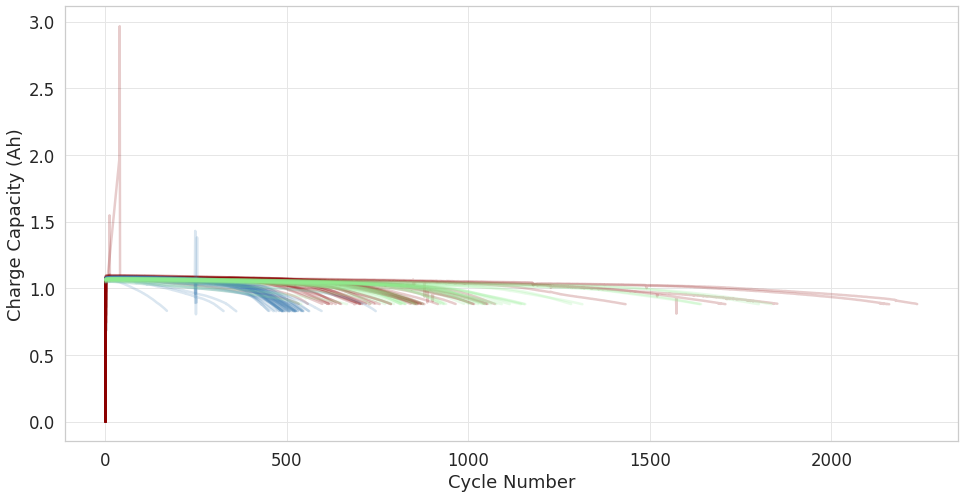

In [ ]:
# for the cell in each batch plot charge capacity vs cycle number
plt.figure(figsize=(16,8))
plt.xlabel('Cycle Number')
plt.ylabel('Charge Capacity (Ah)')

for cell in batch1.keys():
    plt.plot(batch1[cell]['summary']['cycle'], batch1[cell]['summary']['QC'], color = 'darkred', alpha = 0.2)
for cell in batch2.keys():
    plt.plot(batch2[cell]['summary']['cycle'], batch2[cell]['summary']['QC'], color = 'steelblue', alpha = 0.2)
for cell in batch3.keys():
    plt.plot(batch3[cell]['summary']['cycle'], batch3[cell]['summary']['QC'], color = 'lightgreen', alpha = 0.2)

(0.8, 1.1)

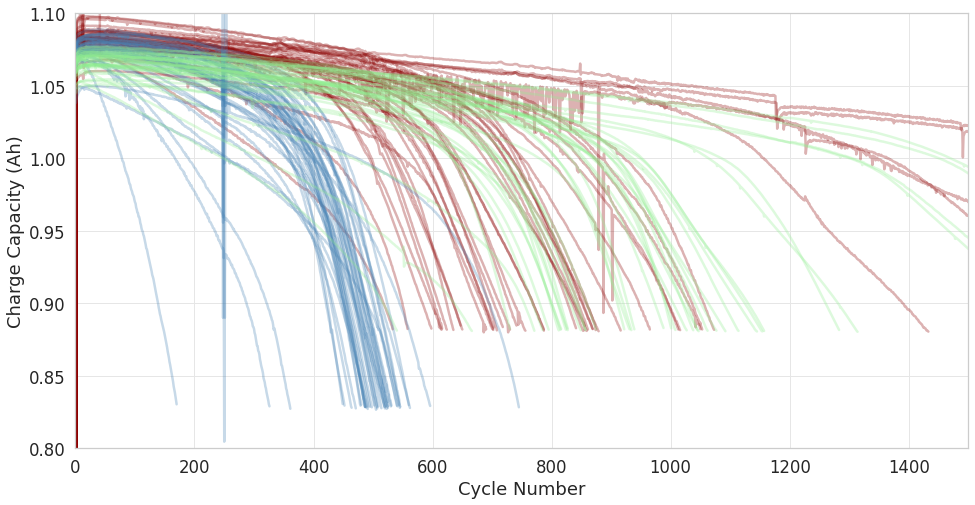

In [ ]:
# adjust the x and y limits to better see the data
plt.figure(figsize=(16,8))
plt.xlabel('Cycle Number')
plt.ylabel('Charge Capacity (Ah)')

for cell in batch1.keys():
    plt.plot(batch1[cell]['summary']['cycle'], batch1[cell]['summary']['QC'], color = 'darkred', alpha = 0.3)
for cell in batch2.keys():
    plt.plot(batch2[cell]['summary']['cycle'], batch2[cell]['summary']['QC'], color = 'steelblue', alpha = 0.3)
for cell in batch3.keys():
    plt.plot(batch3[cell]['summary']['cycle'], batch3[cell]['summary']['QC'], color = 'lightgreen', alpha = 0.3)

plt.xlim(0, 1500)
plt.ylim(0.8, 1.1)

**For this analysis we are focused on the cycle life variation from batch to batch**

In [ ]:
# Create a dataframe with the the max number of cycles for each cell being tested in each batch (use list comprehension to unpack the list of lists in the dictionary)
cycle_lifes = pd.DataFrame.from_dict({
                            'batch1': [item for sublist in [item for sublist in batch1_df.cycle_life for item in sublist] for item in sublist], 
                            'batch2': [item for sublist in [item for sublist in batch2_df.cycle_life for item in sublist] for item in sublist], 
                            'batch3': [item for sublist in [item for sublist in batch3_df.cycle_life for item in sublist] for item in sublist]}, orient='index').transpose()
cycle_lifes.tail(5) # note NaN here means that the batch does not have cells 40, 41, 42 this is because batch 2 has more cells being tested then the other 2

batch1  batch2  batch3
38   651.0   462.0   940.0
39   616.0   457.0  1801.0
40   599.0   487.0     NaN
41     NaN   429.0     NaN
42     NaN   713.0     NaN

In [ ]:
cycle_lifes.describe(percentiles=[.25, .5, .75])

batch1      batch2       batch3
count    41.000000   43.000000    40.000000
mean    921.341463  473.209302  1021.925000
std     400.765867   76.808531   288.743377
min     534.000000  148.000000   541.000000
25%     702.000000  461.000000   827.250000
50%     842.000000  481.000000   964.500000
75%     966.000000  499.000000  1098.500000
max    2237.000000  713.000000  1836.000000

**Visualising how the maximum cycle life numbers vary in the form of a histogram**

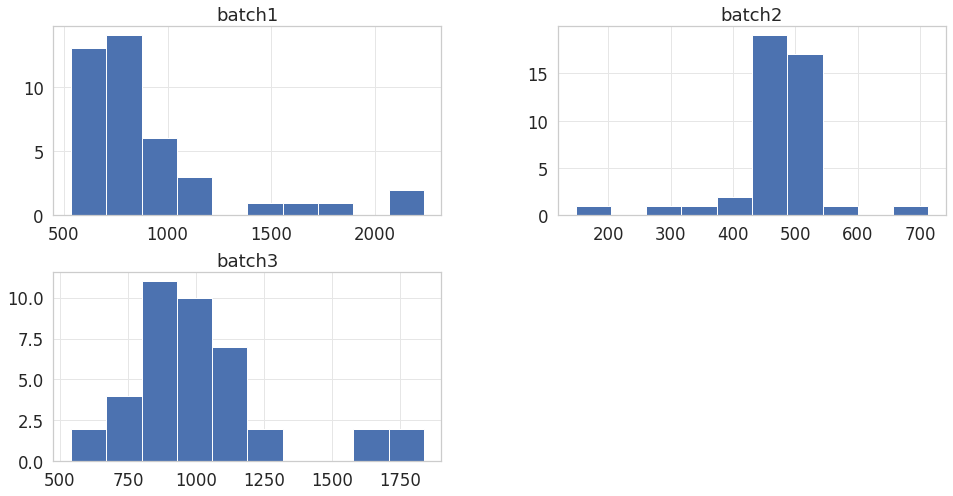

In [ ]:
cycle_lifes.hist(bins=10, figsize=(16,8));

**Overlaying all of the histograms on the same graph**

We can see that the means between batches all three batches differ, the variance between batch 2 and the other two batches also differ.


(0.0, 0.003)

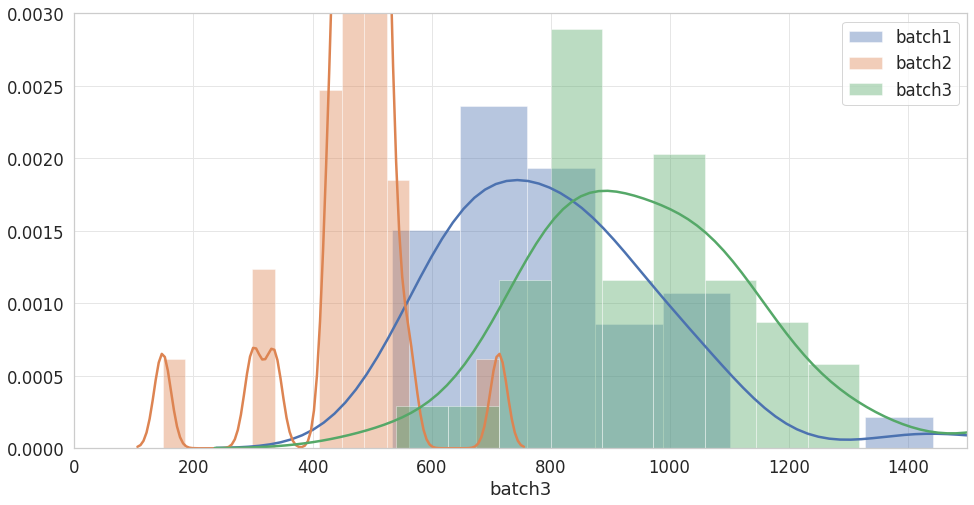

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(cycle_lifes['batch1'], label='batch1', bins = 15)
sns.distplot(cycle_lifes['batch2'], label='batch2', bins = 15)
sns.distplot(cycle_lifes['batch3'], label='batch3', bins = 15)
plt.legend()
plt.xlim(0,1500)
plt.ylim(0,.0030)

Substracting the mean we can better see this difference in variance between batch2 and the other two batches

(-500.0, 500.0)

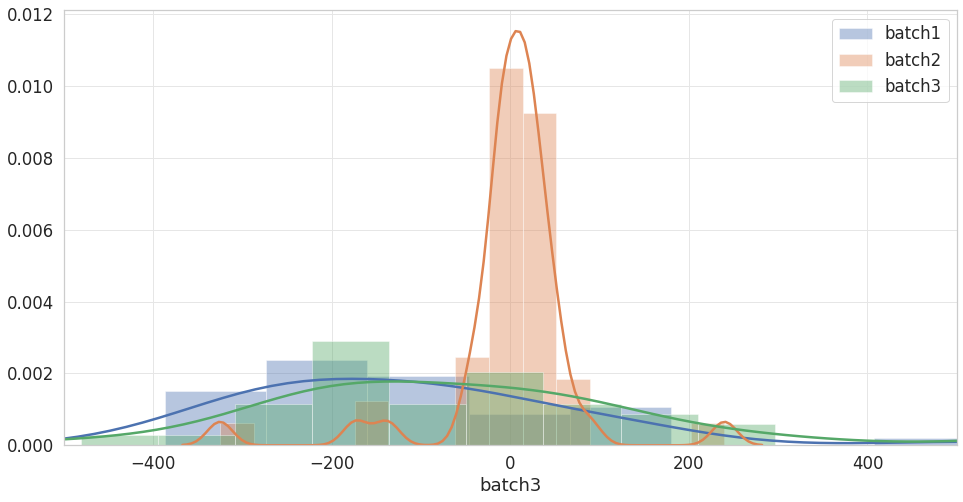

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(cycle_lifes['batch1'] - (batch1_df.cycle_life.transpose().mean())[0][0], label='batch1', bins = 15)
sns.distplot(cycle_lifes['batch2'] - (batch2_df.cycle_life.transpose().mean())[0][0], label='batch2', bins = 15)
sns.distplot(cycle_lifes['batch3'] - (batch3_df.cycle_life.transpose().mean())[0][0], label='batch3', bins = 15)
plt.legend()
plt.xlim(-500,500)

**Performing a full standardisation (substracting the mean and dividing by the standard deviation)**

This allows a normalized comparison between the three batches and graphically suggests there are no significant statistical diffences between the three batches (particularly between batch1 and batch3). 

(-5.0, 5.0)

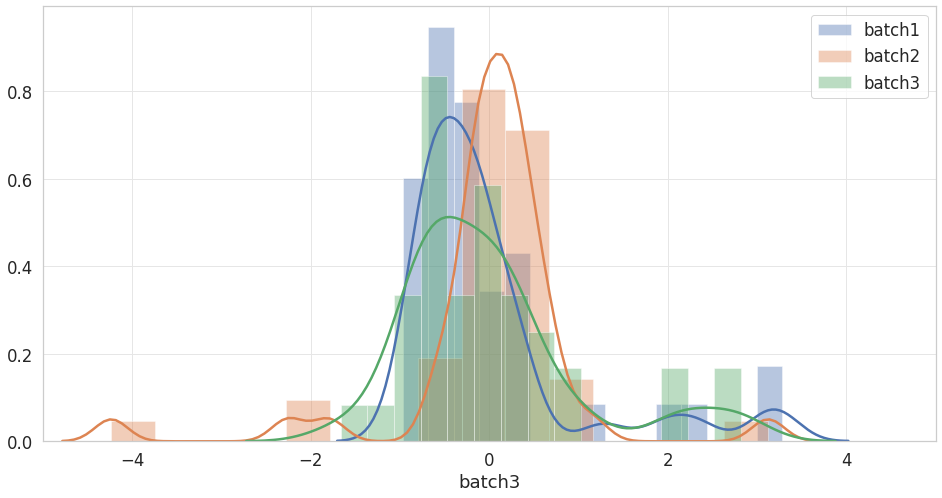

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(((cycle_lifes['batch1'] - (batch1_df.cycle_life.transpose().mean())[0][0]) / (batch1_df.cycle_life.transpose().std())), label='batch1', bins = 15)
sns.distplot(((cycle_lifes['batch2'] - (batch2_df.cycle_life.transpose().mean())[0][0]) / (batch2_df.cycle_life.transpose().std())), label='batch2', bins = 15)
sns.distplot(((cycle_lifes['batch3'] - (batch3_df.cycle_life.transpose().mean())[0][0]) / (batch3_df.cycle_life.transpose().std())), label='batch3', bins = 15)
plt.legend()
plt.xlim(-5,5)

The graph above also helps us understand the distribution families of the process, which will be useful when developing a models:
- the distributions can be approximated with normal distributions
- all batches are from the same distribution family (normal)




**Using the Pearson correlation to visualise the batch-to-batch variation**

The higher the correlation between the batches the lower the variation between them. 
This indicates there is a significant variation between batch2 and batch1.

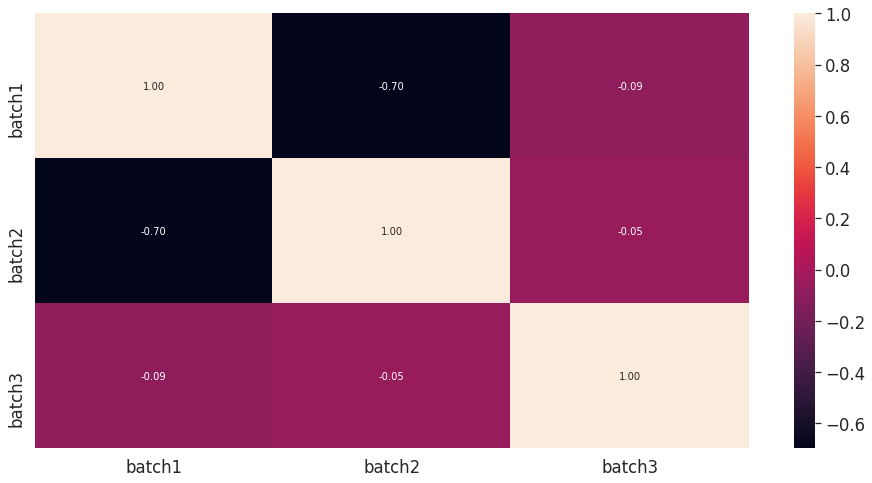

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(((cycle_lifes-cycle_lifes.mean()) / cycle_lifes.std()).corr(), annot=True, fmt=".2f")
plt.show()

### Analysis of Variance (**ANOVA**)

From the naive analysis in the following two sections we can see there are significant differences between the mean cycle life of batch 2 and the other two. There are large differences in the variances of all three batches, in particular between batch 1 and the other two batches. 

#### **Calculating the mean cycle life of each batch**


In [ ]:
batch1_df.cycle_life.transpose().mean()

array([[921.34146341]])

In [ ]:
batch2_df.cycle_life.transpose().mean()

array([[473.20930233]])

In [ ]:
batch3_df.cycle_life.transpose().mean()

array([[1021.925]])

####  **Calculating the variance of each batch**

In [ ]:
batch1_df.cycle_life.transpose().var()

160613.2804878049

In [ ]:
batch2_df.cycle_life.transpose().var()

5899.5503875969

In [ ]:
batch3_df.cycle_life.transpose().var()

83372.7378205128

However, this analysis has no statistical value and contradicts the distribution analysis in the previous sections.

A rigurous analysis is detailed in the next sections.  

#### **One-Way ANOVA** 

We can formulate a null hypothesis that there is no difference between the means of the cycle lives, between each of the three batches [[12]](https://www.statsmodels.org/stable/examples/notebooks/generated/interactions_anova.html).

- **Null hypothesis:** Cycle lifes of cells in each batch means are equal (no differences between the means of batches)
- **Alternative hypothesis:** At least, one batch clycle live mean is different from other others

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean [[13]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html).

In [ ]:
# stats f_oneway functions takes the groups as input and returns F and P-value
b1cl = list(cycle_lifes.batch1.dropna())
b2cl = list(cycle_lifes.batch2.dropna())
b3cl = list(cycle_lifes.batch3.dropna())

fvalue, pvalue = stats.f_oneway(b1cl, b2cl, b3cl)
print(fvalue, pvalue)

43.683580315292694 5.240151495107865e-15


As p << 0.05, we can reject the null hypothesis that there is no difference between the means. 

**Thus, one-way ANOVA tells us there is a statistical difference between the batches.**

#### **ANOVA OLS**

We build an Ordinary Least Squares (OLS) model

In [ ]:
from statsmodels.formula.api import ols

# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(cycle_lifes.reset_index(), id_vars=['index'], value_vars=['batch1', 'batch2', 'batch3']) 
# replace column names
d_melt.columns = ['index', 'batches', 'cell_cycle_life'] 
# drop NaN values
d_melt.dropna(inplace = True)

d_melt

index batches  cell_cycle_life
0        0  batch1           1852.0
1        1  batch1           2160.0
2        2  batch1           2237.0
3        3  batch1           1434.0
4        4  batch1           1709.0
..     ...     ...              ...
121     35  batch3            786.0
122     36  batch3           1642.0
123     37  batch3           1046.0
124     38  batch3            940.0
125     39  batch3           1801.0

[124 rows x 3 columns]

We fit the model to the data and then calculate an ANOVA table of the fit

In [ ]:
model = ols('cell_cycle_life ~ C(batches)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df         F        PR(>F)
C(batches)  7.165442e+06    2.0  43.68358  5.240151e-15
Residual    9.923849e+06  121.0       NaN           NaN

**ANOVA OLS Interpretation**

The P-value obtained from ANOVA analysis is significant (P<0.05). 

Thus ANOVA OLS informs us that **there are significant differences among treatments.**


#### **ANOVA Validation**
Now we test if we can trust the results form ANOVA by testing the null hypothesis that the distribuitons are normal.

The Shapiro-Wilk test can be used to check the normal distribution of residuals. Null hypothesis: data is drawn from normal distribution [[14]](https://reneshbedre.github.io/blog/anova.html).

In [ ]:
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.7641300559043884 7.766104382841976e-13


Significant p value i.e. << 0.05 indicates the null hypothesis that the combined batches distribution is nornal can be rejected in favor of the alternative hypothesis. Thus, **strictly speaking, we cannot rely on the ANOVA test results, since ANOVA assumes a normal distribution**. Even though graphically the individual distributions approach normals, the combined distribuition is not sufficiently close to a normal distribution.

Now we want to compare the variances, since we cannot assume a normal distribution for the *combined batches*, we can use a test for variance equivalence that does not make this assumption:

#### **The Levene test**


In [ ]:
w, pvalue = stats.levene(cycle_lifes['batch1'].dropna(), cycle_lifes['batch2'].dropna(), cycle_lifes['batch3'].dropna())
print(w, pvalue)

9.246636944755307 0.00018324926305829535


Non-significant p value i.e. p<< 0.5 --> we cannot reject the null hypothesis (same variance for all). 

**Thus that there is no difference between the variances of the cycle lives between batches.**

#### **Tukey HSD test**
From ANOVA analysis, we know that batch mean differences are statistically significant, but ANOVA does not tell which batches are significantly different from each other. To know the pairs of significantly batch means, we can perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
m_comp = pairwise_tukeyhsd(endog=d_melt['cell_cycle_life'], groups=d_melt['batches'], alpha=0.05)
print(m_comp)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
batch1 batch2 -448.1322  0.001 -596.4776 -299.7867   True
batch1 batch3  100.5835 0.2583  -50.4528  251.6199  False
batch2 batch3  548.7157  0.001   399.424  698.0074   True
---------------------------------------------------------


Above results from Tukey HSD suggests that except batch1-batch3, all other pairwise comparisons for batches rejects null hypothesis and indicates statistical significant differences. **Therefore, the mean of batch2 is sitistically different from the other two.**



### **Conclusions**
- approximately normal distributions, but merged distribution not stricly speaking normal
- the means of batches 1 and 3 are statistucally the same
- the mean of batch2 is sitistically different from the other two (it has a bias)
- therefore we would like to use batch2 and batch1 or batch 3 in training to prevent a bias model
- no difference in variance betweem the 3 batches

### **Control Charts**

The three batches are designed for the experimental evaluation of their performence. However, it is equally possible to consider them as cells resulting from a novel battery manufacturing process. In this case, in order to determine if the manufacturing process is under control, we can create Control Charts from the data [[14]](https://github.com/carlosqsilva/pyspc). 

The following exponentially weighted moving average charts (EWMA), one for each batch, show:
- the mean cycle life for each batch (black line)
- the Upper and Lower Control limits (red dotted lines)
- the cells whose cycle lifes (SoH) violate at least one of Nelson's Rules (red dots)
- this indicates if the process is under control in manufactruing the cells (blue dots)

**Batch1 Control Chart**

The process is out of control at the begining and end of the manufacturing, violating at least one of Nelson's rules

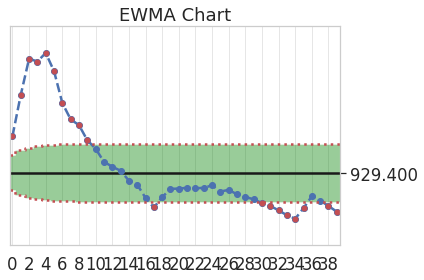

<pyspc: (-9223363276247979162)>

In [ ]:
spc(cycle_lifes['batch1'][0:40]) + ewma() + rules()

**Batch2 Control Chart**

The process is aout of control at the begining and has a much lower mean SoH. 

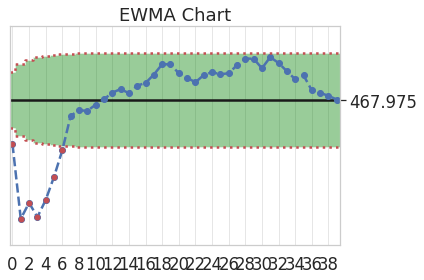

<pyspc: (8760606898517)>

In [ ]:
spc(cycle_lifes['batch2'][0:40]) + ewma() + rules()

**Batch3 Control Chart**

The process is entirely under control.

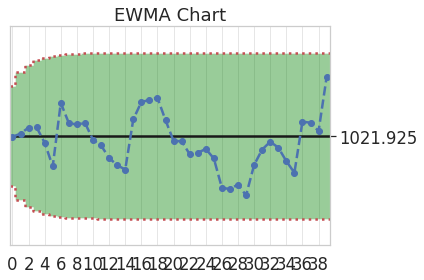

<pyspc: (8760606986802)>

In [ ]:
spc(cycle_lifes['batch3'][0:40]) + ewma() + rules()

## **B.** Identifying an explanatory variable
**Looking at the data of one of the cells**

We can see how the various features are corellated using a pair-plot.

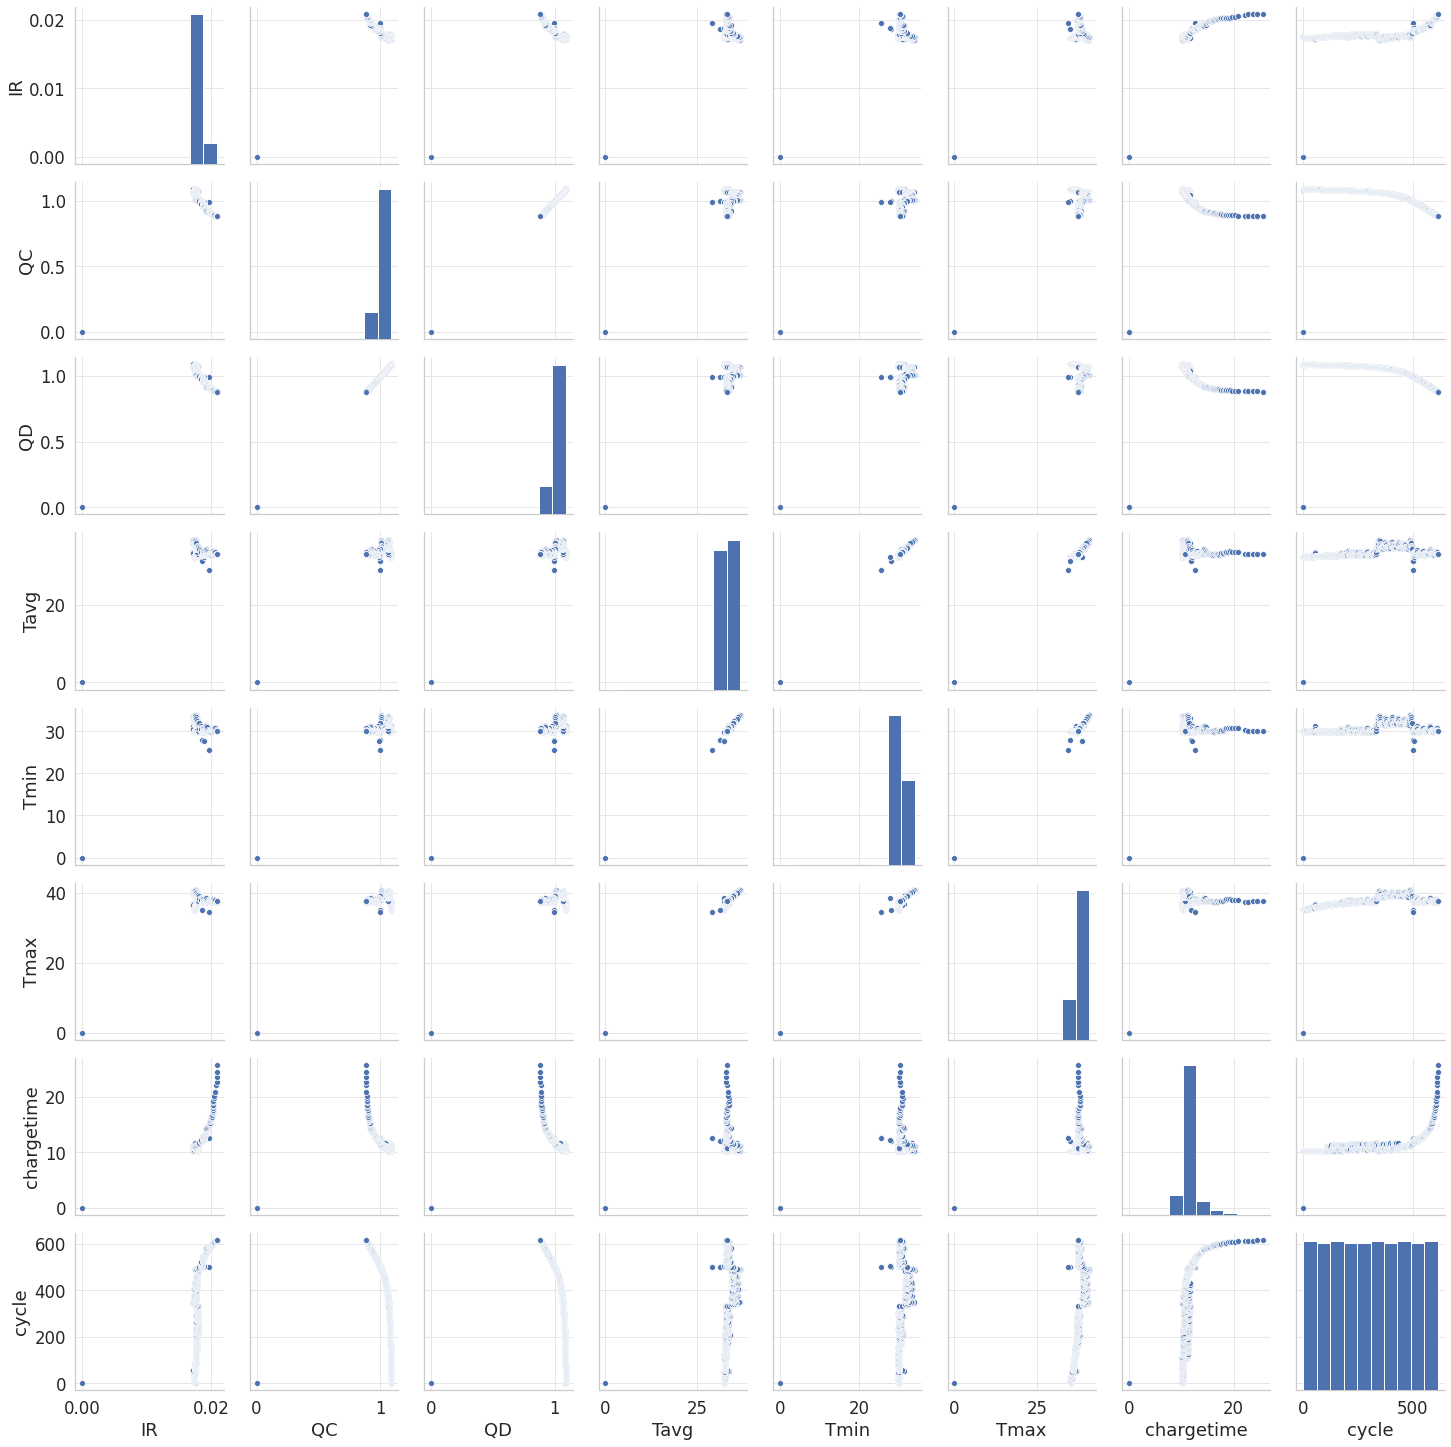

In [ ]:
sns.pairplot(one_cell);

**Observations**
- Internal Resistance increases sharply towards the end of the cycle life
- QC and QD (states of charge) decreases at an increasing rate after the half-way mark in the number of cycles
- Tmin and Tmax have little predicitve power as they do not evolve significantly with cycle life. 
- Tmax has a slight increasing trent with the number of cycles (since there is increased IR this is a direct concequence of that), thus Tmax is an indirect indicator of cycle life.
- chargetime increases sharply after the 2/3 mark in the SoH and follows an exponential trent.

Similarly it is possible to create a PairGrid

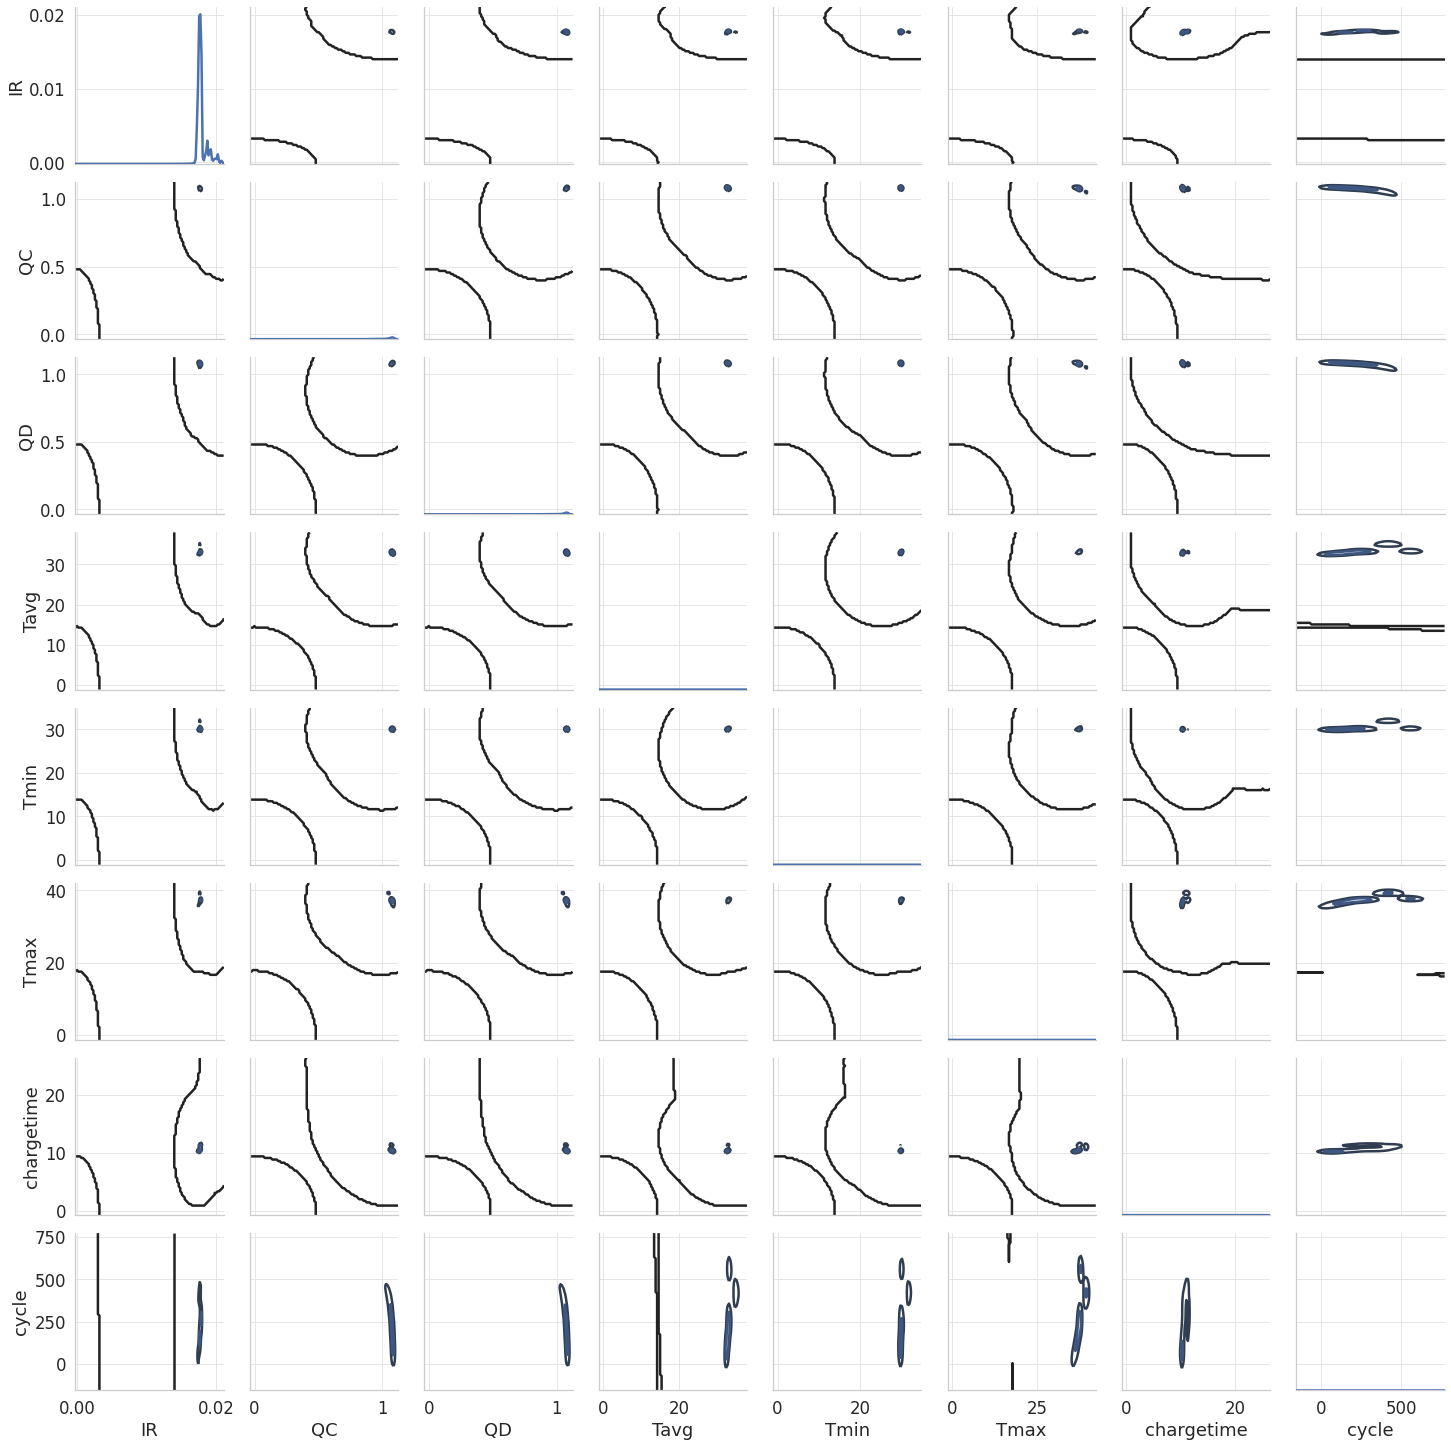

In [ ]:
g = sns.PairGrid(one_cell)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=2);

**Observations**
The graph above shows many of the observations we made previously, particularly with respect to QC and QD. 

However, it displays a higher fluctuation of Tmax than IR suggesting that it as a higher predictive power than IR, although physically Tmax is a indirectly related to cycle life (since Tmax increases due to increased inneficiencies in the cell, among which Internal Resistance). 

Pandas DataFrame has a corr method that calculates Pearson’s correlation coefficient between all couples of numeric columns of the DataFrame.


In [ ]:
one_cell.cov()

IR        QC        QD  ...        Tmax  chargetime         cycle
IR          0.000001 -0.000006 -0.000006  ...    0.001116    0.001606      0.097229
QC         -0.000006  0.004806  0.004833  ...    0.042839   -0.070349     -7.903560
QD         -0.000006  0.004833  0.004861  ...    0.042664   -0.071105     -7.980251
Tavg        0.000846  0.047676  0.047590  ...    3.395234    0.546170    114.190292
Tmin        0.000716  0.046320  0.046271  ...    3.088753    0.434421     91.227727
Tmax        0.001116  0.042839  0.042664  ...    3.997986    0.969153    175.104384
chargetime  0.001606 -0.070349 -0.071105  ...    0.969153    3.950721    224.286318
cycle       0.097229 -7.903560 -7.980251  ...  175.104384  224.286318  31570.000000

[8 rows x 8 columns]

We can put this into a heatmap of the correlation matrix. 

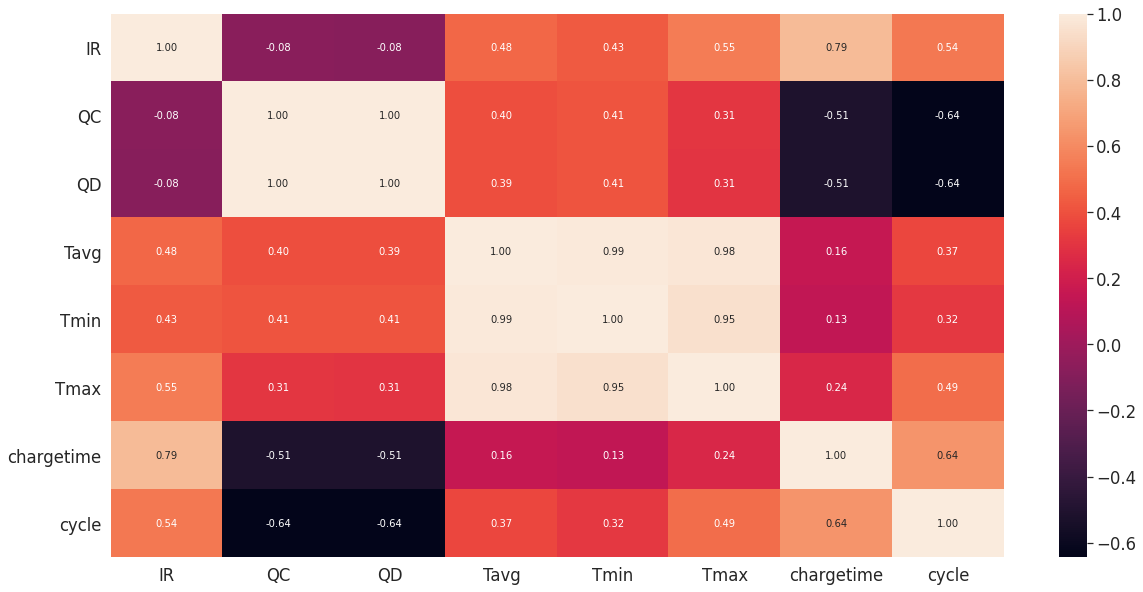

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(one_cell.corr(), annot=True, fmt=".2f")
plt.show()

**Observations:**
- the charge/discharge capacities are inversely corelated with the number of cycles (the battery) 
- they have an approximately equal amount of negative corellation (i.e. we can equally use one or the other to predict max no of cycles)
- internal resistance is corelated with charge time -- this means the more the battery is cycled the higher the internal resistance in it
- the charge time increases even more than internal resistance with the number of cycles

###  Individual cells - features mean correlation

Unwrapping the DataFrame to be able to carry out further analysis on it. 

**We first at the mean value and then at the max (end of the cycle live) value of the predictor variables**

In [ ]:
batch1_df_summary_mean = pd.DataFrame()

# For each cell in batch1, calculate the mean of the cell properties for each charge cycle
for summary_property in batch1_df_summary.columns:
    batch1_df_summary_mean['m_' + summary_property] = pd.DataFrame(batch1_df_summary[summary_property].values.tolist()).mean(1)
batch1_df_summary_mean.tail(5)

m_IR      m_QC      m_QD  ...     m_Tmax  m_chargetime  m_cycle
36  0.017315  1.040156  1.040054  ...  38.465404     12.572123    525.5
37  0.017296  1.041511  1.041196  ...  39.901232     11.697115    351.0
38  0.016550  1.032449  1.032325  ...  38.848880     11.586327    325.5
39  0.017920  1.041792  1.041510  ...  37.598192     11.470746    308.0
40  0.017228  1.044574  1.044490  ...  38.743194     11.258262    299.5

[5 rows x 8 columns]

In [ ]:
batch1_df_summary_mean.corr()

m_IR      m_QC      m_QD  ...    m_Tmax  m_chargetime   m_cycle
m_IR          1.000000  0.360906  0.388293  ...  0.018278      0.469448  0.192802
m_QC          0.360906  1.000000  0.923888  ...  0.102561     -0.281298 -0.283861
m_QD          0.388293  0.923888  1.000000  ...  0.113393     -0.228250 -0.238034
m_Tavg       -0.020185  0.162016  0.178203  ...  0.955910     -0.299429 -0.593823
m_Tmin       -0.010634  0.272980  0.278582  ...  0.690496     -0.413301 -0.701282
m_Tmax        0.018278  0.102561  0.113393  ...  1.000000     -0.190124 -0.456195
m_chargetime  0.469448 -0.281298 -0.228250  ... -0.190124      1.000000  0.765117
m_cycle       0.192802 -0.283861 -0.238034  ... -0.456195      0.765117  1.000000

[8 rows x 8 columns]

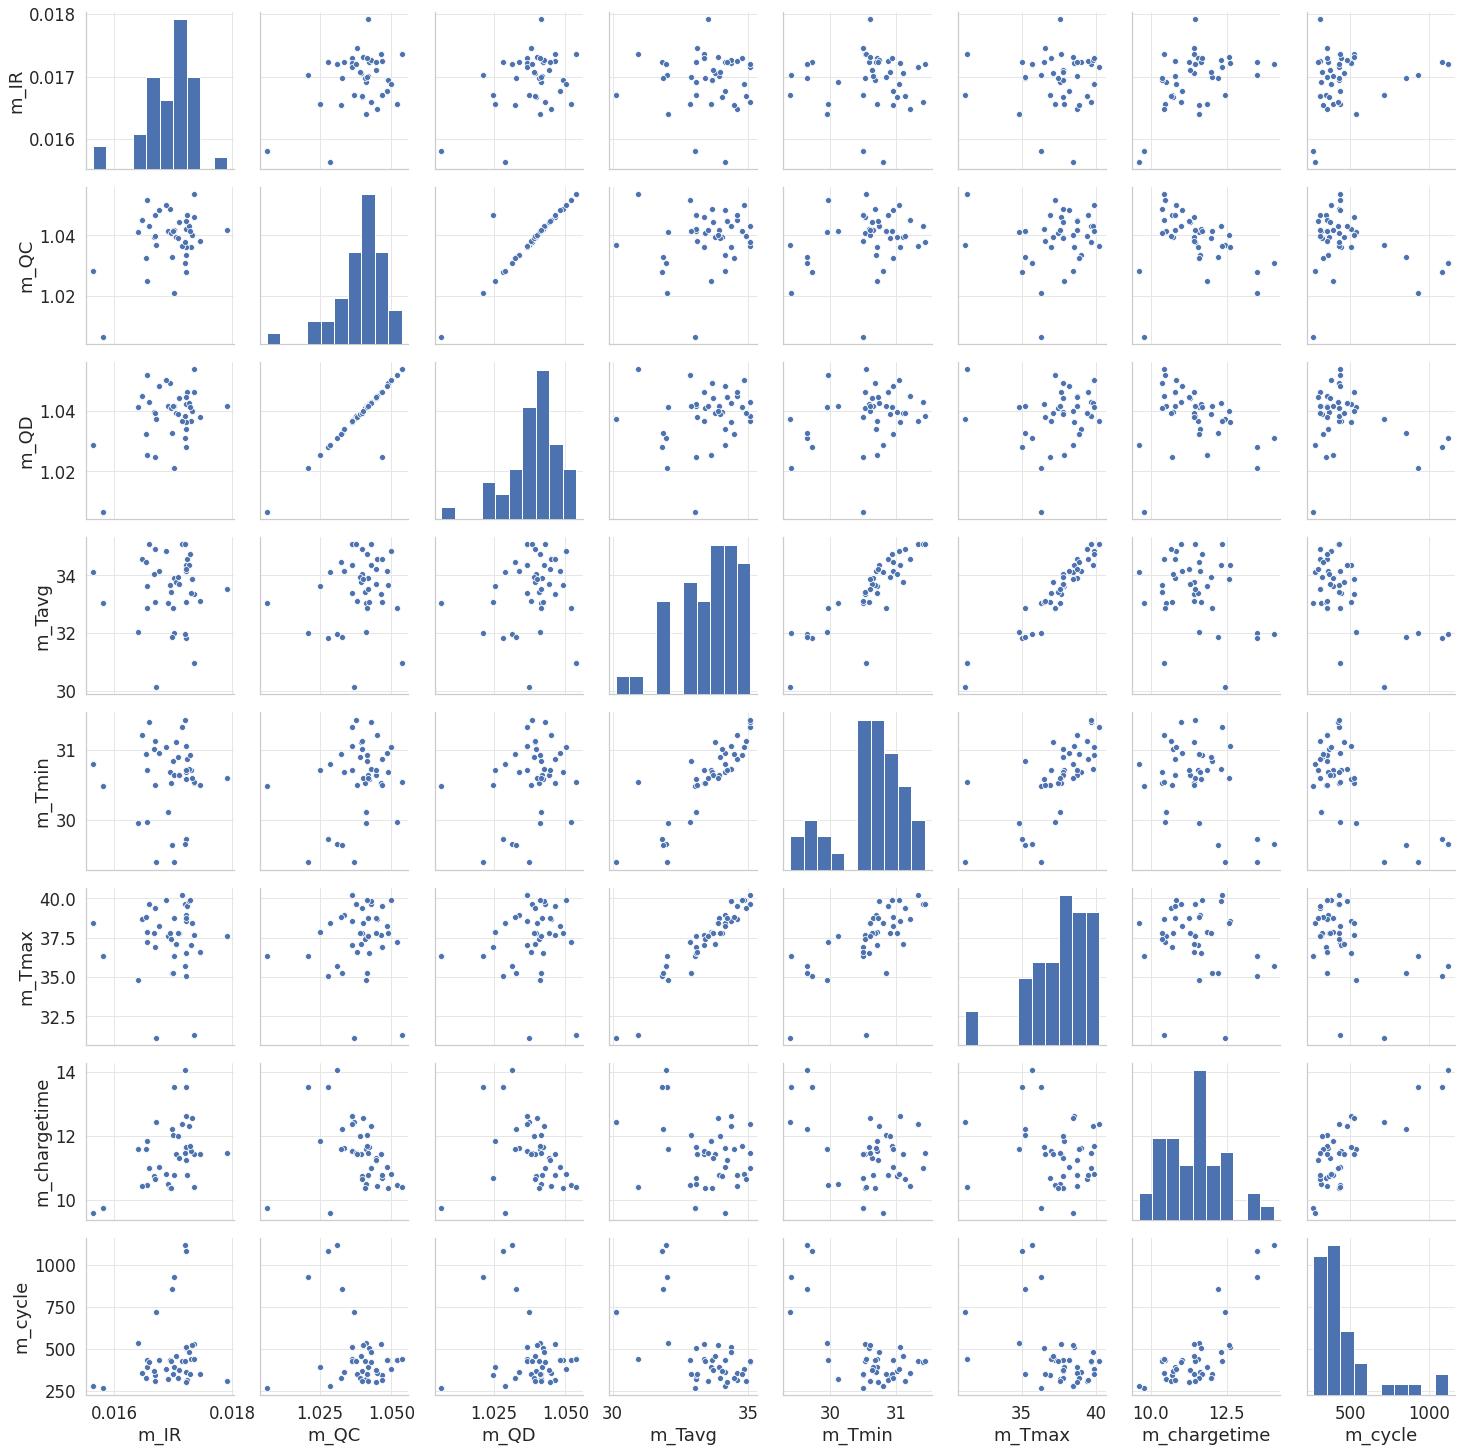

In [ ]:
sns.pairplot(batch1_df_summary_mean);

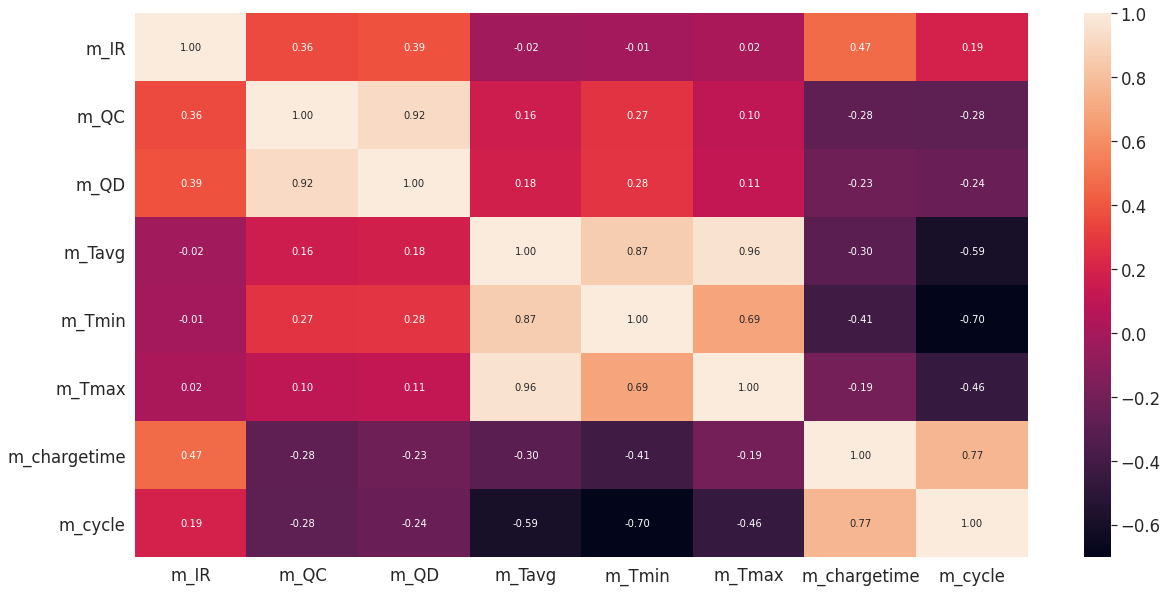

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(batch1_df_summary_mean.corr(), annot=True, fmt=".2f")
plt.show()

**Observations:**

- this shows us how the average of the features in each cycle are correlated within each other between cycles
- it is an indication of how the features can predict the mean cycle life
- Note we are trying to predict the end cycle, thus it would make more sense to observe how early cycle predictor features are correlated with the max number of cycles

###  Individual cells - features end-of-life correlation

In [ ]:
# Get the index of the last cycle where the battery functioned
def f(x):
    if x.last_valid_index() is None:
        return np.nan
    else:
        return x[x.last_valid_index()]

# Initate a new dataframe 
batch1_df_summary_end_of_life = pd.DataFrame()

# Get the end of life values
for summary_property in batch1_df_summary.columns:
    batch1_df_summary_end_of_life['eol_' + summary_property] = pd.DataFrame(batch1_df_summary[summary_property].values.tolist()).apply(f, axis=1)
#     sapply(batch1_df_summary_max[summary_property], function(x) max(which(!is.na(x))))

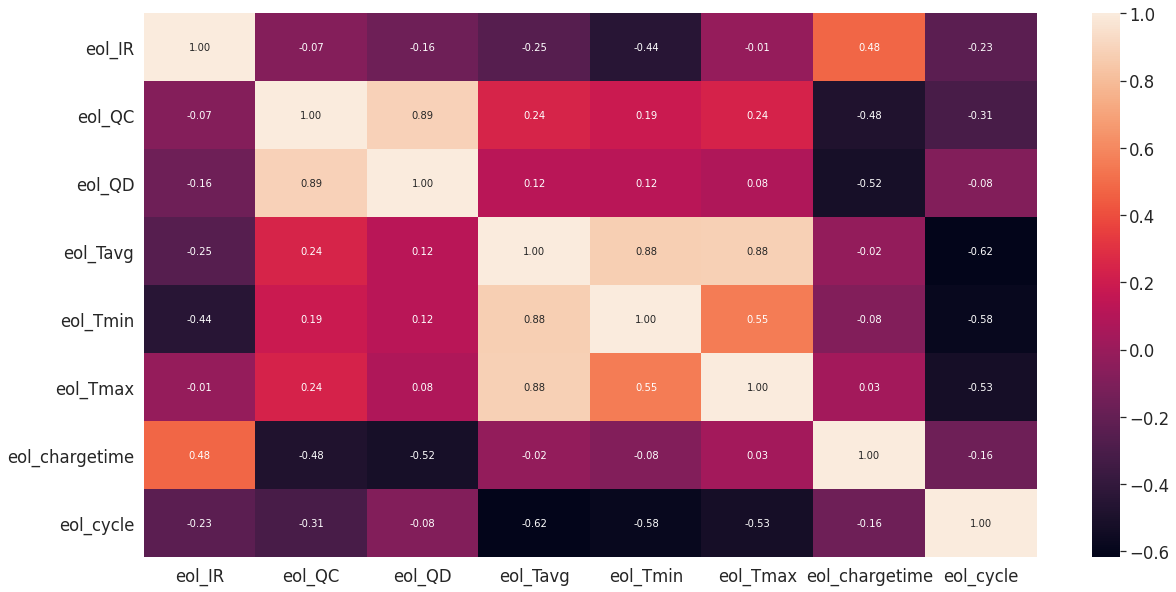

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(batch1_df_summary_end_of_life.corr(), annot=True, fmt=".2f")
plt.show()

**Observations at the end of the SoH**
- the charge time has the strongest correlation with the max life of the battery 
- The predictor variable "IR" cell internal resistance also has a negative correlation
- QC has a stronger negative correlation than QD - this is more pronounced than it was at the mean of the cycle lives -- suggesting QC has a stronger predictive capacity than QD


###**Conclusion**
- Taking into consideration all of the observations above, we can chose the Charge Capacity as an explanatory variable.
- Internal Resistance is also a possive explanatory variable and it is worth exploring its use as well. 

## Unifying the dataset
We will unify the data across batches and remove the lowest battery cycle life from the data-set for all following work

In [ ]:
n_batch1 = len(batch1)
n_batch2 = len(batch3)
n_batch3 = len(batch3)
print('The number if cells in each batch is the following: n_batch1 = ',n_batch1,', n+batch2 = ', n_batch2, ', n_batch3 = ', n_batch3)

The number if cells in each batch is the following: n_batch1 =  41 , n+batch2 =  40 , n_batch3 =  40


In [ ]:
# Unify all dictionaries into a common one
bat_dict = {**batch1, **batch2, **batch3}
print('The total number of cells is: ', len(bat_dict))

The total number of cells is:  124


In [ ]:
# Find the cell with the lowest battery cycle
bat_dict_df = pd.DataFrame.from_dict(bat_dict, orient = 'index')
bat_dict_df.cycle_life.sort_values().head(4)

b2c1     [[148.0]]
b2c0     [[300.0]]
b2c3     [[335.0]]
b2c46    [[429.0]]
Name: cycle_life, dtype: object

Tthe cell with the lowest lifecycle is: *b2c1*

In [ ]:
# Let's remove it form the dictionaries
del batch2['b2c1']
del bat_dict['b2c1']

# Also update the dataframes that contained b2c1
batch1_df = pd.DataFrame.from_dict(batch1, orient = 'index')
bat_df = pd.DataFrame.from_dict(bat_dict, orient = 'index')
bat_df.head(2)

cycle_life  ...                                             cycles
b1c0  [[1852.0]]  ...  {'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...
b1c1  [[2160.0]]  ...  {'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...

[2 rows x 4 columns]

In [ ]:
bat_df_summary = pd.DataFrame.from_dict(dict(bat_df.summary), orient='index')
bat_df_summary.head(2)

IR  ...                                              cycle
b1c0  [0.0, 0.016742354, 0.016724309, 0.016681245, 0...  ...  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
b1c1  [0.0, 0.017038831, 0.017009802, 0.016928403, 0...  ...  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...

[2 rows x 8 columns]

In [ ]:
n = len(bat_dict.keys()) # record the number of cells tested remaining in the dataset
print('The number of cells remaining in unified dataset: ',n)

The number of cells remaining in unified dataset:  123


In [ ]:
# Create a dataframe with the the max number of cycles for each cell being tested in each batch (use list comprehension to unpack the list of lists in the dictionary)
cycle_lifes = pd.DataFrame.from_dict({'cycle_life': [item for sublist in [item for sublist in bat_df.cycle_life for item in sublist] for item in sublist]}, orient='index').transpose()
cycle_lifes.tail(5)

cycle_life
118       786.0
119      1642.0
120      1046.0
121       940.0
122      1801.0

# Feature Discovery (Naive)
First, we will naively attempt to predict cycle life of a battery using features from the first 100 cycles.


## **C.** Evolution of discharge capacity in the dataset
We can visualise how the evolution of the predictor variable Discharge Capacity **QD** varies thoughouhout the cells. 

We would like to see that QD for earlier cycles has just as much predictive power as QD for later cycles. This would allows us to use the QD information from the first few cycles to predict the SoH at later cycles. 

For this purpose we define the discharge capacity ratio between the 100th and 20th cycle and see its distribution among the cells in the form of a histogram.

In [ ]:
# Define the cycles between which we want to calculate the ratio
upper_cycle_no = 100
lower_cycle_no = 20

# Extracting the QD ratio for the first cell (0)
bat_df_summary.QD.iloc[0][upper_cycle_no] / bat_df_summary.QD.iloc[0][lower_cycle_no]

0.999344756833167

In [ ]:
# Looping over all cells to generate a list of the QD ratios between the upper and lower limits 
QD_ratios = list()
for cell_no in range(0,n):
  QD_ratios.append(bat_df_summary.QD.iloc[cell_no][upper_cycle_no] / bat_df_summary.QD.iloc[cell_no][lower_cycle_no])

(0.98, 1.02)

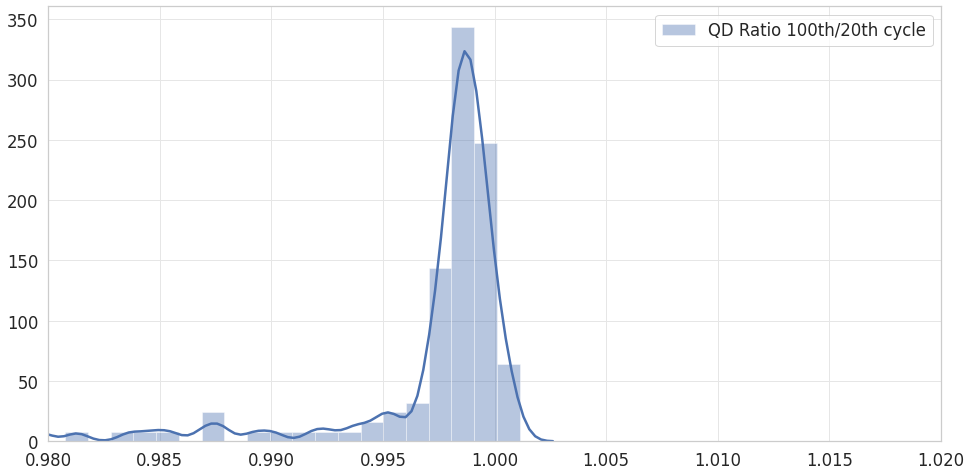

In [ ]:
# Rlotting it as a histogram
plt.figure(figsize=(16,8))
sns.distplot(QD_ratios, label='QD Ratio '+str(upper_cycle_no)+'th/'+str(lower_cycle_no)+'th cycle', bins = 30)
plt.legend()
plt.xlim(0.98,1.02)

The distribution can be approximated with a tain heavy normal distribution


## **D.** Relationship of discharge capacity and cycle life

We can explore the relationship between discharge capacity and the battery cycle life by building a scatter plots between the log-transformed cycle life and discharge capacity at various cycle numbers. 

For this analysis we will compare agains the cycle life the:
- discharge capacity at cycle 2
- discharge capacity at cycle 100
- discharge capacit slope calculated between cycles 95-100.

First, create a list with the cycle lives of all cells:

In [ ]:
cycle_life_ls = [item for sublist in [item for sublist in bat_df.cycle_life for item in sublist] for item in sublist]

Then let's extract the discharge capacicy for cycle 2, 95 and 100

In [ ]:
# Define a list of the cycles to extract
target_cycles = [2, 95, 100] 

# Initiate a DataFrame in which to store them
QD_cycles = pd.DataFrame(columns=['QD_cycle_'+str(cn) for cn in target_cycles])

# For target cycle each, generate a list of the target parameter at that cycle for all of the cells and store it in the dataframe 
for cycle_no in target_cycles:
  QD_cycles['QD_cycle_'+str(cycle_no)] = [bat_df_summary.QD.iloc[cell_no][cycle_no] for cell_no in range(0,n)]
QD_cycles.tail(4)

QD_cycle_2  QD_cycle_95  QD_cycle_100
119    1.067686     1.069179      1.069030
120    1.070812     1.072477      1.072310
121    1.070332     1.072908      1.072899
122    1.070114     1.071107      1.070958

We will bring all of the data to be plotted under one DataFrame called **analysis_df**

In [ ]:
analysis_df = QD_cycles
analysis_df['cycle_life'] = cycle_life_ls
analysis_df.tail(4)

QD_cycle_2  QD_cycle_95  QD_cycle_100  cycle_life
119    1.067686     1.069179      1.069030      1642.0
120    1.070812     1.072477      1.072310      1046.0
121    1.070332     1.072908      1.072899       940.0
122    1.070114     1.071107      1.070958      1801.0

We will calculate the slope between 95 and 100, then drop the QD_cycle_95 column

In [ ]:
analysis_df['slope_90_to_100'] = (analysis_df.QD_cycle_100 - analysis_df.QD_cycle_95)/5
analysis_df.drop(columns='QD_cycle_95', inplace=True)
analysis_df.tail(4)

QD_cycle_2  QD_cycle_100  cycle_life  slope_90_to_100
119    1.067686      1.069030      1642.0        -0.000030
120    1.070812      1.072310      1046.0        -0.000033
121    1.070332      1.072899       940.0        -0.000002
122    1.070114      1.070958      1801.0        -0.000030

**Scatter plot log-transformed cycle life against discharge capacity at
cycle 2**

The hue indicates which cells have those values (darker hue indicates higher number cells from batch 3)

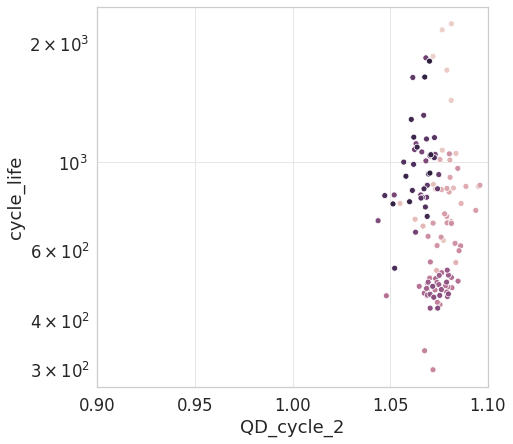

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
sns.scatterplot(x="QD_cycle_2", y="cycle_life", data=analysis_df, ax=ax, hue=analysis_df.index, legend=False);
ax.set_xbound(0.9,1.1)

**Scatter plot log-transformed cycle life against discharge capacity at
cycle 100**

The hue indicates which cells have those values (darker hue indicates higher number cells from batch 3)

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}, )

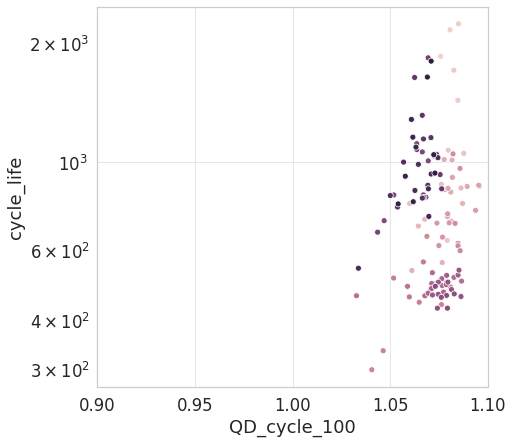

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
sns.scatterplot(x="QD_cycle_100", y="cycle_life", data=analysis_df, ax=ax, hue=analysis_df.index, legend=False);
ax.set_xbound(0.9,1.1)

**Scatter plot log-transformed cycle life against discharge capacity slope calculated between cycles 95-100**

The hue indicates which cells have those values (darker hue indicates higher number cells from batch 3)

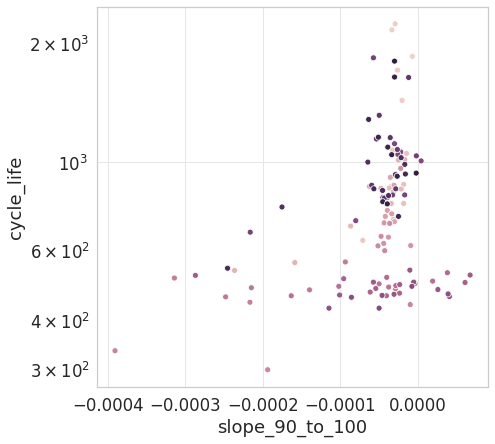

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
sns.scatterplot(x="slope_90_to_100", y="cycle_life", data=analysis_df, ax=ax, hue=analysis_df.index, legend=False);
# ax.set_xbound(-2,0.5)

**Correlation coefficients for each 3 features against log-transformed cycle life**

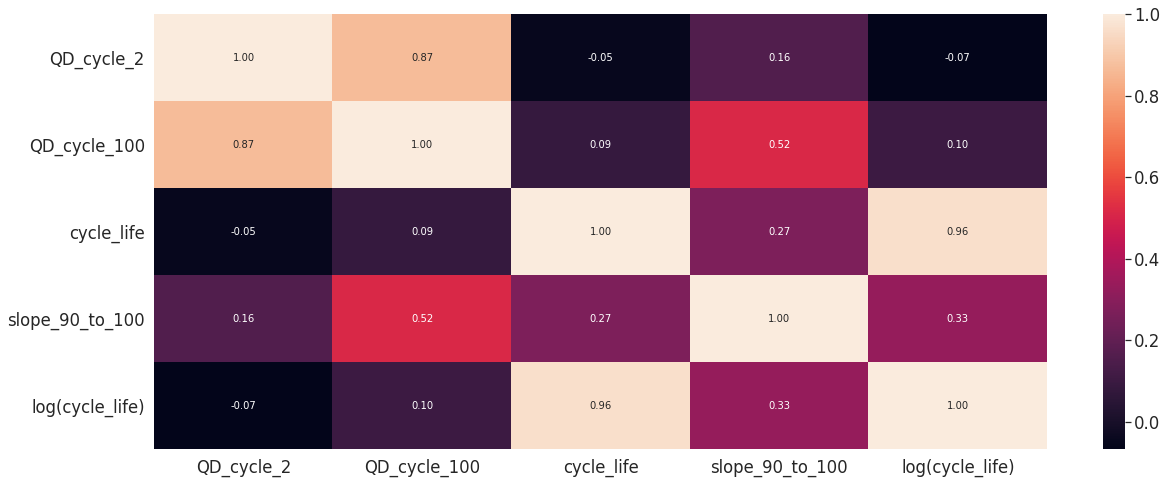

In [ ]:
import numpy as np
analysis_df['log(cycle_life)'] = np.log(analysis_df['cycle_life'])
# analysis_df.rename(columns={"cycle_life": "log(cycle_life)"},inplace=True)

plt.figure(figsize=(20,8))
sns.heatmap(analysis_df.corr(), annot=True, fmt=".2f")
plt.show()

**Observations:**
- the first three scatter plot figures show there is a weak correlations between the log of cycle life and the discharge capacity at cycle 2 and 100, as well as the discharge capacity rate between cycles 95 and 100
- These weak correlations are also observed in the Peasrion correlation matrix above (-.07, 0.1 and 0,.33 respectively)
- this is somewhat expected as capacity degradation in these early cycles is negligible
- for very early cycles there is actually a negative correlation between  QD_cycle 2 and log cycle_life as batteries increase their charge capacity in their first cycles after manufacturing
- aspects above are also reinforced by the analysis carried out by Severson et al [[7]](https://www.nature.com/articles/s41560-019-0356-8).

## **E.** Naive Multivariate Regression Model Implementation

Use will aim to predict the cycle life i.e. the number of cycles (int) until the cell reaches 80% capacity or the end of its life, by using using features derived just from discharge capacity as a function of cycles up to cycle to a certain cycle number to fit a multivariate regression model.

These discharge capacity features will be:
- raw data
- enriched data
 - maximums
 - differences between values
 - slope/intercept from linear fits between two values
 

### **I.** Model informed by Discharge Cycle features **up to cycle 100**

#### **Features data preparation**
**Raw data**

In [ ]:
# Define a list of the cycles to extract
target_cycles = range(0,100) # the first 100 cycles

# Initiate a DataFrame in which to store them
QD_cycles = pd.DataFrame(columns=['QD_cycle_'+str(cn) for cn in target_cycles])

# For target cycle each, generate a list of the target parameter at that cycle for all of the cells and store it in the dataframe 
for cycle_no in target_cycles:
  QD_cycles['QD_cycle_'+str(cycle_no)] = [bat_df_summary.QD.iloc[cell_no][cycle_no] for cell_no in range(0,n)]
QD_cycles.tail(4)

QD_cycle_0  QD_cycle_1  QD_cycle_2  ...  QD_cycle_97  QD_cycle_98  QD_cycle_99
119    1.065713    1.066920    1.067686  ...     1.069176     1.069031     1.068965
120    1.069167    1.070185    1.070812  ...     1.072469     1.072485     1.072418
121    1.068637    1.069720    1.070332  ...     1.072907     1.072925     1.072928
122    1.068802    1.069549    1.070114  ...     1.071034     1.070929     1.071125

[4 rows x 100 columns]

**Enriched data**

In [ ]:
# Max values
QD_cycles['QD_max'] = QD_cycles.max(axis=1)
QD_cycles.tail(2)

QD_cycle_0  QD_cycle_1  QD_cycle_2  ...  QD_cycle_98  QD_cycle_99    QD_max
121    1.068637    1.069720    1.070332  ...     1.072925     1.072928  1.073905
122    1.068802    1.069549    1.070114  ...     1.070929     1.071125  1.072145

[2 rows x 101 columns]

In [ ]:
# Differences between every 10 cycles
QQ_cycles_diffs10 = QD_cycles.diff(axis = 1, periods = 10).dropna(axis=1)
QQ_cycles_diffs10.rename(columns=lambda s: s+'_diffs10', inplace = True)
QQ_cycles_diffs10.tail(2)

QD_cycle_10_diffs10  ...  QD_max_diffs10
121             0.004277  ...        0.000849
122             0.002433  ...        0.001051

[2 rows x 91 columns]

In [ ]:
# Rates of change (slope) between every 5 cycles
QQ_cycles_slopes5 = QD_cycles.diff(axis = 1, periods = 5).dropna(axis=1)/5
QQ_cycles_slopes5.rename(columns=lambda s: s+'_slopes5', inplace = True)
QQ_cycles_slopes5.tail(2)

QD_cycle_5_slopes5  ...  QD_max_slopes5
121            0.000655  ...        0.000199
122            0.000422  ...        0.000208

[2 rows x 96 columns]

**Join all of the data**

In [ ]:
data_m1 = pd.concat([QD_cycles, QQ_cycles_diffs10, QQ_cycles_slopes5, analysis_df['cycle_life']], axis=1)
data_m1.tail(4)

QD_cycle_0  QD_cycle_1  ...  QD_max_slopes5  cycle_life
119    1.065713    1.066920  ...        0.000162      1642.0
120    1.069167    1.070185  ...        0.000171      1046.0
121    1.068637    1.069720  ...        0.000199       940.0
122    1.068802    1.069549  ...        0.000208      1801.0

[4 rows x 289 columns]

#### **Data Selection: Test, Train and Validation sets**
We will hold out batch 3 data entirely as validation, and use a random 50:50
train/test split on batches 1 and 2

As we established previously, the number of cells in each batch is the following: n_batch1 =  41 , n+batch2 =  40 , n_batch3 =  40


In [ ]:
# Define the test-train set as the values from the first two batches
tt_m1 = data_m1.iloc[0  :(n_batch1+n_batch2)]  

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_m1 = data_m1.iloc[(n_batch1+n_batch2) : n]  

In [ ]:
# Split the test-train data
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(tt_m1.loc[:, tt_m1.columns != 'cycle_life'],  # our predictors or “attributes” - the end of Discharge Capacity Features
                                                                tt_m1['cycle_life'],                # the value we would like to predict or "labels" - the cycle life values
                                                                test_size=0.50,                     # we want a 50:50 test-train split
                                                                random_state=42)                    # use the same random state to be able to easily replicate results

#### **Training the model and Analyzing results**
We will build a multivariate regression model using all of the features we previously created

In [ ]:
regressor = LinearRegression()            # create linear regression object 
regressor.fit(X_train_m1, y_train_m1)     # fit linear regression using the training

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Forecasting** cycle lifes on the three dataset types

In [ ]:
y_pred_m1 = {}          # Create a dictionary in which to store the results
y_pred_m1['Train']      = regressor.predict(X_train_m1)       # Predict the labels on previously seen (witin epoch) training data
y_pred_m1['Test']       = regressor.predict(X_test_m1)        # Predict the labels on previously seen (each epoch) validation data 
y_pred_m1['Validation'] = regressor.predict(validation_m1.loc[:, tt_m1.columns != 'cycle_life']) # Predict the labels on unseen seen validation data

# View a side-by-side data comparsion of the predicted vs observed data
# pd.DataFrame({'Actual': y_train_m1, 'Predicted': y_pred_m1['Train']}).head(10)
pd.DataFrame({'Actual': y_test_m1, 'Predicted': y_pred_m1['Test']}).head(10)
# pd.DataFrame({'Actual': validation_m1['cycle_life'], 'Predicted': y_pred_m1['Validation']}).head(10)

Actual     Predicted
30   703.0    690.159557
0   1852.0  58693.452326
22   842.0    947.050394
31   704.0    578.295014
18  1014.0   1195.519143
28   757.0    842.235716
10   880.0    902.827444
70   463.0    331.045057
4   1709.0   1394.784743
12   862.0    721.096839

**Calculating RMSE** on each of the datasets

In [ ]:
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train_m1, y_pred_m1['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test_m1, y_pred_m1['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation_m1['cycle_life'], y_pred_m1['Validation'])))

Root Mean Squared Error fitting to the Train data:        8.65321000609168e-11
Root Mean Squared Error fitting to the Test data:         9003.28892226763
Root Mean Squared Error fitting to the Validation data:   809.966491317169


**Visualising the observed and predicted cycle lives for each of the test, train, and validation sets.**

In [ ]:
# Define a function to add a diagonal to a plot to create a parity plot for comparing results easily
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

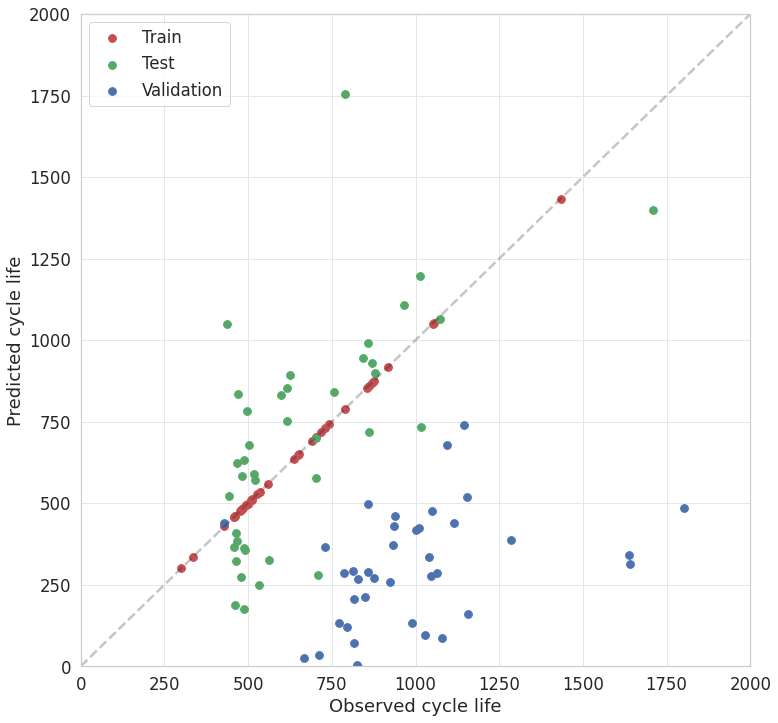

In [ ]:
# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train_m1, y=y_pred_m1['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test_m1, y=y_pred_m1['Test'], s=60, c='g', label='Test')
ax.scatter(x=validation_m1['cycle_life'], y=y_pred_m1['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.show()

In [ ]:
# # Convert to a DataFrame filling with NaN since the vectors are of different lengths
# y_pred_m1_df = pd.DataFrame.from_dict(y_pred_m1, orient='index').T
# y_pred_m1_df.tail(4)

### **II.** Model informed by Discharge Cycle features up to cycle 300
We will repeat the process above, this time including more cycles in the analysis

#### Features data preparation

In [ ]:
## RAW Data
# Define a list of the cycles to extract
target_cycles = range(0,300) # the first 300 cycles

# Initiate a DataFrame in which to store them
QD_cycles = pd.DataFrame(columns=['QD_cycle_'+str(cn) for cn in target_cycles])

# For target cycle each, generate a list of the target parameter at that cycle for all of the cells and store it in the dataframe 
for cycle_no in target_cycles:
  QD_cycles['QD_cycle_'+str(cycle_no)] = [bat_df_summary.QD.iloc[cell_no][cycle_no] for cell_no in range(0,n)]

## Enriched Data
# Max values
QD_cycles['QD_max'] = QD_cycles.max(axis=1)

# Max values
QD_cycles['QD_max'] = QD_cycles.max(axis=1)
QD_cycles.tail(2)

# Differences between every 10 cycles
QQ_cycles_diffs10 = QD_cycles.diff(axis = 1, periods = 10).dropna(axis=1)
QQ_cycles_diffs10.rename(columns=lambda s: s+'_diffs10', inplace = True)
QQ_cycles_diffs10.tail(2)

# Rates of change (slope) between every 5 cycles
QQ_cycles_slopes5 = QD_cycles.diff(axis = 1, periods = 5).dropna(axis=1)/5
QQ_cycles_slopes5.rename(columns=lambda s: s+'_slopes5', inplace = True)
QQ_cycles_slopes5.tail(2)

### Joining all of the data
data_m2 = pd.concat([QD_cycles, QQ_cycles_diffs10, QQ_cycles_slopes5, analysis_df['cycle_life']], axis=1)
data_m2.tail(4)

QD_cycle_0  QD_cycle_1  ...  QD_max_slopes5  cycle_life
119    1.065713    1.066920  ...        0.001244      1642.0
120    1.069167    1.070185  ...        0.001341      1046.0
121    1.068637    1.069720  ...        0.001282       940.0
122    1.068802    1.069549  ...        0.001205      1801.0

[4 rows x 889 columns]

#### **Data Selection: Test, Train and Validation sets**
Like previously, will hold out batch 3 data entirely as validation, and use a random 50:50
train/test split on batches 1 and 2



In [ ]:
# Define the test-train set as the values from the first two batches
tt_m2 = data_m2.iloc[0  :(n_batch1+n_batch2)]  

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_m2 = data_m2.iloc[(n_batch1+n_batch2) : n]  

# Split the test-train data
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(tt_m2.loc[:, tt_m1.columns != 'cycle_life'],  # our predictors or “attributes” - the end of Discharge Capacity Features
                                                                tt_m2['cycle_life'],                # the value we would like to predict or "labels" - the cycle life values
                                                                test_size=0.50,                     # we want a 50:50 test-train split
                                                                random_state=42)                    # use the same random state to be able to easily replicate results

#### **Training the model and Analyzing results**
We will build a multivariate regression model using all of the features we previously created

In [ ]:
regressor = LinearRegression()            # create linear regression object 
regressor.fit(X_train_m2, y_train_m2)     # fit linear regression using the training


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


**Forecasting** cycle lifes on the three dataset types

In [ ]:
y_pred_m2 = {}          # Create a dictionary in which to store the results
y_pred_m2['Train']      = regressor.predict(X_train_m2)       # Predict the labels on previously seen (witin epoch) training data
y_pred_m2['Test']       = regressor.predict(X_test_m2)        # Predict the labels on previously seen (each epoch) validation data 
y_pred_m2['Validation'] = regressor.predict(validation_m2.loc[:, tt_m2.columns != 'cycle_life']) # Predict the labels on unseen seen validation data

# View a side-by-side data comparsion of the predicted vs observed data
# pd.DataFrame({'Actual': y_train_m2, 'Predicted': y_pred_m2['Train']}).head(10)
pd.DataFrame({'Actual': y_test_m2, 'Predicted': y_pred_m2['Test']}).head(10)
# pd.DataFrame({'Actual': validation_m2['cycle_life'], 'Predicted': y_pred_m2['Validation']}).head(10)

Actual     Predicted
30   703.0    629.968720
0   1852.0  73729.654704
22   842.0    663.289968
31   704.0    692.733944
18  1014.0   1039.241937
28   757.0    866.406933
10   880.0    753.869012
70   463.0    423.145195
4   1709.0   1374.591777
12   862.0    821.627999

**Calculating RMSE** on each of the datasets

In [ ]:
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train_m2, y_pred_m2['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test_m2, y_pred_m2['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation_m2['cycle_life'], y_pred_m2['Validation'])))

Root Mean Squared Error fitting to the Train data:        6.527485990226747e-11
Root Mean Squared Error fitting to the Test data:         11501.157662393354
Root Mean Squared Error fitting to the Validation data:   693.0988384112018


**Visualising the observed and predicted cycle lives for each of the test, train, and validation sets.**

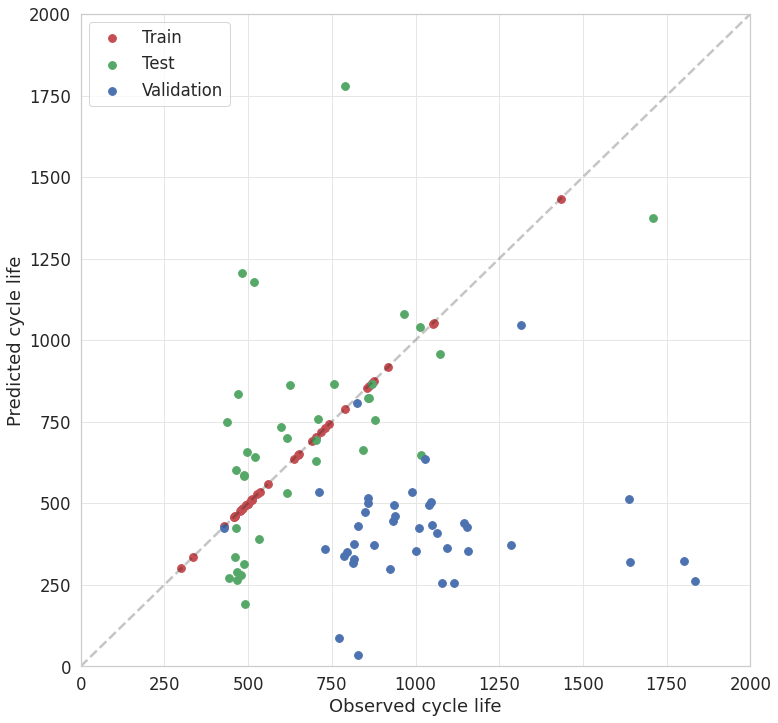

In [ ]:
# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train_m2, y=y_pred_m2['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test_m2, y=y_pred_m2['Test'], s=60, c='g', label='Test')
ax.scatter(x=validation_m2['cycle_life'], y=y_pred_m2['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.show()

### **III.** Conclusions on model performance and model comparison

The two multivariate regression models using the raw and enriched data on discharge cycle variation with cycle number are both performing well at predicting the training dataset. 

Anlyzing the RMSEs and scatter parity plots avoce we can understand the model performance when benchmarked against the test and validation data as well as agaist each other. 

**Models are not generalizable**
They are able to forecast the total cycle life of a cells on which the models ware trained to within 1e-10 RMSE. However, the model performance decreases signifcantly to approximately a RMSE of 1000 cycles for the test dataset. This is an idication that the models are overfitted and do not generalize learning.  

Both models consistently underestimate the cycle life for the third batch, which was a hold-out dataset used for validation as can be seenin both scatter parity plots.  

**More data does not help**
In the firs model RMSEs for train, test and validation data were 8.6-11, 9003.28 and 809.96. In the case of the second model 6.52e-11, 11501.2, 693.1. This indicates there is little improvement between using 300 cycles and 100 cycles. 

Comparing the scatter parity plot leads to the same conclusion, both models are not general and performance does not increase significantly even when providing more data on each cell.

A physics--informed model would likely be generalizable and provide better results. We explore this in the next section.

# Feature Discovery (Physics-informed)
Now, we will attempt to predict cycle life of a battery using features from the discharge capacity variation with voltage. This is a rich physics-informed source of battery degradation information.


## **F.** Evolution of discharge capacity as a function of voltage
We can visualise how the evolution of the predictor variable Discharge Capacity **QD** varies **as a function of voltage** for a sample cell. 

**QD** and **V** values for **one test cell (b1c0)** for cycle 10, 100 and 300:

In [ ]:
cell0_cycle10 = pd.DataFrame.from_dict(batch1_df_cycles['b1c0'][10], orient='index').T
cell0_cycle100 = pd.DataFrame.from_dict(batch1_df_cycles['b1c0'][100], orient='index').T
cell0_cycle300 = pd.DataFrame.from_dict(batch1_df_cycles['b1c0'][300], orient='index').T
cell0_cycle10.tail(4)

I        Qc        Qd  Qdlin  ...  Tdlin         V  dQdV          t
1129 -0.027667  1.074645  1.074781    NaN  ...    NaN  1.999939   NaN  54.356765
1130 -0.027667  1.074645  1.074781    NaN  ...    NaN  2.001736   NaN  54.357867
1131 -0.027667  1.074645  1.074781    NaN  ...    NaN  2.011753   NaN  54.366173
1132  0.000000  1.074645  1.074781    NaN  ...    NaN  2.020870   NaN  54.374552

[4 rows x 9 columns]

**Plot of discharge capacity as a function of voltage for a sample cell for
cycle 10, 100, and 300**

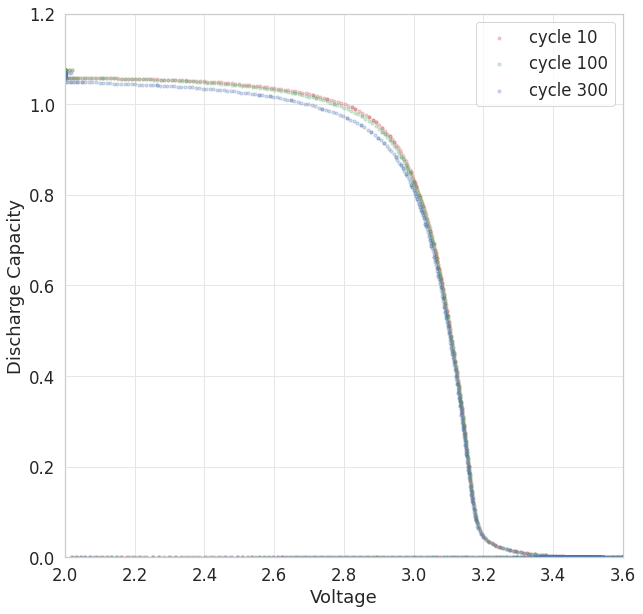

In [ ]:
# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(y=cell0_cycle10['Qd'], x=cell0_cycle10['V'], s=10, c='r', label='cycle 10', alpha=0.25)
ax.scatter(y=cell0_cycle100['Qd'], x=cell0_cycle100['V'], s=10, c='g', label='cycle 100', alpha=0.25)
ax.scatter(y=cell0_cycle300['Qd'], x=cell0_cycle300['V'], s=10, c='b', label='cycle 300', alpha=0.25)
           
plt.ylim(0,1.2)
ax.set_ylabel('Discharge Capacity')
plt.xlim(2,3.6)
ax.set_xlabel('Voltage')
plt.legend()
plt.show()

## **G.** Discharge Capacity Curve Delta
To evaluate the potential use of this data in forecasting cycle life, we will evaluate the differences between the curves at cycle 10 and cycle 100 and how these vary with cycle life of the cells. 

**QD** Delta and **V** values for **one test cell (b1c0)** between cycles 100 and 10:

In [ ]:
# Extract the cycle life of this cell
cycle_lifes.iloc[0]

cycle_life    1852.0
Name: 0, dtype: float64

In [ ]:
# Create a dataframe for the cycles component of the dictionary
bat_df_cycles = pd.DataFrame.from_dict(dict(bat_dict_df.cycles), orient='columns')

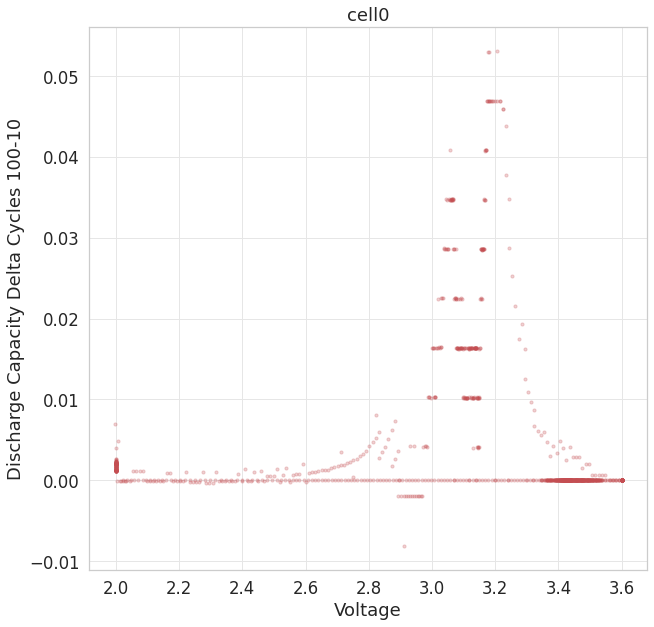

In [ ]:
# Extract the cell cycles properties for cell 0 and cycles 100 and 10
cell0_cycle100 = pd.DataFrame.from_dict(bat_df_cycles['b1c0'][100], orient='index').T
cell0_cycle10 = pd.DataFrame.from_dict(bat_df_cycles['b1c0'][10], orient='index').T

# Calculate the delta of this cell between the two two cell discharge capacities
divergence_vector = cell0_cycle100['Qd'] - cell0_cycle10['Qd']

# Visualise the results
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(y=divergence_vector, x=cell0_cycle10['V'], s=10, c='r', label='cycle 10', alpha=0.25)
ax.set_ylabel('Discharge Capacity Delta Cycles 100-10')
ax.set_xlabel('Voltage')
plt.title('cell0')
plt.show()

**Let's now repeat the process for all other cells**

In [ ]:
# Initiate a dataFrame in which to store all the delta vectors between cells
delta_df = pd.DataFrame()
# cell_QD_cycle2 = pd.DataFrame()

# Add the voltage vector
delta_df['V']=cell0_cycle10['V']

for cell_name in bat_dict.keys():
  # Extract the cell cycles properties between cycles 100 and 10
  cell_temp_cycle100 = pd.DataFrame.from_dict(bat_df_cycles[cell_name][100], orient='index').T
  cell_temp_cycle10 = pd.DataFrame.from_dict(bat_df_cycles[cell_name][10], orient='index').T
  
  # # This parameter will be later used in section J.II.
  # cell_temp_cycle2 = pd.DataFrame.from_dict(bat_df_cycles[cell_name][10], orient='index').T
  # cell_QD_cycle2['QD_cycle2_' + cell_name] = cell_temp_cycle2['Qd']

  # Calculate the delta of this cell between the two two cell discharge capacities
  divergence_vector = (cell_temp_cycle100['Qd'] - cell_temp_cycle10['Qd'])

  # Store this vector into a DataFrame
  delta_df['QD_delta_' + cell_name] = divergence_vector

# Output the results
delta_df.sample(200)

V  QD_delta_b1c0  ...  QD_delta_b3c44  QD_delta_b3c45
75    2.946693   0.000000e+00  ...   -1.198474e-07        0.000000
320   3.527651   0.000000e+00  ...   -1.198474e-07        0.000000
1085  2.000162   1.695200e-03  ...             NaN             NaN
769   3.148139   1.026377e-02  ...             NaN             NaN
865   3.069595   2.860772e-02  ...             NaN             NaN
...        ...            ...  ...             ...             ...
770   3.147130   4.084910e-03  ...             NaN             NaN
679   3.600164   4.202200e-06  ...   -2.064000e-03       -0.000852
86    3.057814   0.000000e+00  ...   -1.198474e-07        0.000000
483   3.525764  -2.681180e-08  ...    7.906303e-02        0.077619
947   2.791683   3.607100e-03  ...             NaN             NaN

[200 rows x 124 columns]

In [ ]:
# Add the cycle life vector
# delta_df['cycle_lifes']=cycle_lifes

**Evolution of Discharge Curves Delta Vectors (between cycles 100 & 10) with Voltage, colour coding indicates Cycle Life**

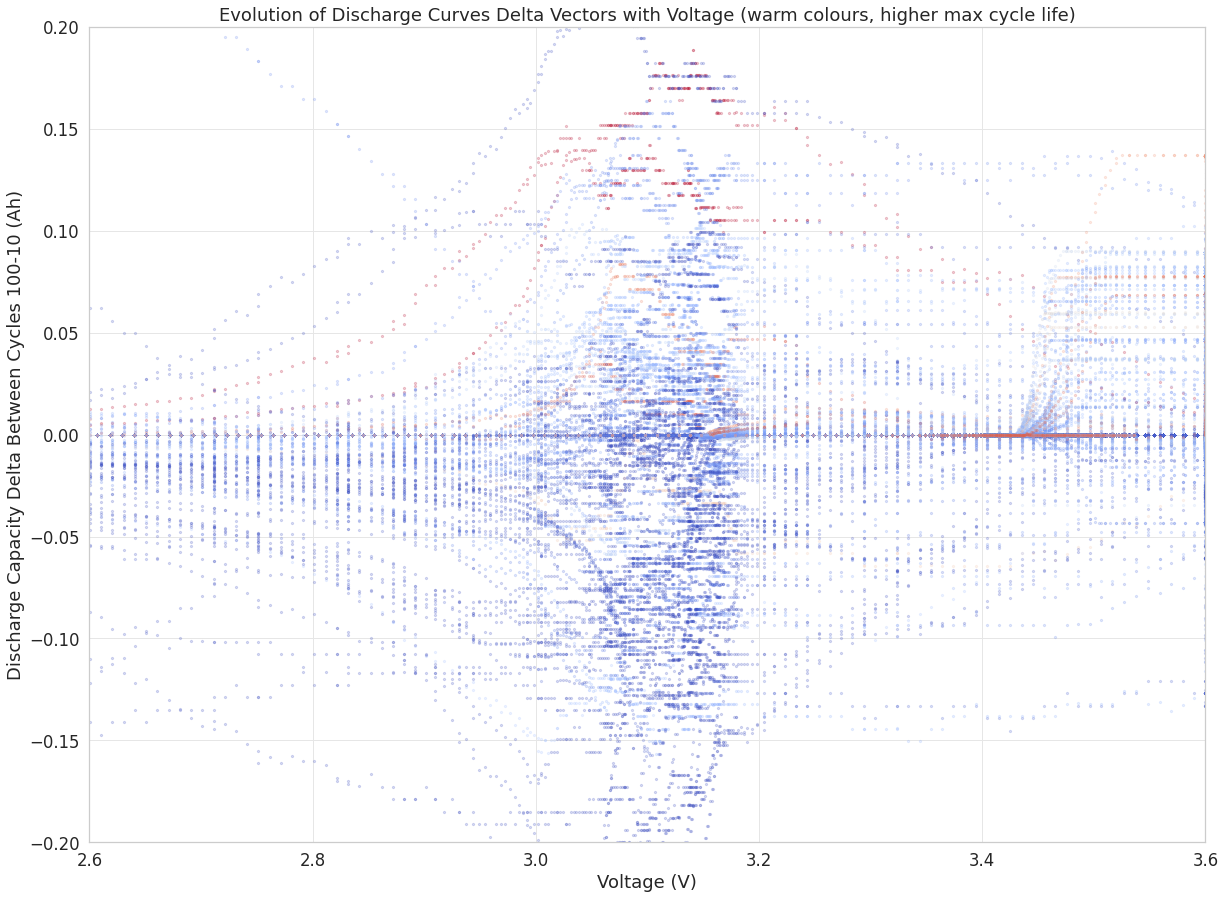

In [ ]:
# Define a coulour map that various from cold to warm with cycle_life
cmap = plt.cm.coolwarm
norm = plt.Normalize(vmin=500, vmax=2000)
c = cmap(norm(cycle_lifes))

f, ax = plt.subplots(figsize=(20,15))
for column_no in range(1,len(delta_df.keys())): # starting from 1 since the first column is V
  cell_index = column_no -1
  ax.scatter(y=delta_df.iloc[:,column_no], # plot the difference between discharge curves
             x=delta_df['V'],              # against voltage
             s=5, 
             c=c[cell_index],
             label='cell' + str(cell_index-1), 
             alpha=0.2)

plt.ylim(-0.2,0.2)
ax.set_ylabel('Discharge Capacity Delta Between Cycles 100-10 (Ah)')
plt.xlim(2.6,3.6)
ax.set_xlabel('Voltage (V)')

plt.title('Evolution of Discharge Curves Delta Vectors with Voltage (warm colours, higher max cycle life)')
plt.show()

These results are a promising confimation that discharge curve variation is an indication of max cycle life

## **H.** Log Transformed Variance of QC Delta against max Cycle Life
We can evaluate this further by looking at how the variance of these vectors evolves with the cycle life on a logaritmic plot


In [ ]:
# Keep only the delta vectors
delta_df.drop(columns='V', inplace=True)

import numpy as np
# Calculate the variance across these vectors then log-transform and store this
log_delta_var = np.log(delta_df.var(axis=0).dropna())
log_cycle_lifes = np.log(cycle_lifes)

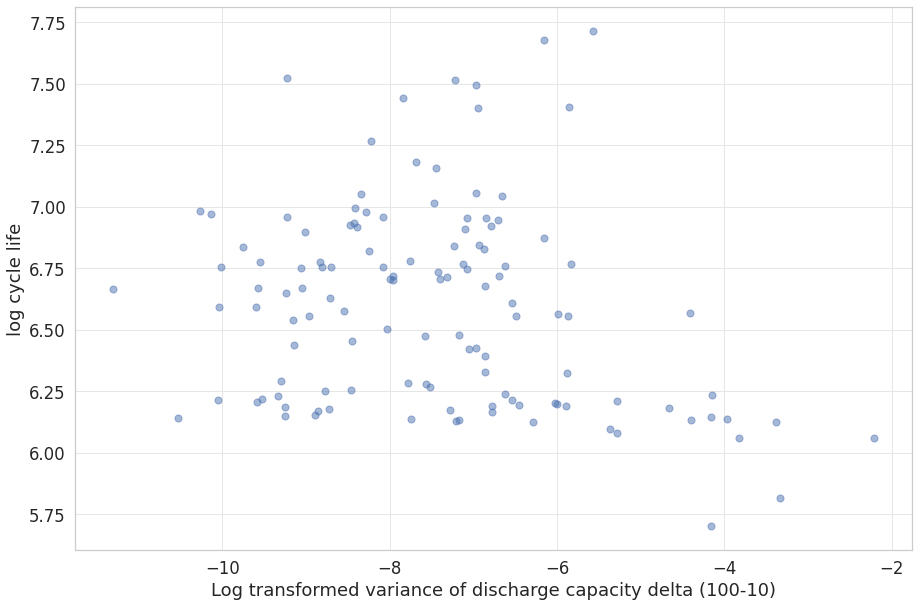

In [ ]:
# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(15,10))
ax.scatter(x=log_delta_var, y=log_cycle_lifes, s=50, c='b', alpha=0.5)
ax.set_xlabel('Log transformed variance of discharge capacity delta (100-10)')
ax.set_ylabel('log cycle life')
plt.show()

In [ ]:
# Join in a DataFrame with cycle life to evaluate their correlation
log_qc_cl = pd.DataFrame()
log_qc_cl['log_delta_var'] = log_delta_var
log_qc_cl['log_cycle_lifes'] = log_cycle_lifes.values
log_qc_cl.corr()

log_delta_var  log_cycle_lifes
log_delta_var         1.000000        -0.243321
log_cycle_lifes      -0.243321         1.000000

The two are negatively correlated with a Pearson Coefficient of -0.293822

## **I.** Evaluating summary statistics of these discharge curves



In [ ]:
delta_df.describe()

QD_delta_b1c0  QD_delta_b1c1  ...  QD_delta_b3c44  QD_delta_b3c45
count   1.127000e+03   1.089000e+03  ...    7.590000e+02      761.000000
mean    4.394917e-03   2.519663e-02  ...    1.748228e-02        0.017301
std     9.943185e-03   4.596534e-02  ...    3.127217e-02        0.030710
min    -8.090680e-03  -1.031557e-09  ...   -2.480200e-03       -0.002270
25%    -2.492777e-08  -6.297428e-10  ...   -1.198474e-07        0.000000
50%     0.000000e+00   0.000000e+00  ...   -1.198474e-07        0.000000
75%     1.998100e-03   1.282210e-02  ...    1.131495e-02        0.010675
max     5.306122e-02   1.419582e-01  ...    7.929915e-02        0.077889

[8 rows x 123 columns]

Text(0.5, 1.0, 'minimum')

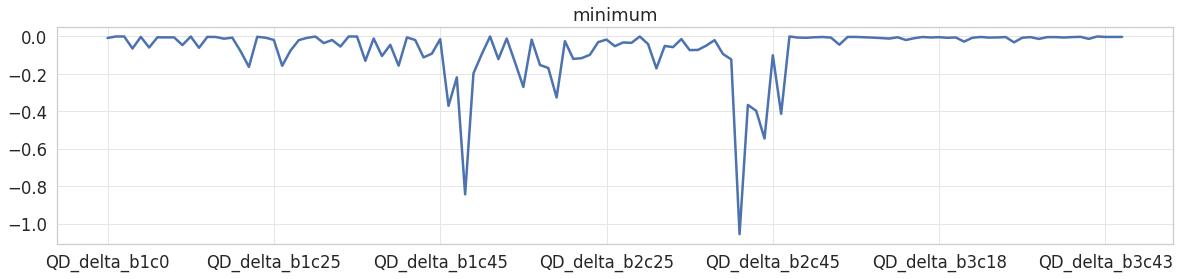

In [ ]:
plt.subplots(figsize=(20,4))
min_vector = delta_df.min()
delta_df.min().plot()
plt.title('minimum')

Text(0.5, 1.0, 'variance')

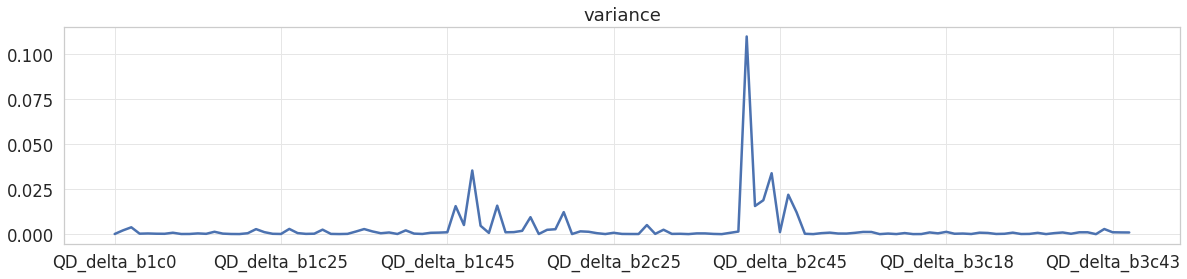

In [ ]:
plt.subplots(figsize=(20,4))
var_vector = delta_df.var()
delta_df.var().plot()
plt.title('variance')

Text(0.5, 1.0, 'skewness')

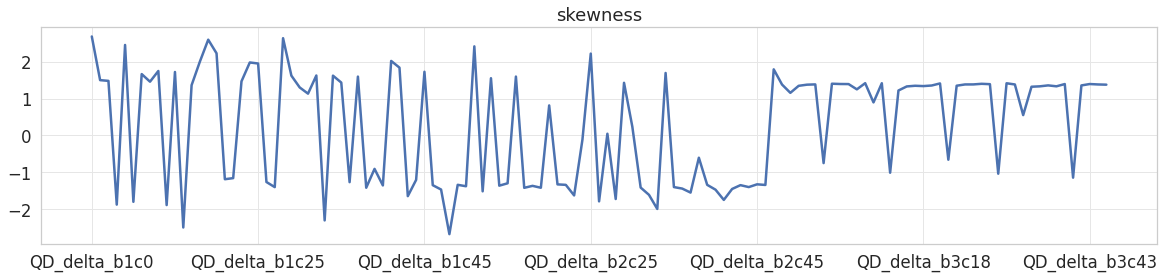

In [ ]:
plt.subplots(figsize=(20,4))
skew_vector = delta_df.skew()
delta_df.skew().plot()
plt.title('skewness')

Text(0.5, 1.0, 'kurtosis')

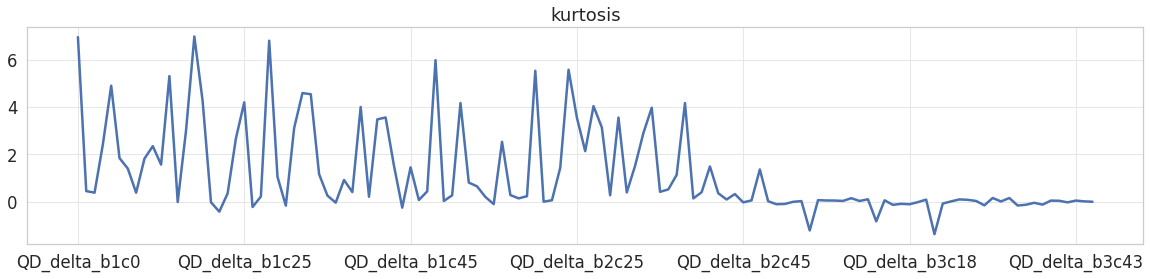

In [ ]:
plt.subplots(figsize=(20,4))
kurtosis_vector = delta_df.kurtosis()
delta_df.kurtosis().plot()
plt.title('kurtosis')

## **J.** Physics-Informed Multivariate Regression Model Implementation

Using the same test/train/validation split as previously we will build two physics informed models and compare performance.


### **I.** Model informed by discharge capacity delta vector variation



#### **Features data preparation**

The features  we will use in the first physics-informed model are just the variances of the "100-10 difference vector" alone: **var_vector**

In [ ]:
data_pm1 = pd.DataFrame(var_vector, columns=['var'])
data_pm1['cycle_life'] = cycle_lifes.values

#### **Data Selection: Test, Train and Validation sets**
Like previously, will hold out batch 3 data entirely as validation, and use a random 50:50
train/test split on batches 1 and 2


In [ ]:
# Define the test-train set as the values from the first two batches
tt_pm1 = data_pm1.iloc[0 :(n_batch1+n_batch2)]  

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_pm1 = data_pm1.iloc[(n_batch1+n_batch2) : n]  

In [ ]:
# Split the test-train data
X_train_pm1, X_test_pm1, y_train_pm1, y_test_pm1 = train_test_split(tt_pm1.loc[:, tt_pm1.columns != 'cycle_life'],  # our predictors or “attributes” - the end of Discharge Capacity Features
                                                                tt_pm1['cycle_life'],                # the value we would like to predict or "labels" - the cycle life values
                                                                test_size=0.50,                     # we want a 50:50 test-train split
                                                                random_state=42)                    # use the same random state to be able to easily replicate results

#### **Training the model and Analyzing results**
We will build a multivariate regression model using all of the features we previously created

In [ ]:
regressor = LinearRegression()            # create linear regression object 
regressor.fit(X_train_pm1, y_train_pm1)     # fit linear regression using the training

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Forecasting** cycle lifes on the three dataset types

In [ ]:
y_pred_pm1 = {}          # Create a dictionary in which to store the results
y_pred_pm1['Train']      = regressor.predict(X_train_pm1)       # Predict the labels on previously seen (witin epoch) training data
y_pred_pm1['Test']       = regressor.predict(X_test_pm1)        # Predict the labels on previously seen (each epoch) validation data 
y_pred_pm1['Validation'] = regressor.predict(validation_pm1.loc[:, tt_pm1.columns != 'cycle_life']) # Predict the labels on unseen seen validation data

# View a side-by-side data comparsion of the predicted vs observed data
# pd.DataFrame({'Actual': y_train_pm1, 'Predicted': y_pred_pm1['Train']}).head(10)
pd.DataFrame({'Actual': y_test_pm1, 'Predicted': y_pred_pm1['Test']}).head(10)
# pd.DataFrame({'Actual': validation_pm1['cycle_life'], 'Predicted': y_pred_pm1['Validation']}).head(10)

Actual   Predicted
QD_delta_b1c35   703.0  730.335564
QD_delta_b1c0   1852.0  742.463906
QD_delta_b1c27   842.0  740.248043
QD_delta_b1c36   704.0  736.147221
QD_delta_b1c23  1014.0  737.912256
QD_delta_b1c33   757.0  742.168659
QD_delta_b1c14   880.0  741.008543
QD_delta_b2c35   463.0  740.991237
QD_delta_b1c4   1709.0  741.158540
QD_delta_b1c16   862.0  736.976893

**Calculating RMSE** on each of the datasets

In [ ]:
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train_pm1, y_pred_pm1['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test_pm1, y_pred_pm1['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation_pm1['cycle_life'], y_pred_pm1['Validation'])))

Root Mean Squared Error fitting to the Train data:        397.4999558477586
Root Mean Squared Error fitting to the Test data:         308.2664596409799
Root Mean Squared Error fitting to the Validation data:   393.30703303421853


**Visualising the observed and predicted cycle lives for each of the test, train, and validation sets.**

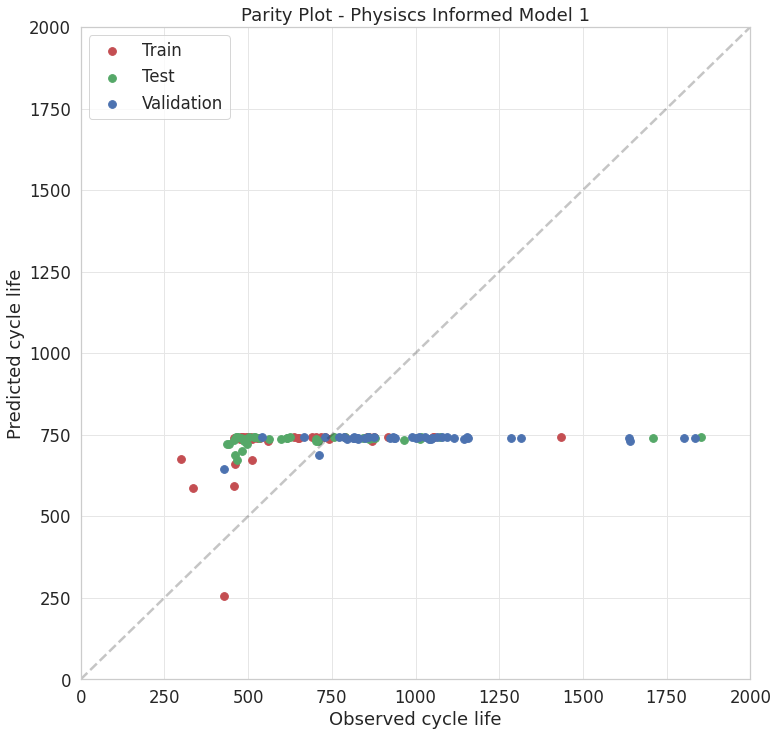

In [ ]:
# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train_pm1, y=y_pred_pm1['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test_pm1, y=y_pred_pm1['Test'], s=60, c='g', label='Test')
ax.scatter(x=validation_pm1['cycle_life'], y=y_pred_pm1['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model 1')
plt.show()

**Observations**
Although the results of this model are initially promising with relatively low RMSE and consistent among test/train/validation (indicating generalizability), when looking at the parity plots  we observe that the model simply predicts cycle lifes around 750 in general. 


### **II.** Model informed by discharge capacity delta vector variation

#### **Features data preparation**

The features  we will use in the second physics-informed model are the following:
-  summary statistics of the QD "100-10 difference vector" 
 - minimum
 - variance
 - skewness
 - kurtosis
- discharge capacity at cycle 2
- the difference between maximum discharge capacity per cell and that at cycle 2


In [ ]:
# summary statistics of "100-10 difference vector" 
data_pm2 = pd.DataFrame(min_vector, columns=['min'])
data_pm2['cycle_life'] = cycle_lifes.values
data_pm2['var'] = var_vector
data_pm2['skew'] = skew_vector
data_pm2['kurtosis'] = kurtosis_vector

# discharge capacity at cycle 2 for all cells
data_pm2['QD_cycle2'] = [bat_df_summary.QC.iloc[c][2] for c in range(0,len(bat_df_summary.QC))] 

# difference between discharge capacity at cycle 2 and the max dischage capacity for all cells
max_temp_vector = [max(bat_df_summary.QC.iloc[c]) for c in range(0,len(bat_df_summary.QC))]   # max dischage capacity for all cells
data_pm2['QD_delta_c2-max'] =[max_temp_vector[c] - bat_df_summary.QC.iloc[c][2] for c in range(0,len(bat_df_summary.QC))] 

In [ ]:
data_pm2

min  cycle_life  ...  QD_cycle2  QD_delta_c2-max
QD_delta_b1c0  -8.090680e-03      1852.0  ...   1.071674         0.475118
QD_delta_b1c1  -1.031557e-09      2160.0  ...   1.076450         0.016354
QD_delta_b1c2   0.000000e+00      2237.0  ...   1.081137         0.016737
QD_delta_b1c3  -6.425582e-02      1434.0  ...   1.080695         0.005188
QD_delta_b1c4  -2.141208e-03      1709.0  ...   1.078936         0.005279
...                      ...         ...  ...        ...              ...
QD_delta_b3c41 -1.274639e-02       786.0  ...   1.050705         0.003817
QD_delta_b3c42 -3.453726e-07      1642.0  ...   1.067469         0.002518
QD_delta_b3c43 -2.561200e-03      1046.0  ...   1.070369         0.002783
QD_delta_b3c44 -2.480200e-03       940.0  ...   1.069880         0.003757
QD_delta_b3c45 -2.269600e-03      1801.0  ...   1.069926         0.002069

[123 rows x 7 columns]

#### **Data Selection: Test, Train and Validation sets**
Like previously, will hold out batch 3 data entirely as validation, and use a random 50:50
train/test split on batches 1 and 2


In [ ]:
# Define the test-train set as the values from the first two batches
tt_pm2 = data_pm2.iloc[0 :(n_batch1+n_batch2)]  

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_pm2 = data_pm2.iloc[(n_batch1+n_batch2) : n]  

# Split the test-train data
X_train_pm2, X_test_pm2, y_train_pm2, y_test_pm2 = train_test_split(tt_pm2.loc[:, tt_pm2.columns != 'cycle_life'],  # our predictors or “attributes” - the end of Discharge Capacity Features
                                                                tt_pm2['cycle_life'],                # the value we would like to predict or "labels" - the cycle life values
                                                                test_size=0.50,                     # we want a 50:50 test-train split
                                                                random_state=42)                    # use the same random state to be able to easily replicate results

#### **Training the model and Analyzing results**
We will build a multivariate regression model using all of the features we previously created

In [ ]:
regressor = LinearRegression()              # create linear regression object 
regressor.fit(X_train_pm2, y_train_pm2)     # fit linear regression using the training

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Forecasting** cycle lifes on the three dataset types

In [ ]:
y_pred_pm2 = {}          # Create a dictionary in which to store the results
y_pred_pm2['Train']      = regressor.predict(X_train_pm2)       # Predict the labels on previously seen (witin epoch) training data
y_pred_pm2['Test']       = regressor.predict(X_test_pm2)        # Predict the labels on previously seen (each epoch) validation data 
y_pred_pm2['Validation'] = regressor.predict(validation_pm2.loc[:, tt_pm2.columns != 'cycle_life']) # Predict the labels on unseen seen validation data

# View a side-by-side data comparsion of the predicted vs observed data
# pd.DataFrame({'Actual': y_train_pm2, 'Predicted': y_pred_pm2['Train']}).head(10)
pd.DataFrame({'Actual': y_test_pm2, 'Predicted': y_pred_pm2['Test']}).head(10)
# pd.DataFrame({'Actual': validation_pm2['cycle_life'], 'Predicted': y_pred_pm2['Validation']}).head(10)

Actual   Predicted
QD_delta_b1c35   703.0  799.222685
QD_delta_b1c0   1852.0  708.729118
QD_delta_b1c27   842.0  773.175473
QD_delta_b1c36   704.0  715.243867
QD_delta_b1c23  1014.0  918.001972
QD_delta_b1c33   757.0  904.500642
QD_delta_b1c14   880.0  752.945488
QD_delta_b2c35   463.0  600.662726
QD_delta_b1c4   1709.0  833.225648
QD_delta_b1c16   862.0  939.054132

**Calculating RMSE** on each of the datasets

In [ ]:
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train_pm2, y_pred_pm2['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test_pm2, y_pred_pm2['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation_pm2['cycle_life'], y_pred_pm2['Validation'])))

Root Mean Squared Error fitting to the Train data:        357.93359589448926
Root Mean Squared Error fitting to the Test data:         300.7231987064868
Root Mean Squared Error fitting to the Validation data:   451.35519601770164


**Visualising the observed and predicted cycle lives for each of the test, train, and validation sets.**

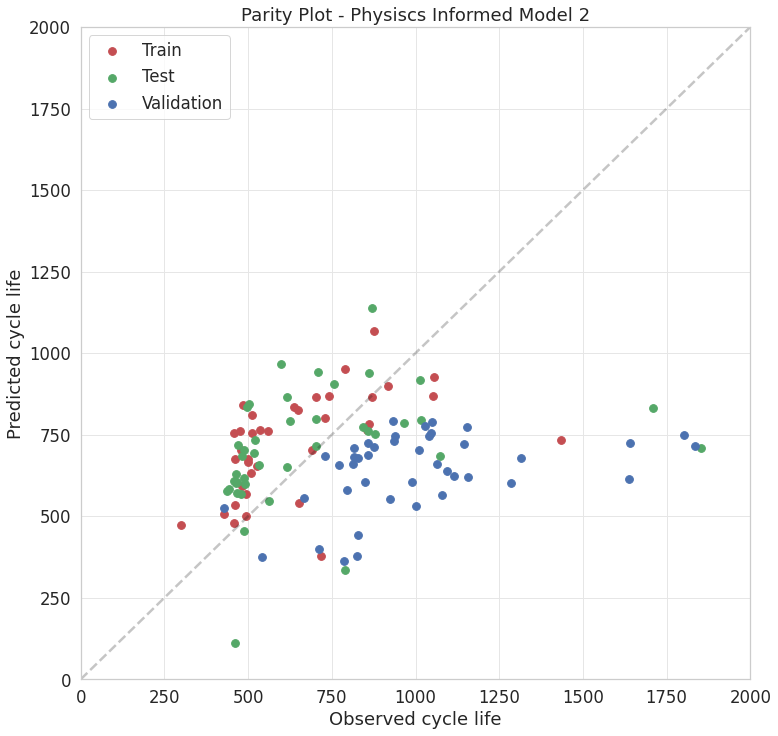

In [ ]:
# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train_pm2, y=y_pred_pm2['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test_pm2, y=y_pred_pm2['Test'], s=60, c='g', label='Test')
ax.scatter(x=validation_pm2['cycle_life'], y=y_pred_pm2['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model 2')
plt.show()

The new physics informed-model performs much better compared to all previous models. Whilst keeping to a similar RMSE values as model pm1, it is generalizable. 

There is still plenty of room for improvement in model accuracy. It is also bias to under estimate cycle life for the validation set.

## **K.** Explanation on Model selection Criteria

In our case, generazibility of the model is a more relevant assessment criteria than log-likelyhood penalized by model complexity (e.g. AIC or BIC). This is the reason why we are comparing the models on three datasets train/test/validation via RMSE and parity plots. 

The AIC and BIC criteria are not measures of forecast accuracy. Although they have a cross-validation property, comparing AIC values across data sets is essentially meaningless. In order to also assess generazibility we do need to make this cross-set comparison. Hence we cannot use AIC or BIC for this purpose.

AIC and BIC are relevant when comparing various models on the same validation dataset. For example we might want to use AIC when we elliminate one of the features above in the training i.e. when pruning the model. This, in order to see if the decrease in model complexity is sufficient to justify the inherent decrease in forecasing performance (log-likelyhood).


## **L.** Regression Machine Learning Model - further refinement and training

In this section we will build upon the previous model, adding additional  predictor variables such as internal resistance, as we established in the first sections of this work (see Section B). Our goal is to build the best, general model for predicting
overall cycle life using data from the first 100 cycles.

#### **Features data preparation**

The features  we will use in this final physics-informed model are the following:

-  all the features from model 2
- internal resistance **IR**
 - minimum
 - differences between every 5 cycles



**IR Data**


In [ ]:
## RAW Data
# Define a list of the cycles to extract
target_cycles = range(0,100) # the first 100 cycles

# Initiate a DataFrame in which to store them
IR_cycles = pd.DataFrame(columns=['IR_cycle_'+str(cn) for cn in target_cycles])

# For target cycle each, generate a list of the target parameter at that cycle for all of the cells and store it in the dataframe 
for cycle_no in target_cycles:
  IR_cycles['IR_cycle_'+str(cycle_no)] = [bat_df_summary.IR.iloc[cell_no][cycle_no] for cell_no in range(0,n)]

# Rename the index to specify cell and battery name (useful when merging the data later on)
IR_cycles.rename(index={IR_cycles.index.values[i] : bat_df.index.values[i] for i in range(0,len(IR_cycles.index.values))}, errors="raise", inplace=True) # rename the index with the cell names

IR_cycles.tail(4)

IR_cycle_0  IR_cycle_1  ...  IR_cycle_98  IR_cycle_99
b3c42    0.016429    0.016377  ...     0.015836     0.015815
b3c43    0.016046    0.015844  ...     0.015658     0.015699
b3c44    0.015744    0.015723  ...     0.015616     0.015617
b3c45    0.015778    0.015742  ...     0.015659     0.015662

[4 rows x 100 columns]

In [ ]:
## Enriched Data
# Min values
IR_cycles['IR_min'] = IR_cycles.min(axis=1)

# Differences between every 10 cycles
IR_cycles_diffs10 = IR_cycles.diff(axis = 1, periods = 10).dropna(axis=1)
IR_cycles_diffs10.rename(columns=lambda s: s+'_diffs10', inplace = True)
IR_cycles_diffs10.tail(2)

# Rates of change (slope) between every 5 cycles
IR_cycles_slopes5 = IR_cycles.diff(axis = 1, periods = 5).dropna(axis=1)/5
IR_cycles_slopes5.rename(columns=lambda s: s+'_slopes5', inplace = True)
IR_cycles_slopes5

IR_cycle_5_slopes5  ...  IR_min_slopes5
b1c0             0.003325  ...       -0.003338
b1c1             0.003372  ...       -0.003386
b1c2             0.003333  ...       -0.003353
b1c3             0.003258  ...       -0.003280
b1c4             0.003337  ...       -0.003348
...                   ...  ...             ...
b3c41           -0.000024  ...       -0.000271
b3c42           -0.000021  ...       -0.000010
b3c43           -0.000055  ...       -0.000017
b3c44           -0.000024  ...       -0.000020
b3c45           -0.000021  ...       -0.000021

[123 rows x 96 columns]

**Chargetime Data**

In [ ]:
## RAW Data
# Define a list of the cycles to extract
target_cycles = range(0,100) # the first 100 cycles

# Initiate a DataFrame in which to store them
chargetime_cycles = pd.DataFrame(columns=['chargetime_cycle_'+str(cn) for cn in target_cycles])

# For target cycle each, generate a list of the target parameter at that cycle for all of the cells and store it in the dataframe 
for cycle_no in target_cycles:
  chargetime_cycles['chargetime_cycle_'+str(cycle_no)] = [bat_df_summary.chargetime.iloc[cell_no][cycle_no] for cell_no in range(0,n)]

# Rename the index to specify cell and battery name (useful when merging the data later on)
chargetime_cycles.rename(index={chargetime_cycles.index.values[i] : bat_df.index.values[i] for i in range(0,len(chargetime_cycles.index.values))}, errors="raise", inplace=True) # rename the index with the cell names

chargetime_cycles.tail(4)

## Enriched Data
# Min values
chargetime_cycles['chargetime_min'] = chargetime_cycles.min(axis=1)

# Differences between every 10 cycles
chargetime_cycles_diffs10 = chargetime_cycles.diff(axis = 1, periods = 10).dropna(axis=1)
chargetime_cycles_diffs10.rename(columns=lambda s: s+'_diffs10', inplace = True)
chargetime_cycles_diffs10.tail(2)

# Rates of change (slope) between every 5 cycles
chargetime_cycles_slopes5 = chargetime_cycles.diff(axis = 1, periods = 5).dropna(axis=1)/5
chargetime_cycles_slopes5.rename(columns=lambda s: s+'_slopes5', inplace = True)
chargetime_cycles_slopes5

chargetime_cycle_5_slopes5  ...  chargetime_min_slopes5
b1c0                     2.668167  ...               -2.685122
b1c1                     2.685250  ...               -2.668257
b1c2                     2.668269  ...               -2.685200
b1c3                     2.418487  ...               -2.418476
b1c4                     2.401612  ...               -2.401631
...                           ...  ...                     ...
b3c41                   -0.000086  ...               -0.000074
b3c42                    0.000312  ...               -0.000530
b3c43                    0.000120  ...               -0.000116
b3c44                   -0.000192  ...               -0.003400
b3c45                   -0.000048  ...               -0.000639

[123 rows x 96 columns]

**All the features from model 3**

In [ ]:
data_pm3 = data_pm2.copy()
data_pm3 = data_pm3.rename(index={data_pm3.index.values[i] : bat_df.index.values[i] for i in range(0,len(data_pm3.index.values))}, errors="raise") # rename the index with the cell names
data_pm3.tail(2)

**Joining all of the data**

In [ ]:
data_pm3 = pd.concat([data_pm3, IR_cycles.IR_min, IR_cycles_diffs10, IR_cycles_slopes5, chargetime_cycles.chargetime_min, chargetime_cycles_diffs10, chargetime_cycles_slopes5], axis=1)
data_pm3.tail(2)

min  cycle_life  ...  chargetime_cycle_99_slopes5  chargetime_min_slopes5
b3c44 -0.00248       940.0  ...                    -0.003424               -0.003400
b3c45 -0.00227      1801.0  ...                    -0.000287               -0.000639

[2 rows x 383 columns]

#### **Data Selection: Test, Train and Validation sets**
Like previously, will hold out batch 3 data entirely as validation, and use a random 50:50
train/test split on batches 1 and 2


In [ ]:
# Define the test-train set as the values from the first two batches
tt_pm3 = data_pm3.iloc[0 :(n_batch1+n_batch2)]  

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_pm3 = data_pm3.iloc[(n_batch1+n_batch2) : n]  

# Split the test-train data
X_train_pm3, X_test_pm3, y_train_pm3, y_test_pm3 = train_test_split(tt_pm3.loc[:, tt_pm3.columns != 'cycle_life'],  # our predictors or “attributes” - the end of Discharge Capacity Features
                                                                tt_pm3['cycle_life'],                # the value we would like to predict or "labels" - the cycle life values
                                                                test_size=0.50,                     # we want a 50:50 test-train split
                                                                random_state=42)                    # use the same random state to be able to easily replicate results

#### **Training the model and Analyzing results**
We will build a multivariate regression model using all of the features we previously created

In [ ]:
regressor = LinearRegression()              # create linear regression object 
regressor.fit(X_train_pm3, y_train_pm3)     # fit linear regression using the training

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Forecasting** cycle lifes on the three dataset types

In [ ]:
y_pred_pm3 = {}          # Create a dictionary in which to store the results
y_pred_pm3['Train']      = regressor.predict(X_train_pm3)       # Predict the labels on previously seen (witin epoch) training data
y_pred_pm3['Test']       = regressor.predict(X_test_pm3)        # Predict the labels on previously seen (each epoch) validation data 
y_pred_pm3['Validation'] = regressor.predict(validation_pm3.loc[:, tt_pm3.columns != 'cycle_life']) # Predict the labels on unseen seen validation data

# View a side-by-side data comparsion of the predicted vs observed data
# pd.DataFrame({'Actual': y_train_pm3, 'Predicted': y_pred_pm3['Train']}).head(10)
pd.DataFrame({'Actual': y_test_pm3, 'Predicted': y_pred_pm3['Test']}).head(10)
# pd.DataFrame({'Actual': validation_pm3['cycle_life'], 'Predicted': y_pred_pm3['Validation']}).head(10)

Actual    Predicted
b1c35   703.0   917.278407
b1c0   1852.0  1500.654792
b1c27   842.0   891.442766
b1c36   704.0   986.085216
b1c23  1014.0  1241.028961
b1c33   757.0   716.812630
b1c14   880.0  1069.707626
b2c35   463.0   379.852291
b1c4   1709.0  1171.552852
b1c16   862.0   504.784976

**Calculating RMSE** on each of the datasets

In [ ]:
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train_pm3, y_pred_pm3['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test_pm3, y_pred_pm3['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation_pm3['cycle_life'], y_pred_pm3['Validation'])))

Root Mean Squared Error fitting to the Train data:        1.9952606826810548e-11
Root Mean Squared Error fitting to the Test data:         246.2816609989712
Root Mean Squared Error fitting to the Validation data:   544.6250874623547


**Visualising the observed and predicted cycle lives for each of the test, train, and validation sets.**

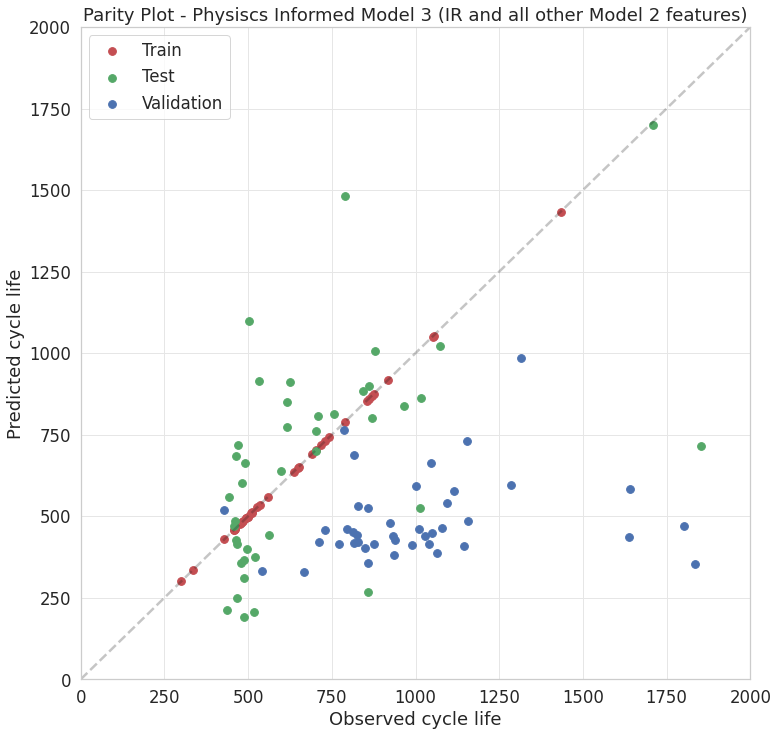

In [ ]:
# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train_pm3, y=y_pred_pm3['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test_pm3, y=y_pred_pm3['Test'], s=60, c='g', label='Test')
ax.scatter(x=validation_pm3['cycle_life'], y=y_pred_pm3['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model 3 (IR, chargetime, and all other Model 2 features)')
plt.show()

The model now achieves a much better fitting to the training data whilst still being generalizable. RMSEs have also improved. The observations made in the earlier sections of this work (particularly Section B) and indeed validated here, as the inclusion of Internal Resistance features has improved the model and resulted fit without losing generalizability.

## **L.1.** Keeping only the IR features
As as exercise in feature relevance, we can elliminate all features but internal resistance to see how this affects the model. Repeating the process above yields the following:

Root Mean Squared Error fitting to the Train data:        1.6735536607220776e-12
Root Mean Squared Error fitting to the Test data:         299.1246516402029
Root Mean Squared Error fitting to the Validation data:   593.9878884604655 



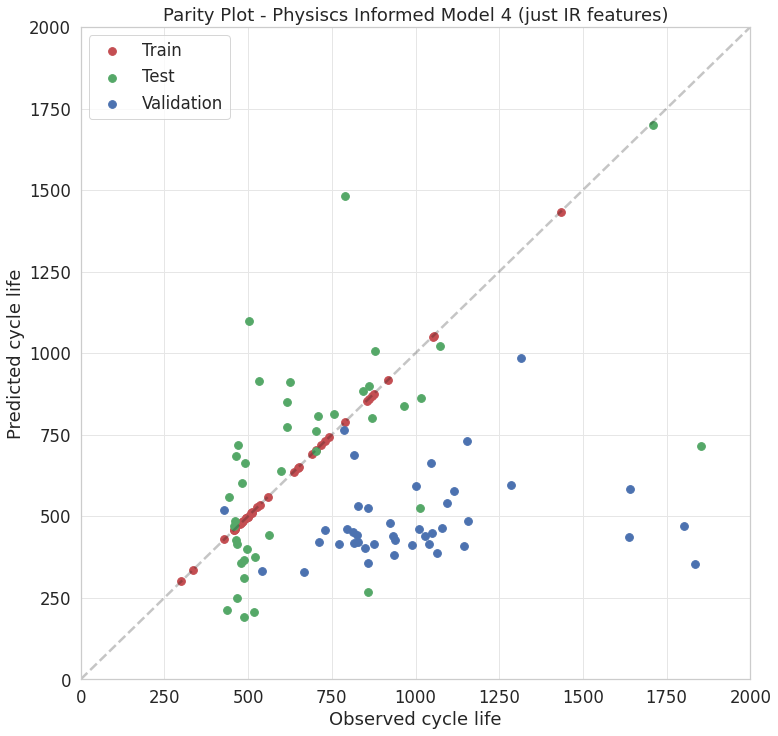

In [ ]:
# Define the test-train set as the values from the first two batches
tt_pm4 = data_pm3.iloc[0 :(n_batch1+n_batch2)]  

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_pm4 = data_pm3.iloc[(n_batch1+n_batch2) : n]  

# Split the test-train data
X_train_pm4, X_test_pm4, y_train_pm4, y_test_pm4 = train_test_split(tt_pm4.loc[:, tt_pm4.columns.str.startswith('IR')],  # our predictors or “attributes” - just IR features
                                                                tt_pm4['cycle_life'],               # the value we would like to predict or "labels" - the cycle life values
                                                                test_size=0.50,                     # we want a 50:50 test-train split
                                                                random_state=42)                    # use the same random state to be able to easily replicate results

regressor = LinearRegression()              # create linear regression object 
regressor.fit(X_train_pm4, y_train_pm4)     # fit linear regression using the training

y_pred_pm4 = {}          # Create a dictionary in which to store the results
y_pred_pm4['Train']      = regressor.predict(X_train_pm4)       # Predict the labels on previously seen (witin epoch) training data
y_pred_pm4['Test']       = regressor.predict(X_test_pm4)        # Predict the labels on previously seen (each epoch) validation data 
y_pred_pm4['Validation'] = regressor.predict(validation_pm4.loc[:, tt_pm4.columns.str.startswith('IR')]) # Predict the labels on unseen seen validation data

import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train_pm4, y_pred_pm4['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test_pm4, y_pred_pm4['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation_pm4['cycle_life'], y_pred_pm4['Validation'])),'\n')

# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train_pm4, y=y_pred_pm4['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test_pm4, y=y_pred_pm4['Test'], s=60, c='g', label='Test')
ax.scatter(x=validation_pm4['cycle_life'], y=y_pred_pm4['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model 4 (just IR features)')
plt.show()

As hypothesized above, the model performs very well using just the IR features, achieving the same RMSEs and very similar predictive performance as per the parity plots. Using the figure below to descibe the models developed so far, this model achieve a relatively low variance and bias compared to all the previous models. It has a bias and higher variance when tested on the bild dataset however. ![bias-variance-image](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/05153246/bias-variance.png)

## **L.2.** Shuffle the test-train-validation and performance comparison with previously published work
In order to evaluate the regression model previous work, we need to split the data using the same train/test split as Severson et. al. [[7]](https://www.nature.com/articles/s41560-019-0356-8). 

This is performed in the following section and the model is retrained using the new data. 

Root Mean Squared Error fitting to the Train data:        4.6621307429691325e-12
Root Mean Squared Error fitting to the Test data:         691.0548934566782
Root Mean Squared Error fitting to the Validation data:   642.0411621034041 



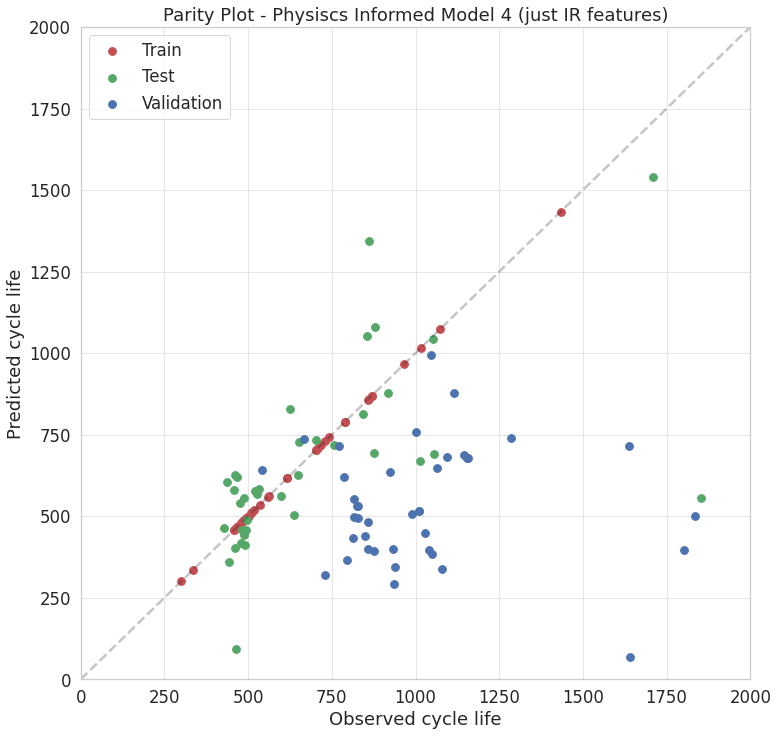

In [ ]:
# Define the test and train cell indices as indicated by the paper authors
test_ind = np.hstack((np.arange(0,(n_batch1+n_batch2),2),83))
train_ind = np.arange(1,(n_batch1+n_batch2-1),2)
validation_ind = np.arange(n-n_batch3,n)

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_pm4 = data_pm3.iloc[validation_ind]  

# Define the test-train main set
X_tt_pm4 = data_pm3.iloc[:, data_pm3.columns.str.startswith('IR')]  # our predictors or “attributes” - just IR features
y_tt_pm4 = data_pm3['cycle_life']                                   # the value we would like to predict or "labels" - the cycle life values

# Split the test-train data
X_train_pm4, y_train_pm4 = X_tt_pm4.iloc[train_ind], y_tt_pm4.iloc[train_ind]
X_test_pm4, y_test_pm4 =  X_tt_pm4.iloc[test_ind], y_tt_pm4.iloc[test_ind]

regressor = LinearRegression()              # create linear regression object 
regressor.fit(X_train_pm4, y_train_pm4)     # fit linear regression using the training

y_pred_pm4 = {}          # Create a dictionary in which to store the results
y_pred_pm4['Train']      = regressor.predict(X_train_pm4)       # Predict the labels on previously seen (witin epoch) training data
y_pred_pm4['Test']       = regressor.predict(X_test_pm4)        # Predict the labels on previously seen (each epoch) validation data 
y_pred_pm4['Validation'] = regressor.predict(validation_pm4.loc[:, tt_pm4.columns.str.startswith('IR')]) # Predict the labels on unseen seen validation data

# Calculate model RMSE (units of cycles)
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train_pm4, y_pred_pm4['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test_pm4, y_pred_pm4['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation_pm4['cycle_life'], y_pred_pm4['Validation'])),'\n')

# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train_pm4, y=y_pred_pm4['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test_pm4, y=y_pred_pm4['Test'], s=60, c='g', label='Test')
ax.scatter(x=validation_pm4['cycle_life'], y=y_pred_pm4['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model 4 (just IR features)')
plt.show()

**Note** that changing the test-train-validation dataset affected the model adversely, almost doubling its RMSE, though it does not affect negatively the bias of the model.

**Calculating the same perfomance metrics used in the paper** (mean percentual error)

In [ ]:
# Obtain a side-by-side data comparsion of the predicted vs observed data
train_forecast = pd.DataFrame({'Actual': y_train_pm4, 'Predicted': y_pred_pm4['Train']}).head(10)
test_forecast = pd.DataFrame({'Actual': y_test_pm4, 'Predicted': y_pred_pm4['Test']}).head(10)
validation_forecast = pd.DataFrame({'Actual': validation_pm4['cycle_life'], 'Predicted': y_pred_pm4['Validation']}).head(10)

# Calculate model Mean Percentage Error
# def mean_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean((y_true - y_pred) / y_true) * 100
    
train_forecast['MPE'] = (train_forecast.Actual - train_forecast.Predicted) / train_forecast.Actual * 100
test_forecast['MPE'] = (test_forecast.Actual - test_forecast.Predicted) / test_forecast.Actual * 100
validation_forecast['MPE'] = (validation_forecast.Actual - validation_forecast.Predicted) / validation_forecast.Actual * 100

# Print the results
print('Mean Percentage Error fitting to the Train data:       ', train_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Test data:        ', test_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Validation data:  ', validation_forecast['MPE'].mean(),'\n')

print('Forecast results for the Test Data')
test_forecast

Mean Percentage Error fitting to the Train data:        1.9295036404475236e-13
Mean Percentage Error fitting to the Test data:         -50.952500704988736
Mean Percentage Error fitting to the Validation data:   44.07640738712441 

Forecast results for the Test Data


Actual    Predicted         MPE
b1c0   1852.0   555.757213   69.991511
b1c2   2237.0  2316.701595   -3.562879
b1c4   1709.0  1540.913372    9.835379
b1c6    636.0   504.588800   20.662138
b1c9   1054.0   691.497335   34.393042
b1c14   880.0  1081.055019  -22.847161
b1c16   862.0  1344.288026  -55.949887
b1c18   691.0  4743.875721 -586.523259
b1c20   534.0   584.365977   -9.431831
b1c23  1014.0   670.173499   33.907939

**Observations**

The results of the best model in previously published work achieved a *9.1% test error for quantitatively predicting cycle life using the first 100
cycles*. The test error we obtained above is only in the best case around 9% (forecast cell b1c4), but on average, percentual error for the forecast is 50% of the cycle life. *We can improve this further by assigning a varrying weight to each of the features based on their predictive power.*

## **L.3.**  Hyperparameter Optimisation - Feature weight selection

Following from the observations above we will use an automated method to compute
Using lasso to elliminate features with lower predictive power automatically
and evaluate performance improvements

## Defining the Test and Train Datasets

In [ ]:
# Define the test and train cell indices as indicated by the paper authors
test_ind = np.hstack((np.arange(0,(n_batch1+n_batch2),2),83))
train_ind = np.arange(1,(n_batch1+n_batch2-1),2)
validation_ind = np.arange(n-n_batch3,n)

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation = data_pm3.iloc[validation_ind]  

# Define the test-train main set
X_tt_pm4_l = data_pm3.iloc[:, data_pm3.columns.str.startswith('IR')]  # our predictors or “attributes” - just IR features
y_tt_pm4_l = data_pm3['cycle_life']                                   # the value we would like to predict or "labels" - the cycle life values

# Split the test-train data
X_train, y_train = X_tt_pm4_l.iloc[train_ind], y_tt_pm4_l.iloc[train_ind]
X_test, y_test =  X_tt_pm4_l.iloc[test_ind], y_tt_pm4_l.iloc[test_ind]

## LASSO Method
Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression [[15]](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b).

LASSO (Least Absolute Srinkage) is an optimisation technique which application of an exponential prior to force predictor variables to turn on or off [[16]](https://www.meche.engineering.cmu.edu/education/courses/24-786.html). 

$$
-\log p(\mathbf{w} | X, \mathbf{y}) \propto \frac{1}{\sigma^2} \sum_j (\mathbf{x}_j \cdot \mathbf{w} - y_j)^2 + \frac{1}{2\sigma^2_w} \sum_j w_j^2
$$

$$
\lambda = \frac{1}{2\sigma^2_w} 
$$

Conditioned on $σ^2$, the prior of each regression coefficient is double exponential with a mean of 0 and scale σ/λ, where λ is the **lasso shrinkage parameter**. As λ increases, the coefficients tend towards 0. This allows lasso regression to turn off coefficients actig towards feature selection whereas Ridge Regression can only shrink coefficients close to zero [[17]](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html#sphx-glr-auto-examples-linear-model-plot-lasso-and-elasticnet-py).

In [ ]:
# Define the LASSO model
alpha = 30  # this is the shrinkage parameter, alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object
lasso = Lasso(alpha=alpha, normalize=True)

# Train and calculate R2 fit
y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=30, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)
r^2 on test data : 0.103114


**Let's see what features LASSO selected**

In [ ]:
np.where(lasso.coef_)[0]                                # Find the index of the features that were selected
X_train.iloc[:,np.where(lasso.coef_)[0]].tail(2).keys() # Find the names of the features that were selected by lasso

Index(['IR_cycle_10_diffs10', 'IR_cycle_21_diffs10'], dtype='object')

Just two predictor variables were chose in this case - fortuantely they are from the first cycles - suggesting we can forecast cycle life using data from just the early cycles.

Setting a high alpha value assings high weight to few variables, setting alpha small assigns the same total weight to more variables. 

Intuitively
- alpha small results a large number of 'small lasso's' allowing a finer selection
- alpha large results a small number of 'large lasso's' allowing a coarse selection of the most important features

**Benchmarking the model using the same tests as previously**

Root Mean Squared Error fitting to the Train data:        295.3548935805674
Root Mean Squared Error fitting to the Test data:         368.6088904218044
Root Mean Squared Error fitting to the Validation data:   285.1112403519019 



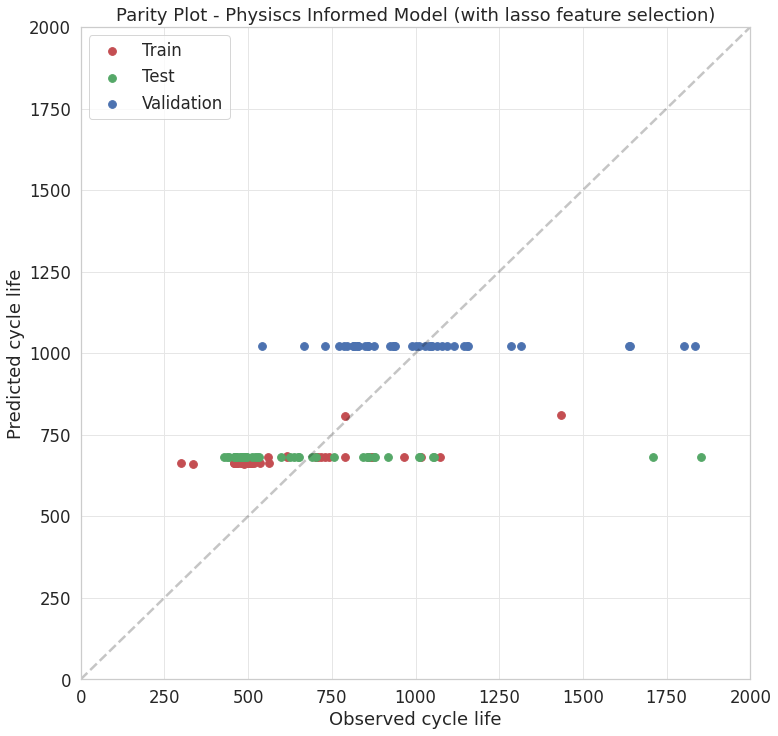

In [ ]:
y_pred = {}          # Create a dictionary in which to store the results
y_pred['Train']      = lasso.fit(X_train, y_train).predict(X_train)       # Predict the labels on previously seen (witin epoch) training data
y_pred['Test']       = lasso.fit(X_train, y_train).predict(X_test)        # Predict the labels on previously seen (each epoch) validation data 

features_selected = X_train.iloc[:,np.where(lasso.coef_)[0]].tail(2).keys() # Find the names of the features that were selected
selection = validation_pm4_l.loc[:, features_selected]                      # Create a subsection of valition with these collumns
selection = selection.loc[:,~selection.columns.duplicated()]                # Drop duplicate collumns

y_pred['Validation'] = lasso.fit(selection, validation['cycle_life']).predict(selection) # Predict the labels on unseen seen validation data

# Calculate model RMSE (units of cycles)
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train, y_pred['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test, y_pred['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation['cycle_life'], y_pred['Validation'])),'\n')

# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train, y=y_pred['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test, y=y_pred_enet, s=60, c='g', label='Test')
ax.scatter(x=validation['cycle_life'], y=y_pred['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model (with lasso feature selection)')
plt.show()

In [ ]:
# Obtain a side-by-side data comparsion of the predicted vs observed data
train_forecast = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred['Train']}).head(10)
test_forecast = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred['Test']}).head(10)
validation_forecast = pd.DataFrame({'Actual': validation['cycle_life'], 'Predicted': y_pred['Validation']}).head(10)
    
train_forecast['MPE'] = ((train_forecast.Actual - train_forecast.Predicted) / train_forecast.Actual) * 100
test_forecast['MPE'] = ((test_forecast.Actual - test_forecast.Predicted) / test_forecast.Actual) * 100
validation_forecast['MPE'] = ((validation_forecast.Actual - validation_forecast.Predicted) / validation_forecast.Actual) * 100

# Print the results
print('Mean Percentage Error fitting to the Train data:       ', train_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Test data:        ', test_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Validation data:  ', validation_forecast['MPE'].mean(),'\n')

print('Forecast results for the Test Data')
test_forecast

Mean Percentage Error fitting to the Train data:        21.096167946142792
Mean Percentage Error fitting to the Test data:         25.71189395194268
Mean Percentage Error fitting to the Validation data:   -3.5450465909738846 

Forecast results for the Test Data


Actual   Predicted        MPE
b1c0   1852.0  663.868644  64.153961
b1c2   2237.0  814.007883  63.611628
b1c4   1709.0  813.567538  52.395112
b1c6    636.0  682.673448  -7.338593
b1c9   1054.0  682.597197  35.237458
b1c14   880.0  682.956561  22.391300
b1c16   862.0  682.798590  20.789027
b1c18   691.0  686.276395   0.683590
b1c20   534.0  680.750742 -27.481412
b1c23  1014.0  682.656541  32.676870

**Observations**

Out of all of the training features lasso selected the top as the first two deltas in internal resistance when taking steps of 10, namely 
'IR_cycle_10_diffs10', 'IR_cycle_21_diffs10'

This indicates these two features would also have among the highest weighting if we decrease alpha and more features are added to the model. 
However, this is very promising, in essence we can forecast the battery life with the accuracy above (within 25% ) using just the fist 20 cycles.




## Elastic-Net Method
Elastic Net first emerged as a result of critique on lasso, whose variable selection can be too dependent on data and thus unstable. The solution is to combine the penalties of ridge regression and lasso to get the best of both worlds. Elastic Net aims at minimizing the following loss function [[18]](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net):

![alt text](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1543418448/eq12_vh6ilt.png)

In [ ]:
enet = ElasticNet(alpha=30, l1_ratio=0.7, normalize=True)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

ElasticNet(alpha=30, copy_X=True, fit_intercept=True, l1_ratio=0.7,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : -0.005227


**Let's see what features Elastic-Net selected**

In [ ]:
np.where(enet.coef_)[0]

array([], dtype=int64)

In [ ]:
# Find the names of the features that were selected by lasso
X_train.iloc[:,np.where(enet.coef_)[0]].tail(2)

IR_min  IR_cycle_10_diffs10  ...  IR_cycle_79_slopes5  IR_min_slopes5
b2c42  0.016998            -0.000228  ...         1.855400e-05       -0.000052
b2c44  0.017409            -0.000213  ...        -5.506000e-07       -0.000090

[2 rows x 27 columns]

**Visualising the features selected by the Elastic-Net, compared to the LASSO**

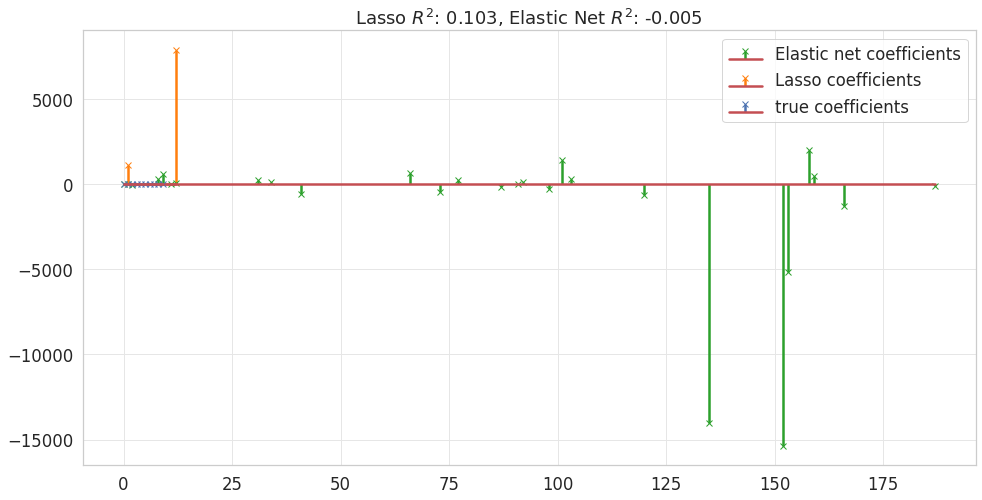

In [ ]:
plt.figure(figsize=(16,8))

m, s, _ = plt.stem(np.where(enet.coef_)[0], enet.coef_[enet.coef_ != 0],
                   markerfmt='x', label='Elastic net coefficients',
                   use_line_collection=True)
plt.setp([m, s], color="#2ca02c")
m, s, _ = plt.stem(np.where(lasso.coef_)[0], lasso.coef_[lasso.coef_ != 0],
                   markerfmt='x', label='Lasso coefficients',
                   use_line_collection=True)
plt.setp([m, s], color='#ff7f0e')
plt.stem(np.where(coef)[0], coef[coef != 0], label='true coefficients',
         markerfmt='bx', use_line_collection=True)

plt.legend(loc='best')
plt.title("Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f"
          % (r2_score_lasso, r2_score_enet))
# plt.ylim(0,10)
plt.show()

We can see the elastic mode aand the LASSo model assing different weight to features. The Elastic model selects many more features. The features chosen are a superset of those chosen by the LASSO method. 

Root Mean Squared Error fitting to the Train data:        322.3102886970793
Root Mean Squared Error fitting to the Test data:         390.2378472088312
Root Mean Squared Error fitting to the Validation data:   285.1112403519019 



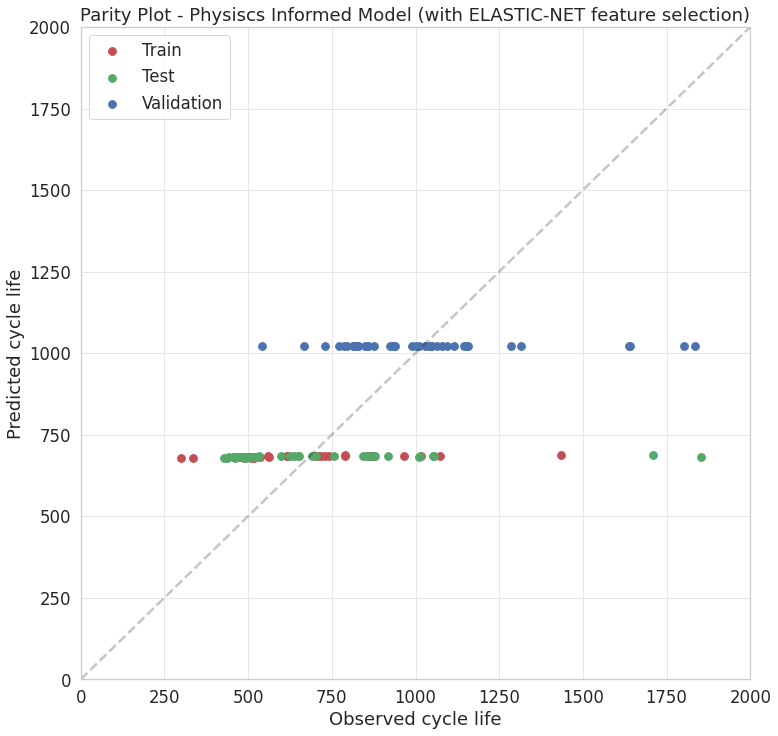

In [ ]:
y_pred = {}          # Create a dictionary in which to store the results
y_pred['Train']      = enet.fit(X_train, y_train).predict(X_train)       # Predict the labels on previously seen (witin epoch) training data
y_pred['Test']       = enet.fit(X_train, y_train).predict(X_test)        # Predict the labels on previously seen (each epoch) validation data 

features_selected = X_train.iloc[:,np.where(enet.coef_)[0]].tail(2).keys() # Find the names of the features that were selected
selection = validation_pm4_l.loc[:, features_selected]                      # Create a subsection of validation with these collumns
selection = selection.loc[:,~selection.columns.duplicated()]                # Drop duplicate collumns

y_pred['Validation'] = enet.fit(selection, validation['cycle_life']).predict(selection) # Predict the labels on unseen seen validation data

# Calculate model RMSE (units of cycles)
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train, y_pred['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test, y_pred['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation['cycle_life'], y_pred['Validation'])),'\n')

# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train, y=y_pred['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test, y=y_pred_enet, s=60, c='g', label='Test')
ax.scatter(x=validation['cycle_life'], y=y_pred['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model (with ELASTIC-NET feature selection)')
plt.show()

In [ ]:
# Obtain a side-by-side data comparsion of the predicted vs observed data
train_forecast = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred['Train']}).head(10)
test_forecast = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred['Test']}).head(10)
validation_forecast = pd.DataFrame({'Actual': validation['cycle_life'], 'Predicted': y_pred['Validation']}).head(10)
    
train_forecast['MPE'] = ((train_forecast.Actual - train_forecast.Predicted) / train_forecast.Actual) * 100
test_forecast['MPE'] = ((test_forecast.Actual - test_forecast.Predicted) / test_forecast.Actual) * 100
validation_forecast['MPE'] = ((validation_forecast.Actual - validation_forecast.Predicted) / validation_forecast.Actual) * 100

# Print the results
print('Mean Percentage Error fitting to the Train data:       ', train_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Test data:        ', test_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Validation data:  ', validation_forecast['MPE'].mean(),'\n')

print('Forecast results for the Test Data')
test_forecast

Mean Percentage Error fitting to the Train data:        23.945073918499162
Mean Percentage Error fitting to the Test data:         26.830224032783587
Mean Percentage Error fitting to the Validation data:   -3.5450465909738846 

Forecast results for the Test Data


Actual   Predicted        MPE
b1c0   1852.0  682.423405  63.152084
b1c2   2237.0  688.518016  69.221367
b1c4   1709.0  688.849301  59.692844
b1c6    636.0  683.566989  -7.479086
b1c9   1054.0  683.548611  35.147191
b1c14   880.0  684.196228  22.250429
b1c16   862.0  683.814499  20.671172
b1c18   691.0  683.762638   1.047375
b1c20   534.0  683.415867 -27.980500
b1c23  1014.0  683.645237  32.579365

**Observations**

The performance of Elastic Net is similar to that of LASSO for this number of features selected, however to trully see the power of these techniques we can now decrease the lasso shrinkage parameter.

## **Optimum Model**
We will tune the lasso shrinkage parameter to optimize both models and assess the performance against the bechmark paper.

Lasso(alpha=0.00057, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
LASSO Model r^2 on test data : 0.194709 

ElasticNet(alpha=0.00057, copy_X=True, fit_intercept=True, l1_ratio=0.18,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Elastic-Net Model r^2 on test data : 0.523191 



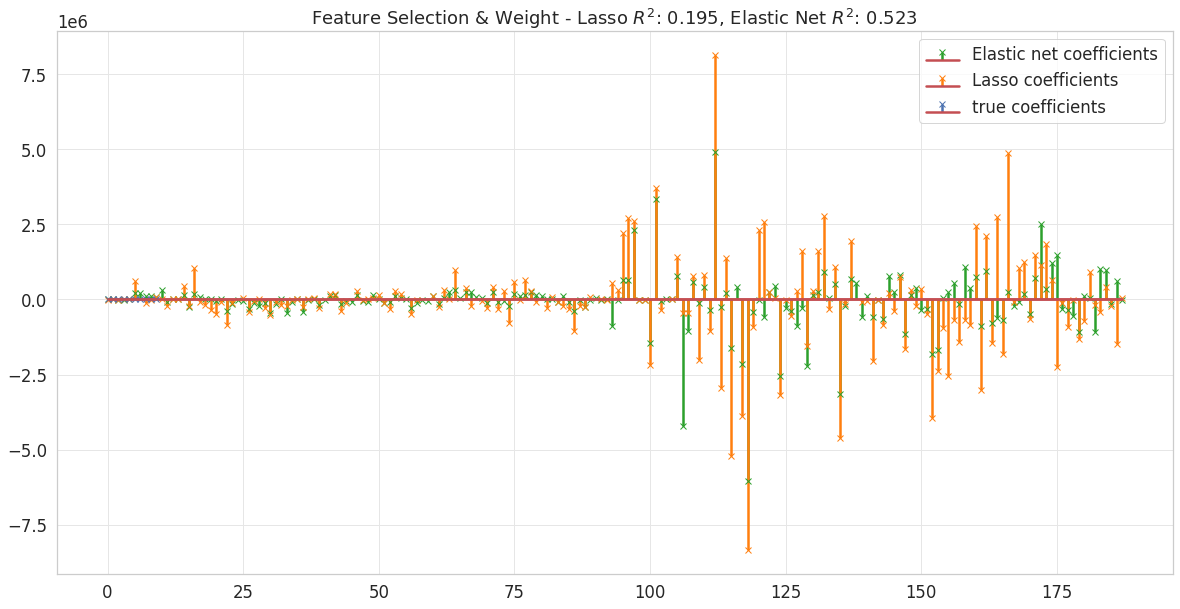

In [ ]:
## Define the LASSO model
alpha = 0.00057  # this is the shrinkage parameter, alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object
lasso = Lasso(alpha=alpha, normalize=True)
# Train and calculate R2 fit
y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("LASSO Model r^2 on test data : %f" % r2_score_lasso, '\n')

## Define the Elastic-Net model
enet = ElasticNet(alpha=alpha, l1_ratio=0.18, normalize=True)
y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("Elastic-Net Model r^2 on test data : %f" % r2_score_enet, '\n')

## Visualise the feature selection and weights
plt.figure(figsize=(20,10))
m, s, _ = plt.stem(np.where(enet.coef_)[0], enet.coef_[enet.coef_ != 0],
                   markerfmt='x', label='Elastic net coefficients',
                   use_line_collection=True)
plt.setp([m, s], color="#2ca02c")
m, s, _ = plt.stem(np.where(lasso.coef_)[0], lasso.coef_[lasso.coef_ != 0],
                   markerfmt='x', label='Lasso coefficients',
                   use_line_collection=True)
plt.setp([m, s], color='#ff7f0e')
plt.stem(np.where(coef)[0], coef[coef != 0], label='true coefficients',
         markerfmt='bx', use_line_collection=True)

plt.legend(loc='best')
plt.title("Feature Selection & Weight - Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

#### **Optimum LASSO Net-Model Perfomance**

Root Mean Squared Error fitting to the Train data:        0.12490976958100168
Root Mean Squared Error fitting to the Test data:         349.27990084837745
Root Mean Squared Error fitting to the Validation data:   0.06588128985562657 

Mean Percentage Error fitting to the Train data:        0.003499510900044223
Mean Percentage Error fitting to the Test data:         -10.648800909257677
Mean Percentage Error fitting to the Validation data:   -0.0005311515395789795 



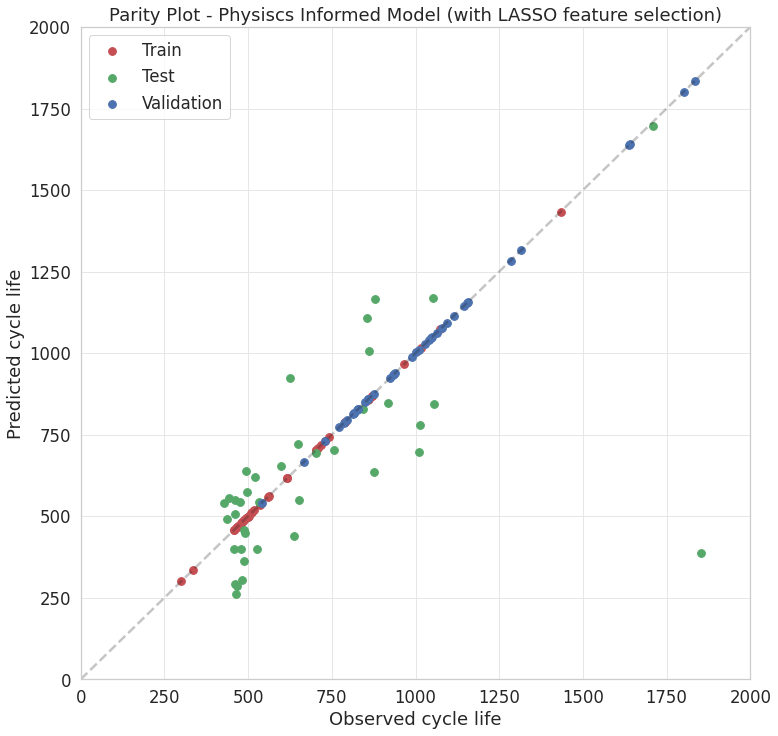

In [ ]:
y_pred = {}          # Create a dictionary in which to store the results
y_pred['Train']      = lasso.fit(X_train, y_train).predict(X_train)       # Predict the labels on previously seen (witin epoch) training data
y_pred['Test']       = lasso.fit(X_train, y_train).predict(X_test)        # Predict the labels on previously seen (each epoch) validation data 

features_selected = X_train.iloc[:,np.where(lasso.coef_)[0]].tail(2).keys() # Find the names of the features that were selected
selection = validation_pm4_l.loc[:, features_selected]                      # Create a subsection of validation with these collumns
selection = selection.loc[:,~selection.columns.duplicated()]                # Drop duplicate collumns

y_pred['Validation'] = lasso.fit(selection, validation['cycle_life']).predict(selection) # Predict the labels on unseen seen validation data

# Calculate model RMSE (units of cycles)
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train, y_pred['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test, y_pred['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation['cycle_life'], y_pred['Validation'])),'\n')

# Obtain a side-by-side data comparsion of the predicted vs observed data
train_forecast = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred['Train']}).head(10)
test_forecast = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred['Test']}).head(10)
validation_forecast = pd.DataFrame({'Actual': validation['cycle_life'], 'Predicted': y_pred['Validation']}).head(10)
    
train_forecast['MPE'] = ((train_forecast.Actual - train_forecast.Predicted) / train_forecast.Actual) * 100
test_forecast['MPE'] = ((test_forecast.Actual - test_forecast.Predicted) / test_forecast.Actual) * 100
validation_forecast['MPE'] = ((validation_forecast.Actual - validation_forecast.Predicted) / validation_forecast.Actual) * 100

# Print the results
print('Mean Percentage Error fitting to the Train data:       ', train_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Test data:        ', test_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Validation data:  ', validation_forecast['MPE'].mean(),'\n')

# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train, y=y_pred['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test, y=y_pred_enet, s=60, c='g', label='Test')
ax.scatter(x=validation['cycle_life'], y=y_pred['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model (with LASSO feature selection)')
plt.show()

#### **Optimum Elastic Net-Model Perfomance**

Root Mean Squared Error fitting to the Train data:        15.927112261712729
Root Mean Squared Error fitting to the Test data:         268.7630017726498
Root Mean Squared Error fitting to the Validation data:   12.356901686705987 

Mean Percentage Error fitting to the Train data:        0.6033982512980645
Mean Percentage Error fitting to the Test data:         -1.4956648797625391
Mean Percentage Error fitting to the Validation data:   0.2534938319689052 



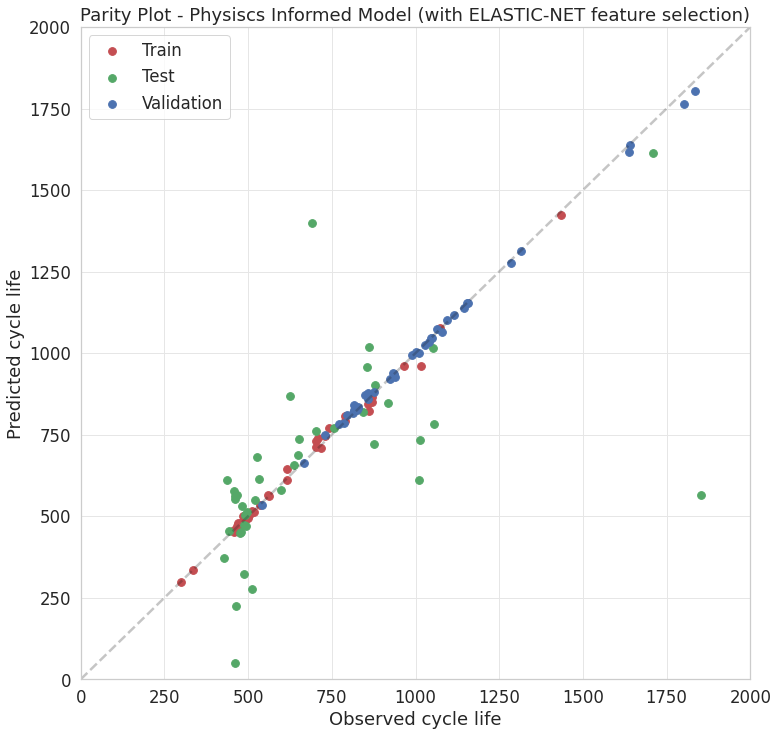

In [ ]:
y_pred = {}          # Create a dictionary in which to store the results
y_pred['Train']      = enet.fit(X_train, y_train).predict(X_train)       # Predict the labels on previously seen (witin epoch) training data
y_pred['Test']       = enet.fit(X_train, y_train).predict(X_test)        # Predict the labels on previously seen (each epoch) validation data 

features_selected = X_train.iloc[:,np.where(enet.coef_)[0]].tail(2).keys() # Find the names of the features that were selected
selection = validation_pm4_l.loc[:, features_selected]                      # Create a subsection of validation with these collumns
selection = selection.loc[:,~selection.columns.duplicated()]                # Drop duplicate collumns

y_pred['Validation'] = enet.fit(selection, validation['cycle_life']).predict(selection) # Predict the labels on unseen seen validation data

# Calculate model RMSE (units of cycles)
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train, y_pred['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test, y_pred['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation['cycle_life'], y_pred['Validation'])),'\n')

# Obtain a side-by-side data comparsion of the predicted vs observed data
train_forecast = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred['Train']}).head(10)
test_forecast = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred['Test']}).head(10)
validation_forecast = pd.DataFrame({'Actual': validation['cycle_life'], 'Predicted': y_pred['Validation']}).head(10)
    
train_forecast['MPE'] = ((train_forecast.Actual - train_forecast.Predicted) / train_forecast.Actual) * 100
test_forecast['MPE'] = ((test_forecast.Actual - test_forecast.Predicted) / test_forecast.Actual) * 100
validation_forecast['MPE'] = ((validation_forecast.Actual - validation_forecast.Predicted) / validation_forecast.Actual) * 100

# Print the results
print('Mean Percentage Error fitting to the Train data:       ', train_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Test data:        ', test_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Validation data:  ', validation_forecast['MPE'].mean(),'\n')

# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train, y=y_pred['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test, y=y_pred_enet, s=60, c='g', label='Test')
ax.scatter(x=validation['cycle_life'], y=y_pred['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model (with ELASTIC-NET feature selection)')
plt.show()

### **Conclusion**

The regularization and hyperparameter optimization techniques we applied achieved remarkable progress. 

The optimum model (elastic-net regularized linear multivariate regression on the first 100 cycles) achieved approximately:
- 270 Root Mean Squared Error - vs - 214 in previously published results
- -1.5% Mean Percentual Error (slight bias towards underestimating) - vs - 9% in previously published results
- 27% Mean Absolute Percentual Error
when assessed against the test dataset for test for quantitatively predicting cycle life. This compares well with previously published results.

## Assessing optimum model's performance using just the first 50 cycles (half the data)
To replicate the code below simply find `target_cycles = range(0,100)' in this notebook and change 100 to 40 re-running the cells for every occurance

Lasso(alpha=0.00057, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
LASSO Model r^2 on test data : 0.266487 

ElasticNet(alpha=0.00057, copy_X=True, fit_intercept=True, l1_ratio=0.18,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Elastic-Net Model r^2 on test data : 0.711896 



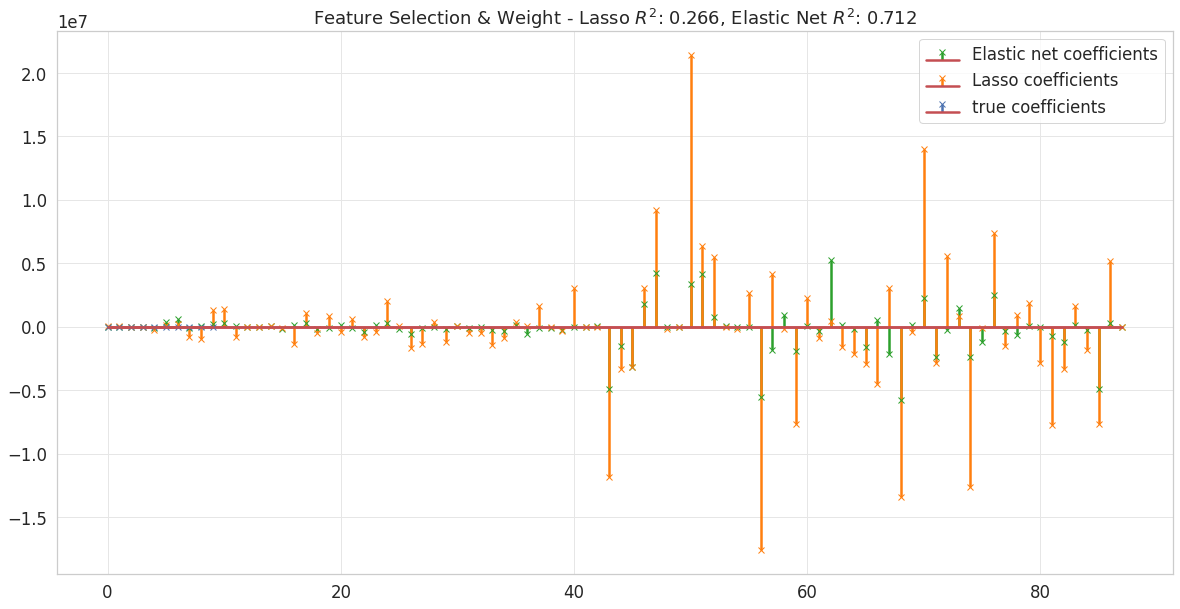

In [ ]:
## Define the LASSO model
alpha = 0.00057  # this is the shrinkage parameter, alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object
lasso = Lasso(alpha=alpha, normalize=True)
# Train and calculate R2 fit
y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("LASSO Model r^2 on test data : %f" % r2_score_lasso, '\n')

## Define the Elastic-Net model
enet = ElasticNet(alpha=alpha, l1_ratio=0.18, normalize=True)
y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("Elastic-Net Model r^2 on test data : %f" % r2_score_enet, '\n')

## Visualise the feature selection and weights
plt.figure(figsize=(20,10))
m, s, _ = plt.stem(np.where(enet.coef_)[0], enet.coef_[enet.coef_ != 0],
                   markerfmt='x', label='Elastic net coefficients',
                   use_line_collection=True)
plt.setp([m, s], color="#2ca02c")
m, s, _ = plt.stem(np.where(lasso.coef_)[0], lasso.coef_[lasso.coef_ != 0],
                   markerfmt='x', label='Lasso coefficients',
                   use_line_collection=True)
plt.setp([m, s], color='#ff7f0e')
plt.stem(np.where(coef)[0], coef[coef != 0], label='true coefficients',
         markerfmt='bx', use_line_collection=True)

plt.legend(loc='best')
plt.title("Feature Selection & Weight - Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

Root Mean Squared Error fitting to the Train data:        50.886576658492466
Root Mean Squared Error fitting to the Test data:         208.9161673095682
Root Mean Squared Error fitting to the Validation data:   109.36780728379252 

Mean Percentage Error fitting to the Train data:        2.255858896565202
Mean Percentage Error fitting to the Test data:         4.532043428393723
Mean Percentage Error fitting to the Validation data:   2.189700914138248 



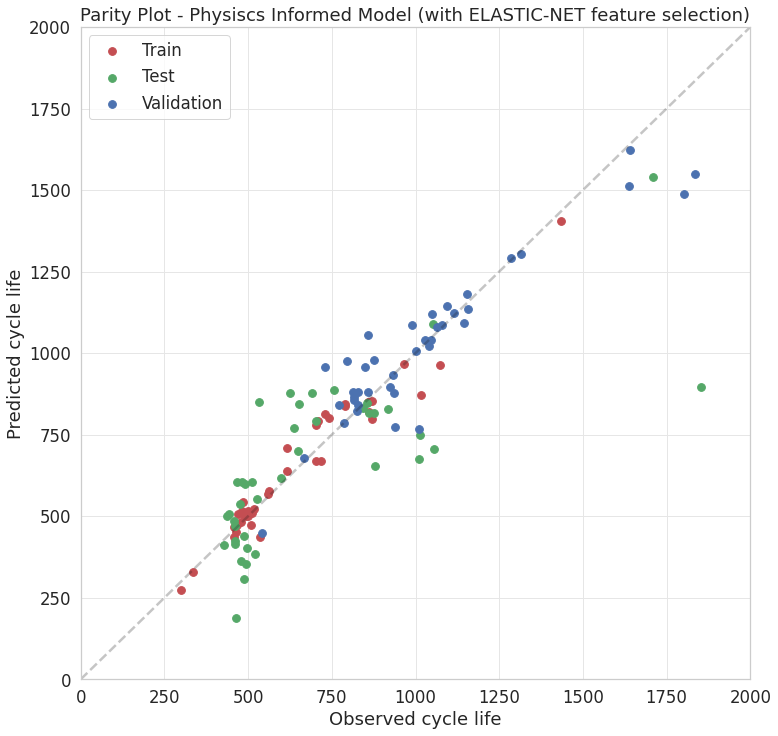

In [ ]:
y_pred = {}          # Create a dictionary in which to store the results
y_pred['Train']      = enet.fit(X_train, y_train).predict(X_train)       # Predict the labels on previously seen (witin epoch) training data
y_pred['Test']       = enet.fit(X_train, y_train).predict(X_test)        # Predict the labels on previously seen (each epoch) validation data 

features_selected = X_train.iloc[:,np.where(enet.coef_)[0]].tail(2).keys() # Find the names of the features that were selected
selection = validation_pm4_l.loc[:, features_selected]                      # Create a subsection of validation with these collumns
selection = selection.loc[:,~selection.columns.duplicated()]                # Drop duplicate collumns

y_pred['Validation'] = enet.fit(selection, validation['cycle_life']).predict(selection) # Predict the labels on unseen seen validation data

# Calculate model RMSE (units of cycles)
import numpy as np
print('Root Mean Squared Error fitting to the Train data:       ', np.sqrt(metrics.mean_squared_error(y_train, y_pred['Train'])))
print('Root Mean Squared Error fitting to the Test data:        ', np.sqrt(metrics.mean_squared_error(y_test, y_pred['Test'])))
print('Root Mean Squared Error fitting to the Validation data:  ', np.sqrt(metrics.mean_squared_error(validation['cycle_life'], y_pred['Validation'])),'\n')

# Obtain a side-by-side data comparsion of the predicted vs observed data
train_forecast = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred['Train']}).head(10)
test_forecast = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred['Test']}).head(10)
validation_forecast = pd.DataFrame({'Actual': validation['cycle_life'], 'Predicted': y_pred['Validation']}).head(10)
    
train_forecast['MPE'] = ((train_forecast.Actual - train_forecast.Predicted) / train_forecast.Actual) * 100
test_forecast['MPE'] = ((test_forecast.Actual - test_forecast.Predicted) / test_forecast.Actual) * 100
validation_forecast['MPE'] = ((validation_forecast.Actual - validation_forecast.Predicted) / validation_forecast.Actual) * 100

# Print the results
print('Mean Percentage Error fitting to the Train data:       ', train_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Test data:        ', test_forecast['MPE'].mean())
print('Mean Percentage Error fitting to the Validation data:  ', validation_forecast['MPE'].mean(),'\n')

# Create a scatter parity plots with different colors/markers for each of test, train, and validation sets
f, ax = plt.subplots(figsize=(12,12))
lim = 2000
ax.scatter(x=y_train, y=y_pred['Train'], s=60, c='r', label='Train')
ax.scatter(x=y_test, y=y_pred_enet, s=60, c='g', label='Test')
ax.scatter(x=validation['cycle_life'], y=y_pred['Validation'], s=60, c='b', label='Validation')

add_identity(ax, color='k', ls='--', alpha=0.25) # add a diagonal line 

plt.xlim(0,lim)
ax.set_xlabel('Observed cycle life')
plt.ylim(0,lim)
ax.set_ylabel('Predicted cycle life')
plt.legend()
plt.title('Parity Plot - Physiscs Informed Model (with ELASTIC-NET feature selection)')
plt.show()

**Observations**

**Although variance increases the results are very promising when benchmarking against the test dataset!**
- RMSE does not increase significantly (up to 288 form 268)
- neither does the MPE (up to 4.5 from -1.5)

This shows the optimum model performs well even when only informed by just the fist 50 cycles (which is just 6.2% of the average cycle life)




---



# Logistic Regression Classification

In a manufacturing setting, we may not cycle a battery 100 times, but
instead just want to classify a battery as "low"/"high" cycle life based on
the first 5 cycles. For this purpose we will develop and train two logistic regression models (univariate and multivariate) **using just the data from the first 5 cycles**.


### **M.1** Classifier Model informed by the QD Delta of the first five cycles - Random Forrest

#### **Features data preparation**

The feature is just the variances of the "5-4 difference vector" alone: **var_vector_5to4**

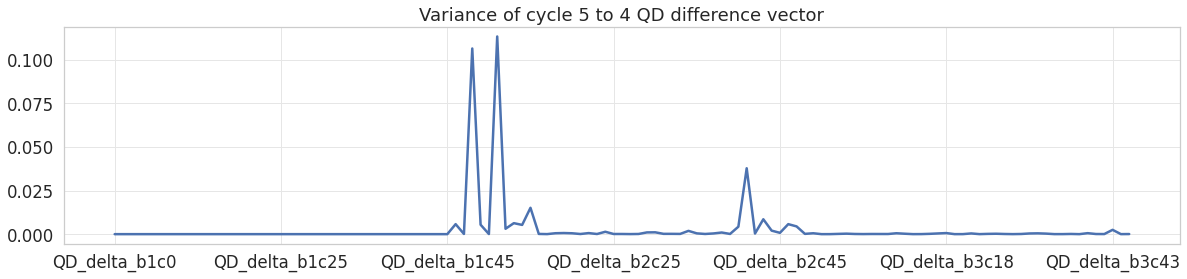

In [ ]:
# Initiate a dataFrame in which to store all the delta vectors between cells
delta_df_5to4 = pd.DataFrame()

for cell_name in bat_dict.keys():
  # Extract the cell cycles properties between cycles 5 and 0
  cell_temp_cycle5 = pd.DataFrame.from_dict(bat_df_cycles[cell_name][5], orient='index').T
  cell_temp_cycle4 = pd.DataFrame.from_dict(bat_df_cycles[cell_name][0], orient='index').T
  
  # Calculate the delta of this cell between the two two cell discharge capacities
  divergence_vector = (cell_temp_cycle5['Qd'] - cell_temp_cycle4['Qd'])

  # Store this vector into a DataFrame
  delta_df_5to4['QD_delta_' + cell_name] = divergence_vector

# Output the results
plt.subplots(figsize=(20,4))
delta_df_5to4.var().plot()
plt.title('Variance of cycle 5 to 4 QD difference vector')

var_vector_5to4 = delta_df_5to4.var() # record the variance vector

In [ ]:
# Combine the variance and cycle life into one dataset
data_cfy_m1 = pd.DataFrame(var_vector, columns=['var_QD_delta_5to4'])
data_cfy_m1['cycle_life'] = cycle_lifes.values

# This will be the input data for this model
data_cfy_m1

var_QD_delta_5to4  cycle_life
QD_delta_b1c0            0.000099      1852.0
QD_delta_b1c1            0.002113      2160.0
QD_delta_b1c2            0.003823      2237.0
QD_delta_b1c3            0.000269      1434.0
QD_delta_b1c4            0.000394      1709.0
...                           ...         ...
QD_delta_b3c41           0.000012       786.0
QD_delta_b3c42           0.002857      1642.0
QD_delta_b3c43           0.001061      1046.0
QD_delta_b3c44           0.000978       940.0
QD_delta_b3c45           0.000943      1801.0

[123 rows x 2 columns]

**Defining the categories**

We will chose 550 cycles as the high-low cut-off and consider all cells that achieved or are predicted to achieve a cycle life of less than this value, "low" lifetime, and all the rest as "high" lifetime. Let us define another binary labels column accordingly.

In [ ]:
high_low_cutoff = 550

# Initialise a column in which to classify the cycle lifes and store the labels
import numpy as np
data_cfy_m1['quality_pass'] = np.NAN

# Loop over all of the cell life rows and create a corresponding entri in the labels column
for cell_index in range(0, len(data_cfy_m1['cycle_life'])):
  if data_cfy_m1['cycle_life'][cell_index] < high_low_cutoff:
    data_cfy_m1['quality_pass'][cell_index] = True
  else:
    data_cfy_m1['quality_pass'][cell_index] = False

# Now all the labels are classified
data_cfy_m1.sample(5)

var_QD_delta_5to4  cycle_life  quality_pass
QD_delta_b3c12           0.000058       932.0           0.0
QD_delta_b1c4            0.000394      1709.0           0.0
QD_delta_b3c35           0.000221      1093.0           0.0
QD_delta_b1c34           0.001455       742.0           0.0
QD_delta_b3c1            0.000040      1063.0           0.0

#### **Data Selection: Test, Train, and Validation**
In order to compare the logistic regression model with Severson et. al. [[7]](https://www.nature.com/articles/s41560-019-0356-8), we need to split the data using the same train/test split.

In [ ]:
# Define the test and train cell indices as indicated by the paper authors
test_ind = np.hstack((np.arange(0,(n_batch1+n_batch2),2),83))
train_ind = np.arange(1,(n_batch1+n_batch2-1),2)
validation_ind = np.arange(n-n_batch3,n)

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_cfy_m1 = data_cfy_m1.iloc[validation_ind]  
X_validation_cfy_m1, y_validation_cfy_m1  = validation_cfy_m1.iloc[:, validation_cfy_m1.columns.str.contains('QD')], validation_cfy_m1.quality_pass))

# Define the test-train main set
X_tt_cfy_m1 = data_cfy_m1.iloc[:, data_cfy_m1.columns.str.contains('QD')]      # our predictors or “attributes” - just the "5-4 difference vector"
y_tt_cfy_m1 = data_cfy_m1['quality_pass']                                      # the value we would like to predict or "labels" - the cycle life classification

# Split the test-train data
X_train_cfy_m1, y_train_cfy_m1 = X_tt_cfy_m1.iloc[train_ind], y_tt_cfy_m1.iloc[train_ind]
X_test_cfy_m1,  y_test_cfy_m1  = X_tt_cfy_m1.iloc[test_ind],  y_tt_cfy_m1.iloc[test_ind]

#### **Training the model**

In [ ]:
# Create a Random Forrest and then train it on the dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
classifier, y_train_cfy_m1 = make_classification(n_samples=40, shuffle=False)
classifier = RandomForestClassifier(max_depth=2, random_state=0)  # chose a medium growth for the forrest as not to overfit the dataset
classifier.fit(X_train_cfy_m1, y_train_cfy_m1)

# # For comparison you can uncomment the thee lines below to train a simple LogisticRegression model which only achieves results as good as chance
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression()                  # create logistic regression object 
# classifier.fit(X_train_cfy_m1, y_train_cfy_m1)     # fit linear regression using the training

y_pred_cfy_m1 = {}          # Create a dictionary in which to store the results
y_pred_cfy_m1['Train']      = classifier.predict(X_train_cfy_m1)        # Predict the labels on previously seen (witin epoch) training data
y_pred_cfy_m1['Test']       = classifier.predict(X_test_cfy_m1)         # Predict the labels on previously seen (each epoch) validation data 
y_pred_cfy_m1['Validation'] = classifier.predict(X_validation_cfy_m1)   # Predict the labels on unseen seen validation data

# Calculate and print model accuracy
print('Accuracy of logistic regression classifier on Training   set: {:.2f}'.format(classifier.score(X_train_cfy_m1, y_train_cfy_m1)))
print('Accuracy of logistic regression classifier on Test       set: {:.2f}'.format(classifier.score(X_test_cfy_m1, y_test_cfy_m1)))
print('Accuracy of logistic regression classifier on Validation set: {:.2f}'.format(classifier.score(X_validation_cfy_m1, y_validation_cfy_m1)))
confusion_matrix(y_test_cfy_m1, y_pred_cfy_m1['Test'])

Accuracy of logistic regression classifier on Training   set: 0.78
Accuracy of logistic regression classifier on Test       set: 0.67
Accuracy of logistic regression classifier on Validation set: 0.78


array([[17,  4],
       [10, 11]])

**Hyperparameter Tuning**

We can iterate over all of the hyperparameters of the random forrest to optimize it further.

The hyperparameter sweep presented in the following block of code is based on the work by Kevin Arvai [[16]](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65).

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import numpy as np

# Initialize a Random Forrest Object
clf = RandomForestClassifier(n_jobs=-1)

# Define the parameter values on whose combinations we should iterate
param_grid = {
    'min_samples_split': [1, 2, 3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [1, 2, 3, 5, 15, 25],
    'max_features': [1]
}

# Define the metrics on which the models will be benchmarked
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization and print classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_cfy_m1, y_train_cfy_m1)

    # make the predictions
    y_pred_cfy_m1 = grid_search.predict(X_test_cfy_m1)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test_cfy_m1, y_pred_cfy_m1),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 15, 'max_features': 1, 'min_samples_split': 3, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        15         6
pos         9        12


In this case we did not achieve any progress through the hyperparameter sweep.

#### **Analyzing results**

##### **Confusion Matrix**

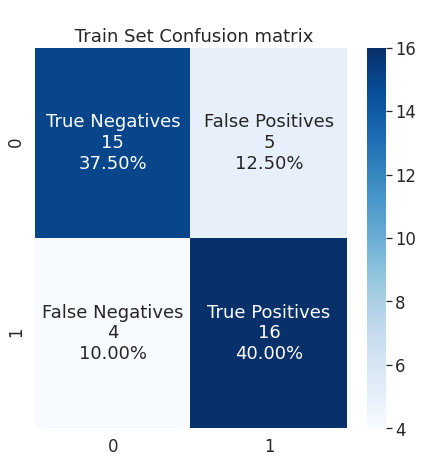

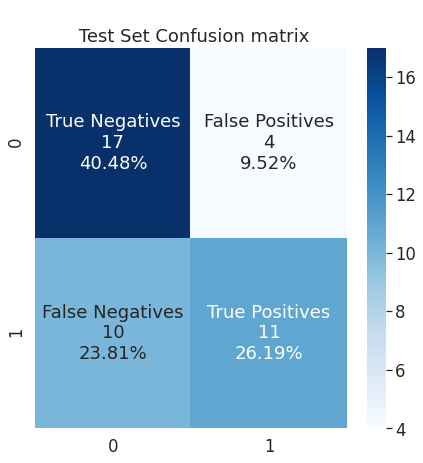

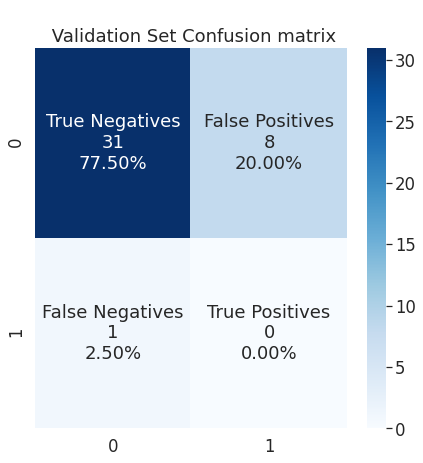

In [ ]:
# Define a finction to clearly visualise and interpret the resulting confusion matrix
def plot_confusion_matrix(cf_matrix, title='Confustion matrix'):
  plt.figure(figsize=(7,7))
  group_names = ["True Negatives","False Positives","False Negatives","True Positives"]
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
  sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}, )
  plt.title(title)
  # This function is based on the work of Dennis T.: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
  return plt.show();

from sklearn.metrics import confusion_matrix

# Calculate and plot confusion matrices
plot_confusion_matrix(confusion_matrix(y_train_cfy_m1, y_pred_cfy_m1['Train']), title='\n Train Set Confusion matrix')
plot_confusion_matrix(confusion_matrix(y_test_cfy_m1, y_pred_cfy_m1['Test']), title='\n Test Set Confusion matrix')
plot_confusion_matrix(confusion_matrix(y_validation_cfy_m1, y_pred_cfy_m1['Validation']), title='\n Validation Set Confusion matrix')

**Interpretation**

The model performs well on the train dataset, but it does not generalize well at all. Since for the validation dataset it achieves results no beter than chance and it is bias to classifying cells as 'low-life'

##### **Precision, recall, F-measure and support**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_cfy_m1, y_pred_cfy_m1['Test']))

              precision    recall  f1-score   support

         0.0       0.63      0.81      0.71        21
         1.0       0.73      0.52      0.61        21

    accuracy                           0.67        42
   macro avg       0.68      0.67      0.66        42
weighted avg       0.68      0.67      0.66        42



**Interpretation**

First let's define the metrics above [[17]](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8):
- *precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives*
- *recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives*
- *F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0*

In the test set forecast, the model identified all of the cells as low-life. This allowed it to obtain a fit just better than chace as there were 21 low-life and only 19 high-life examples in the dataset.

##### **Receiver Operating Characteristic (ROC) Curve**


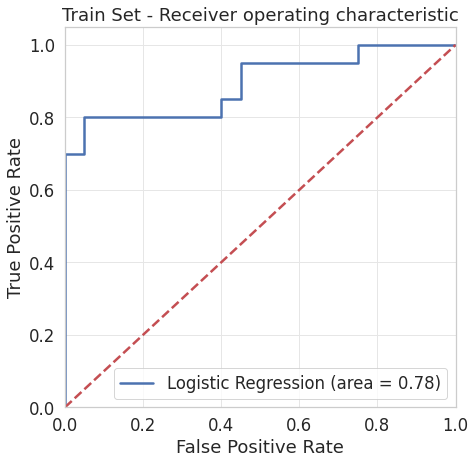

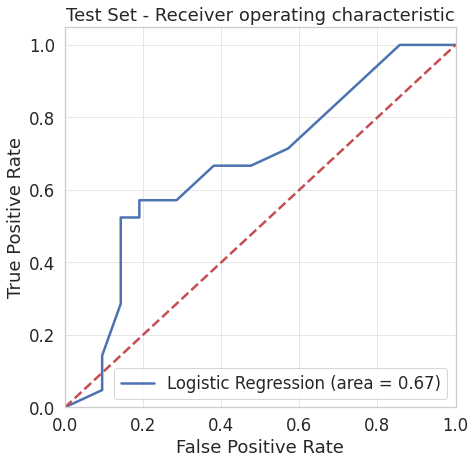

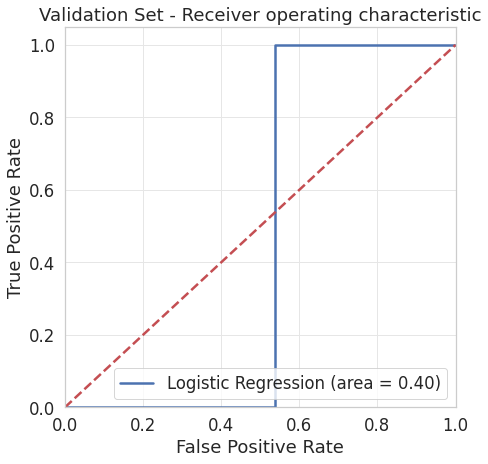

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Define a funciton for plotting the ROC Curve
def plot_roc(y, X, title=""):
  logit_roc_auc = roc_auc_score(y, classifier.predict(X))
  fpr, tpr, thresholds = roc_curve(y, classifier.predict_proba(X)[:,1])
  plt.figure(figsize=(7,7))
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(str(title) + ' - Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()

# Plot the ROC curves running the classier on the datasets
plot_roc(y_train_cfy_m1, X_train_cfy_m1, title = 'Train Set')
plot_roc(y_test_cfy_m1, X_test_cfy_m1, title = 'Test Set')
plot_roc(y_validation_cfy_m1, X_validation_cfy_m1, title = 'Validation Set')

#### **Observations and intepretation**

Looking at the ROC curves we can see that the model is close to the ROC dotted line representing pure chance, as this achieves a slight predictive power over the test dataset (llogistic regression approaching the top-left corner more). However, this is not generalizable at all, as the model fails completely when trying to forecast the validation dataset.

This very simple logistic regression model simply learned to classivy eveything as a `quality_pass = False`, i.e. low cycle life. Therefore, it achieve results no better than chance when looking at a previously unseen dataset (validation). 

### **M.2** Multivariate Classifier Model

#### **Features data preparation**

To improve the previous model, we use a multivariate approach, The predictive features we will use in defning this model will be: 
- the data used by model 1
- average chargetime
- integral of temperature from cycle 1 to 5

In [ ]:
# All the features used by the Logistic Regression Model 1
data_cfy_m2 = data_cfy_m1.copy()
data_cfy_m2

var_QD_delta_5to4  cycle_life  quality_pass
QD_delta_b1c0            0.000099      1852.0           0.0
QD_delta_b1c1            0.002113      2160.0           0.0
QD_delta_b1c2            0.003823      2237.0           0.0
QD_delta_b1c3            0.000269      1434.0           0.0
QD_delta_b1c4            0.000394      1709.0           0.0
...                           ...         ...           ...
QD_delta_b3c41           0.000012       786.0           0.0
QD_delta_b3c42           0.002857      1642.0           0.0
QD_delta_b3c43           0.001061      1046.0           0.0
QD_delta_b3c44           0.000978       940.0           0.0
QD_delta_b3c45           0.000943      1801.0           0.0

[123 rows x 3 columns]

Text(0.5, 1.0, 'cycle_life')

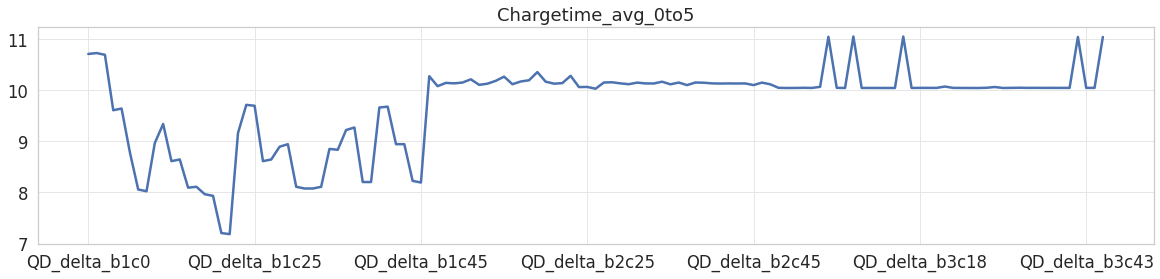

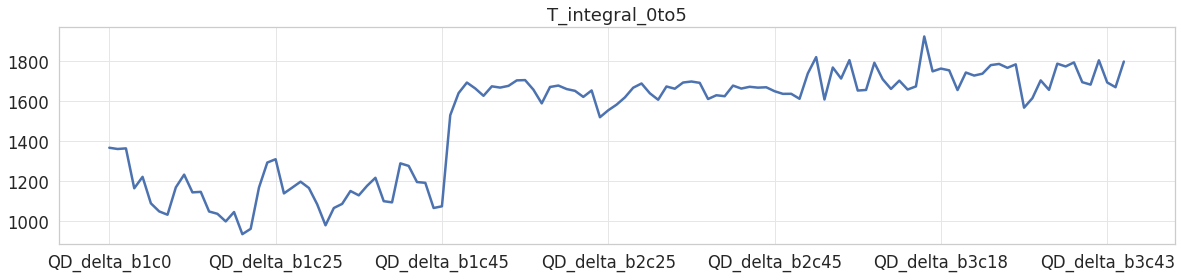

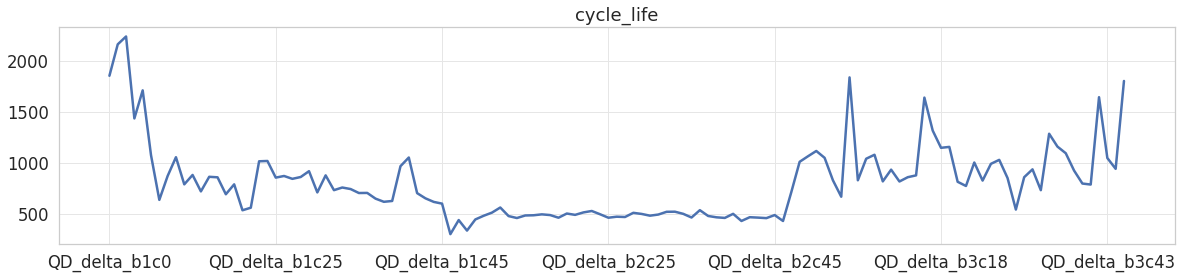

In [ ]:
# Initiate a dataFrame in which to store all the vectors
extracted_features = pd.DataFrame()
cell_temp_integral_ls = list()
cell_T_average_ls = list()

# Extract the cell cycles properties between target cycles (0 and 5)
cell_chargetime_average_ls = []
for cell_name in bat_dict.keys():
  # Calculate average charge time for this cell between the target cycles (0 and 5)
  cell_chargetime_average_ls.append(np.average(bat_df_summary.chargetime[cell_name][0:5]))

  # Calculate the integral of average temperature for this cell between the target cycles (0 and 5)
  cell_T_average_ls.append(np.sum(bat_df_summary.Tavg[cell_name][0:5] * np.average(bat_df_summary.chargetime[cell_name][0:5])))

  # # Alternatiuely: Calculate the integral of Temperature in time from cycle 0 to cycle 5
  # cycles_temp_integral_ls = []
  # for cycle in range(1,6):
  #   # For each cycle create a temporary dataframe to store the temperature and time curves
  #   temp_df = pd.DataFrame()
  #   temp_df['t'] = [v for v in (bat_df_cycles[cell_name][cycle])['t']]
  #   temp_df['T'] = [v for v in (bat_df_cycles[cell_name][cycle])['T']]
  #   # Calculate the Integral of the temperature curve between the two two cell discharge capacities amd store it
  #   cycles_temp_integral_ls.append(temp_df.set_index('t').apply(integrate.trapz)['T'])
  # cell_T_average_ls.append(np.average(cycles_temp_integral_ls))

# Store the results vector into a DataFrame
data_cfy_m2['Chargetime_avg_0to5'] = cell_chargetime_average_ls
data_cfy_m2['T_integral_0to5'] = cell_T_average_ls

# Output the results
plt.subplots(figsize=(20,4))
data_cfy_m2['Chargetime_avg_0to5'].plot()
plt.title('Chargetime_avg_0to5')

plt.subplots(figsize=(20,4))
data_cfy_m2['T_integral_0to5'].plot()
plt.title('T_integral_0to5')

plt.subplots(figsize=(20,4))
data_cfy_m2['cycle_life'].plot()
plt.title('cycle_life')

In [ ]:
data_cfy_m2

var_QD_delta_5to4  ...  T_integral_0to5
QD_delta_b1c0            0.000099  ...      1367.232187
QD_delta_b1c1            0.002113  ...      1361.001933
QD_delta_b1c2            0.003823  ...      1364.073283
QD_delta_b1c3            0.000269  ...      1164.621085
QD_delta_b1c4            0.000394  ...      1221.731626
...                           ...  ...              ...
QD_delta_b3c41           0.000012  ...      1682.665507
QD_delta_b3c42           0.002857  ...      1804.318911
QD_delta_b3c43           0.001061  ...      1693.493362
QD_delta_b3c44           0.000978  ...      1669.819545
QD_delta_b3c45           0.000943  ...      1798.014988

[123 rows x 5 columns]

#### **Data Selection: Test, Train, and Validation**
In order to compare the logistic regression model with Severson et. al. [[7]](https://www.nature.com/articles/s41560-019-0356-8), we need to split the data using the same train/test split.

In [ ]:
# Define the test and train cell indices as indicated by the paper authors
test_ind = np.hstack((np.arange(0,(n_batch1+n_batch2),2),83))
train_ind = np.arange(1,(n_batch1+n_batch2-1),2)
validation_ind = np.arange(n-n_batch3,n)

# Define the validation set (model training will be blind to this data) as the value from the third batch
validation_cfy_m2 = data_cfy_m2.iloc[validation_ind]  
X_validation_cfy_m2, y_validation_cfy_m2  = validation_cfy_m2.iloc[:, validation_cfy_m2.columns.str.contains('QD')], validation_cfy_m2.quality_pass

# Define the test-train main set
X_tt_cfy_m2 = data_cfy_m2.iloc[:, data_cfy_m2.columns.str.contains('QD')]      # our predictors or “attributes” - just the "5-4 difference vector"
y_tt_cfy_m2 = data_cfy_m2['quality_pass']                                      # the value we would like to predict or "labels" - the cycle life classification

# Split the test-train data
X_train_cfy_m2, y_train_cfy_m2 = X_tt_cfy_m2.iloc[train_ind], y_tt_cfy_m2.iloc[train_ind]
X_test_cfy_m2,  y_test_cfy_m2  = X_tt_cfy_m2.iloc[test_ind],  y_tt_cfy_m2.iloc[test_ind]

#### **Training the model**
We will build a multivariate regression model using all of the features we previously created.

In [ ]:
# Create a Random Forrest and then train it on the dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
classifier, y_train_cfy_m2 = make_classification(n_samples=40, shuffle=False)
classifier = RandomForestClassifier(max_depth=2, random_state=0,)  # chose a medium growth for the forrest as not to overfit the dataset
classifier.fit(X_train_cfy_m2, y_train_cfy_m2)

# # For comparison you can uncomment the thee lines below to train a simple LogisticRegression model which only achieves results as good as chance
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression()                  # create logistic regression object 
# classifier.fit(X_train_cfy_m2, y_train_cfy_m2)     # fit linear regression using the training

y_pred_cfy_m2 = {}          # Create a dictionary in which to store the results
y_pred_cfy_m2['Train']      = classifier.predict(X_train_cfy_m2)        # Predict the labels on previously seen (witin epoch) training data
y_pred_cfy_m2['Test']       = classifier.predict(X_test_cfy_m2)         # Predict the labels on previously seen (each epoch) validation data 
y_pred_cfy_m2['Validation'] = classifier.predict(X_validation_cfy_m2)   # Predict the labels on unseen seen validation data

# Calculate and print model accuracy
print('Accuracy of logistic regression classifier on Training   set: {:.2f}'.format(classifier.score(X_train_cfy_m2, y_train_cfy_m2)))
print('Accuracy of logistic regression classifier on Test       set: {:.2f}'.format(classifier.score(X_test_cfy_m2, y_test_cfy_m2)))
print('Accuracy of logistic regression classifier on Validation set: {:.2f}'.format(classifier.score(X_validation_cfy_m2, y_validation_cfy_m2)))

Accuracy of logistic regression classifier on Training   set: 0.72
Accuracy of logistic regression classifier on Test       set: 0.71
Accuracy of logistic regression classifier on Validation set: 0.80


#### **Hyperparameter Tuning**

We can iterate over all of the hyperparameters of the random forrest to optimize it further.

The hyperparameter sweep presented in the following block of code is based on the work by Kevin Arvai [[16]](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65).

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import numpy as np

# Initialize a Random Forrest Object
clf = RandomForestClassifier(n_jobs=-1)

# Define the parameter values on whose combinations we should iterate
param_grid = {
    'min_samples_split': [1, 2, 3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [1, 2, 3, 5, 15, 25],
    'max_features': [1, 2, 3]
}

# Define the metrics on which the models will be benchmarked
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(refit_score='precision_score'):
    """
    Fits a GridSearchCV classifier using refit_score for optimization and print classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_cfy_m2, y_train_cfy_m2)

    # make the predictions
    y_pred_cfy_m2 = grid_search.predict(X_test_cfy_m2)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test_cfy_m2, y_pred_cfy_m2),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='precision_score')
print('Accuracy of logistic regression classifier on Test       set: {:.2f}'.format(grid_search_clf.score(X_test_cfy_m2, y_test_cfy_m2)))

Best params for precision_score
{'max_depth': 25, 'max_features': 1, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        19         2
pos        16         5
Accuracy of logistic regression classifier on Test       set: 0.71


#### **Analyzing results**

##### **Confusion Matrix**

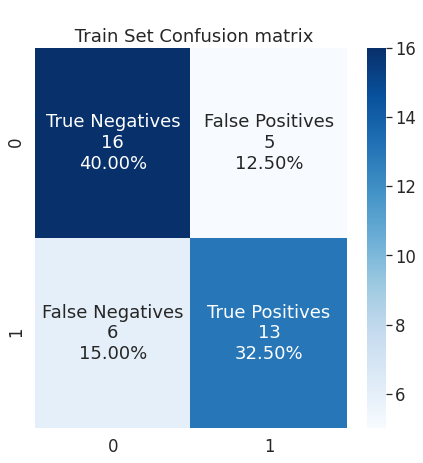

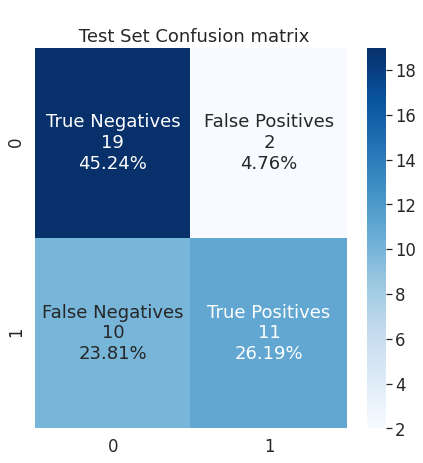

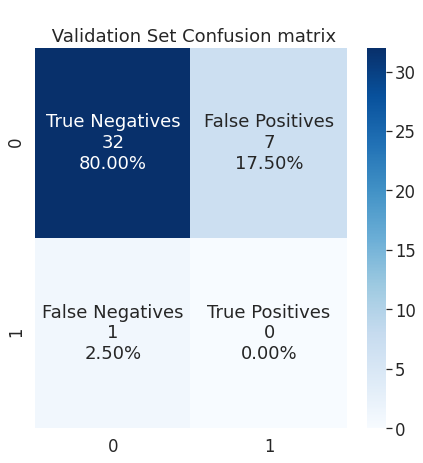

In [ ]:
# Calculate and plot confusion matrices
plot_confusion_matrix(confusion_matrix(y_train_cfy_m2, y_pred_cfy_m2['Train']), title='\n Train Set Confusion matrix')
plot_confusion_matrix(confusion_matrix(y_test_cfy_m2, y_pred_cfy_m2['Test']), title='\n Test Set Confusion matrix')
plot_confusion_matrix(confusion_matrix(y_validation_cfy_m2, y_pred_cfy_m2['Validation']), title='\n Validation Set Confusion matrix')

##### **Precision, recall, F-measure and support**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_cfy_m2, y_pred_cfy_m2['Test']))

              precision    recall  f1-score   support

         0.0       0.66      0.90      0.76        21
         1.0       0.85      0.52      0.65        21

    accuracy                           0.71        42
   macro avg       0.75      0.71      0.70        42
weighted avg       0.75      0.71      0.70        42



##### **Receiver Operating Characteristic (ROC) Curve**


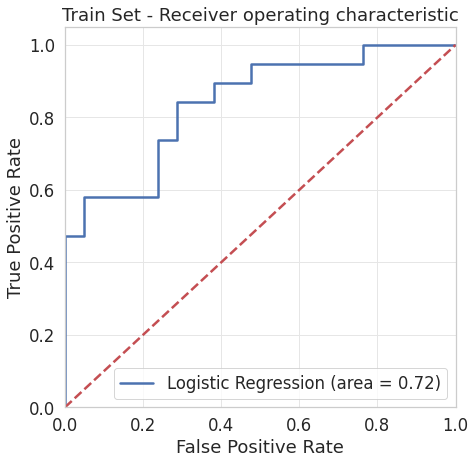

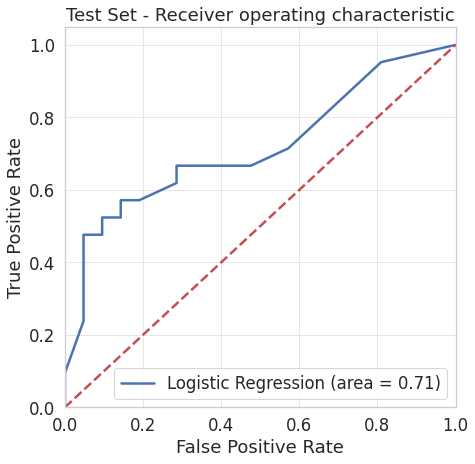

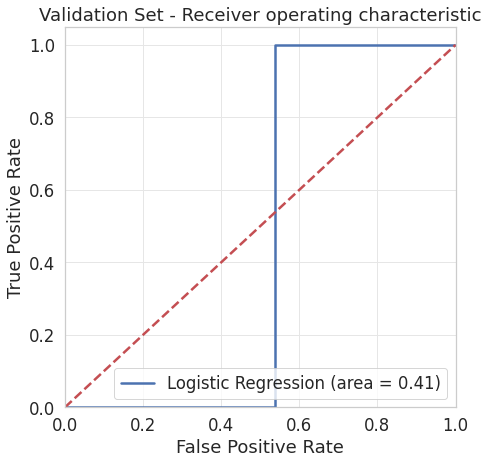

In [ ]:
# Plot the ROC curves running the classier on the datasets
plot_roc(y_train_cfy_m2, X_train_cfy_m2, title = 'Train Set')
plot_roc(y_test_cfy_m2, X_test_cfy_m2, title = 'Test Set')
plot_roc(y_validation_cfy_m2, X_validation_cfy_m2, title = 'Validation Set')

#### **Observations and intepretation**

Looking at the ROC and confusion matrix, the model has not improved with the additional data. Moreover, hyperparameter optimization led to the deactivation of the additional features. Hnece the predictive power of the additinal features is not sufficient.

## Comparsion with previously published resuts
Unlike the quantitative lifecycle prediction through multivariate regression, logistic classification using just the first 5 cycles did not yield results better than those published by Severson et. al. [[7]](https://www.nature.com/articles/s41560-019-0356-8), namely a classification accuracy % of 82.1 78.6 97.5 for the Train Primary test Secondary. The best results achieved only 72, 71 and 80 % for the multivariate model and 78, 67, 78 for the simple model, both for the respective datasets (Train-Test-Validation).

### Troubleshooting

In [ ]:
## Visualising Plotly Graphs in Jupyter Lab
!conda install -c conda-forge nodejs

!set NODE_OPTIONS=--max-old-space-size=4096

# Jupyter widgets extension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.1 --no-build

# jupyterlab renderer support
!jupyter labextension install jupyterlab-plotly@4.6.0 --no-build

!jupyter labextension install plotlywidget@4.6.0 --no-build

# Build extensions (must be done to activate extensions since --no-build is used above)
!jupyter lab build

# Unset NODE_OPTIONS environment variable
!set NODE_OPTIONS=

import plotly.express as px

fig = px.line(x=bat_dict[i]['summary']['cycle'], y=bat_dict[i]['summary']['QD'], title='Life')
%matplotlib inline
fig.show()

In [ ]:
# using just interal resistance
data_m3